# Check results from 10 simulation boxes:

In [1]:
import yaw
import numpy as np
from astropy.io import fits
import pylab as pl
from yaw.correlation import autocorrelate_scalar, crosscorrelate_scalar
import healpy as hp

# 1. Plot spectra

In [44]:
def weighted_lyaf(wave, delta, weight, zqso, zbin_edges, old=False, nonval=0):
    # the old code was wrong but want to see what's the impact
    emit = 1215.67
    lambda_rf_min=1040
    lambda_rf_max=1200
    dodgy_lowz_cut=3600
    
    objred = (wave-emit)/emit
    lambda_obs_min=lambda_rf_min*(1+zqso)
    lambda_obs_max=lambda_rf_max*(1+zqso)
    in_forest=np.logical_and(wave > lambda_obs_min, wave < lambda_obs_max)
    in_forest *= wave > dodgy_lowz_cut

    # now bin:
    deltaF = np.ones(len(zbin_edges)-1)*nonval
    for kk in range(len(zbin_edges)-1):
        useind = (objred>zbin_edges[kk])&(objred<=zbin_edges[kk+1])
        useind *= in_forest
        if len(objred[useind])>0:
            num_pix = len(objred[useind])
            totweights = np.sum(weight[useind])
            # weighted average of deltaF
            if old == False:
                deltaF[kk] = np.sum(delta[useind]*weight[useind])/totweights
            elif old == True:
                deltaF[kk] = np.sum(delta[useind])/num_pix
    return deltaF

In [28]:
zbin_edges = np.linspace(2.00, 3.00, 21)
zz = (zbin_edges[1:] + zbin_edges[:-1])/2.

In [4]:
root = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/"

In [5]:
# raw:
simroot = root + f"analysis-0/jura-0/raw/deltas_lya/Delta/"
print(simroot)
#fname_list = glob(simroot + "*.fits.gz", recursive = True)

fin = fits.open(simroot  + "delta-1334.fits.gz")
hduh = fin[1].header
print(hduh)

jj = 0
wavelength_log = fin[jj+1].data['LOGLAM']
delta1 = fin[jj+1].data['DELTA']
weights1 = fin[jj+1].data['WEIGHT']
wave = 10**wavelength_log
zqso = hduh['Z']
ra = hduh['RA']
dec = hduh['DEC']
print(ra, dec, zqso)

emit = 1215.67
objred = (wave-emit)/emit

/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/analysis-0/jura-0/raw/deltas_lya/Delta/
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / 8-bit bytes                                    NAXIS   =                    2 / 2-dimensional binary table                     NAXIS1  =                   32 / width of table in bytes                        NAXIS2  =                  793 / number of rows in table                        PCOUNT  =                    0 / size of special data area                      GCOUNT  =                    1 / one data group (required keyword)              TFIELDS =                    4 / number of fields in each row                   TTYPE1  = 'LOGLAM  '           / label for field   1                            TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE            TTYPE2  = 'DELTA   '           / label for f

In [45]:
deltaFbin1 = weighted_lyaf(wave, delta1, weights1, zqso, zbin_edges, old=False, nonval=-10)
deltaFbin1_old = weighted_lyaf(wave, delta1, weights1, zqso, zbin_edges, old=True)

Text(0, 0.5, '$\\delta F$')

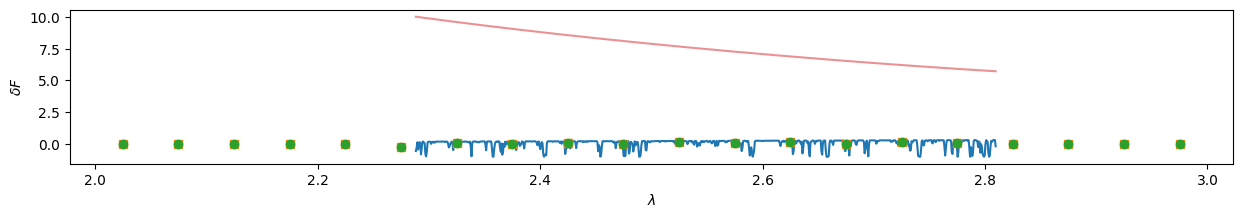

In [31]:
# let's plot the flux, binned flux for old and new cases:
pl.figure(figsize=[15,2])
pl.plot(objred, delta1)
pl.plot(zz, deltaFbin1,'s')
pl.plot(zz, deltaFbin1_old,'o')
pl.plot(objred, weights1,alpha=0.5)
pl.xlabel("$\\lambda$")
pl.ylabel("$\\delta F$")
#pl.xlim([2.3,2.82])

In [50]:
zbin_edges[1:][deltaFbin1!=-10]

array([2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 , 2.75, 2.8 ])

In [8]:
# check object ID for the noisy ones:
root = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/"
simroot = root + f"analysis-0/jura-0/uncontaminated/deltas_lya/Delta/"
print(simroot)

fin = fits.open(simroot  + "delta-1334.fits.gz")
hdu = fin[1].header
#hduh
print(fin[2].header)
ID = fin[2].data['LOS_ID']
objind = ID == 870000004
wave2 = fin[1].data
ra = (fin[2].data['RA'])[objind]
dec = (fin[2].data['DEC'])[objind]
zqso2 = fin[2].data['Z'][objind]
delta2 = fin[3].data[objind,:]
weights2 = fin[4].data[objind,:]
objred = (wave2-emit)/emit
print(ra, dec, zqso2)

/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/analysis-0/jura-0/uncontaminated/deltas_lya/Delta/
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / 8-bit bytes                                    NAXIS   =                    2 / 2-dimensional binary table                     NAXIS1  =                   84 / width of table in bytes                        NAXIS2  =                  829 / number of rows in table                        PCOUNT  =                    0 / size of special data area                      GCOUNT  =                    1 / one data group (required keyword)              TFIELDS =                    9 / number of fields in each row                   TTYPE1  = 'LOS_ID  '           / label for field   1                            TFORM1  = 'K       '           / data format of field: 8-byte INTEGER           TTYPE2  = 'RA      '           / 

In [10]:
deltaFbin2 = weighted_lyaf(wave2, delta2[0,:], weights2[0,:], zqso2, zbin_edges, old=False)
deltaFbin2_old = weighted_lyaf(wave2, delta2[0,:], weights2[0,:], zqso2, zbin_edges, old=True)

(2.3, 2.82)

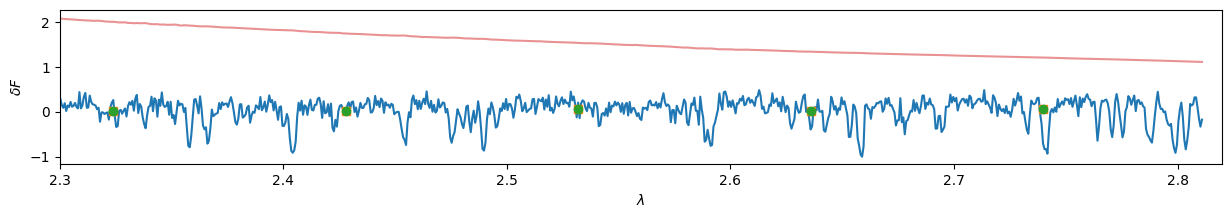

In [11]:
# let's plot the flux, binned flux for old and new cases:
pl.figure(figsize=[15,2])
pl.plot(objred, delta2[0,:])
pl.plot(zz, deltaFbin2,'s')
pl.plot(zz, deltaFbin2_old,'o')
pl.plot(objred, weights2[0,:],alpha=0.5)
pl.xlabel("$\\lambda$")
pl.ylabel("$\\delta F$")
pl.xlim([2.3,2.82])

Check file below

In [12]:
# check object ID for the noisy ones:
root = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/"
simroot = root + f"analysis-0/jura-0/true_cont/deltas_lya/Delta/"
print(simroot)

fin = fits.open(simroot  + "delta-1334.fits.gz")
hdu = fin[1].header
#hduh
print(fin[2].header)
ID = fin[2].data['LOS_ID']
objind = ID == 870000004
print(np.arange(len(ID))[objind])
wave3 = fin[1].data
ra = (fin[2].data['RA'])[objind]
dec = (fin[2].data['DEC'])[objind]
zqso3 = fin[2].data['Z'][objind]
delta3 = fin[3].data[objind,:]
weights3 = fin[4].data[objind,:]
objred3 = (wave3-emit)/emit
print(ra, dec, zqso3)

/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/analysis-0/jura-0/true_cont/deltas_lya/Delta/
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / 8-bit bytes                                    NAXIS   =                    2 / 2-dimensional binary table                     NAXIS1  =                   84 / width of table in bytes                        NAXIS2  =                  811 / number of rows in table                        PCOUNT  =                    0 / size of special data area                      GCOUNT  =                    1 / one data group (required keyword)              TFIELDS =                    9 / number of fields in each row                   TTYPE1  = 'LOS_ID  '           / label for field   1                            TFORM1  = 'K       '           / data format of field: 8-byte INTEGER           TTYPE2  = 'RA      '           / label

In [13]:
deltaFbin3 = weighted_lyaf(wave3, delta3[0,:], weights3[0,:], zqso3, zbin_edges, old=False)
deltaFbin3_old = weighted_lyaf(wave3, delta3[0,:], weights3[0,:], zqso3, zbin_edges, old=True)

(2.3, 2.82)

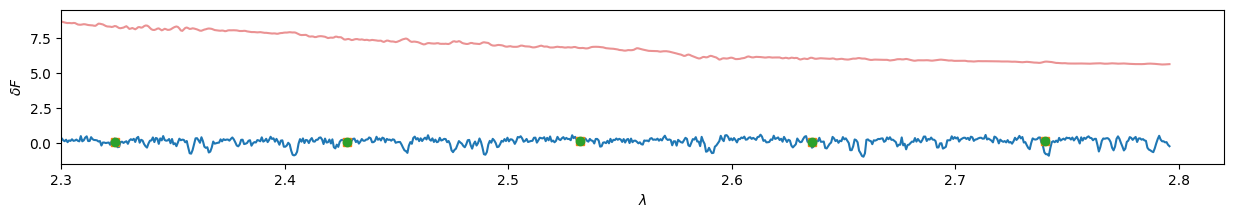

In [14]:
# let's plot the flux, binned flux for old and new cases:
pl.figure(figsize=[15,2])
pl.plot(objred3, delta3[0,:])
pl.plot(zz, deltaFbin3,'s')
pl.plot(zz, deltaFbin3_old,'o')
pl.plot(objred3, weights3[0,:],alpha=0.5)
pl.xlabel("$\\lambda$")
pl.ylabel("$\\delta F$")
pl.xlim([2.3,2.82])

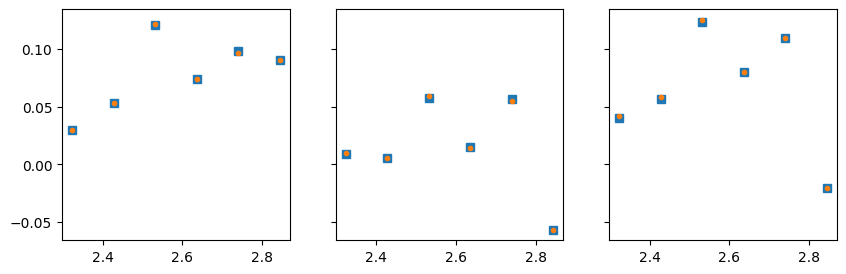

In [17]:
fig,axarr=pl.subplots(1,3,figsize=[10,3],sharey=True)
pl.sca(axarr[0])
pl.plot(zz[3:-1], deltaFbin1[3:-1],'s')
pl.plot(zz[3:-1], deltaFbin1_old[3:-1],'.')

pl.sca(axarr[1])
pl.plot(zz[3:-1], deltaFbin2[3:-1],'s')
pl.plot(zz[3:-1], deltaFbin2_old[3:-1],'.')

pl.sca(axarr[2])
pl.plot(zz[3:-1], deltaFbin3[3:-1],'s')
pl.plot(zz[3:-1], deltaFbin3_old[3:-1],'.')

/global/cfs/cdirs/desi/users/wmturner/photo-z/deltas/mock-0/noSNRcut/Delta/


(2.3, 2.82)

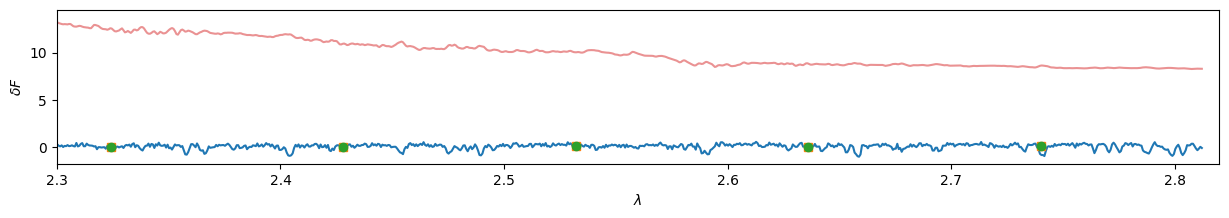

In [17]:
# let's also load the LyCAN mock:

root = "/global/cfs/cdirs/desi/users/wmturner/photo-z/deltas/mock-0/"
simroot = root + "noSNRcut/Delta/"
print(simroot)

pix = hp.ring2nest(16,1334)
fin = fits.open(simroot  + f"delta-{pix}.fits")
hduh = fin[1].header
zqso4 = hduh['Z']

wave4 = fin[1].data['LAMBDA']
delta4 = fin[1].data['DELTA']
weights4 = fin[1].data['WEIGHT']
objred4 = (wave4-emit)/emit

deltaFbin4 = weighted_lyaf(wave4, delta4, weights4, zqso4, zbin_edges, old=False)
deltaFbin4_old = weighted_lyaf(wave4, delta4, weights4, zqso4, zbin_edges, old=True)

# let's plot the flux, binned flux for old and new cases:
pl.figure(figsize=[15,2])
pl.plot(objred4, delta4)
pl.plot(zz, deltaFbin4,'s')
pl.plot(zz, deltaFbin4_old,'o')
pl.plot(objred4, weights4,alpha=0.5)
pl.xlabel("$\\lambda$")
pl.ylabel("$\\delta F$")
pl.xlim([2.3,2.82])

/global/cfs/cdirs/desi/users/wmturner/photo-z/deltas/mock-0/SNRcut/Delta/
2.84592032432556 2.16740300051663 0.160723070077313


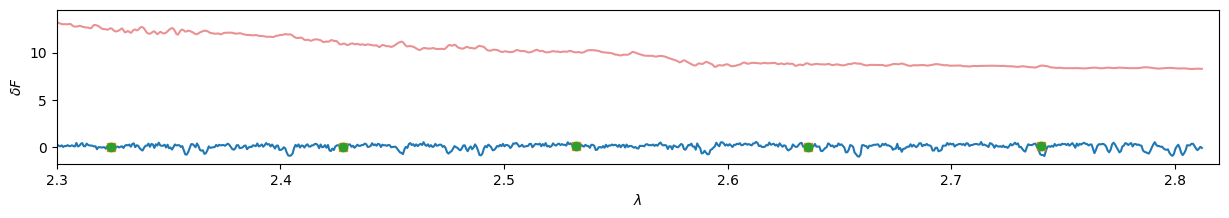

In [19]:
# let's also load the LyCAN mock:

root = "/global/cfs/cdirs/desi/users/wmturner/photo-z/deltas/mock-0/"
simroot = root + "SNRcut/Delta/"
print(simroot)

pix = hp.ring2nest(16,1334)
fin = fits.open(simroot  + f"delta-{pix}.fits")
hduh = fin[1].header
zqso5 = hduh['Z']
ra5 = hduh['RA']
dec5 = hduh['DEC']

wave5 = fin[1].data['LAMBDA']
delta5 = fin[1].data['DELTA']
weights5 = fin[1].data['WEIGHT']
objred5 = (wave4-emit)/emit

deltaFbin5 = weighted_lyaf(wave5, delta5, weights5, zqso5, zbin_edges, old=False)
deltaFbin5_old = weighted_lyaf(wave5, delta5, weights5, zqso5, zbin_edges, old=True)

# let's plot the flux, binned flux for old and new cases:
pl.figure(figsize=[15,2])
pl.plot(objred5, delta5)
pl.plot(zz, deltaFbin5,'s')
pl.plot(zz, deltaFbin5_old,'o')
pl.plot(objred5, weights5,alpha=0.5)
pl.xlabel("$\\lambda$")
pl.ylabel("$\\delta F$")
pl.xlim([2.3,2.82])

print(zqso5, ra5, dec5)

In [20]:
# compute wavelength limits:
lambda_rf_min=1040
lambda_rf_max=1200
lambda_obs_min=lambda_rf_min*(1+zqso)
lambda_obs_max=lambda_rf_max*(1+zqso)
lambda_obs_additional = 3600

emit = 1215.67
objred = (wave-emit)/emit
print(lambda_obs_min,lambda_obs_max, lambda_obs_additional)

3997.567443847661 4612.577819824224 3600


In [21]:
def lambda_to_z(x):
    emit = 1215.67
    return  (x-emit)/emit

def z_to_lambda(y):
    emit = 1215.67
    return y*emit + emit

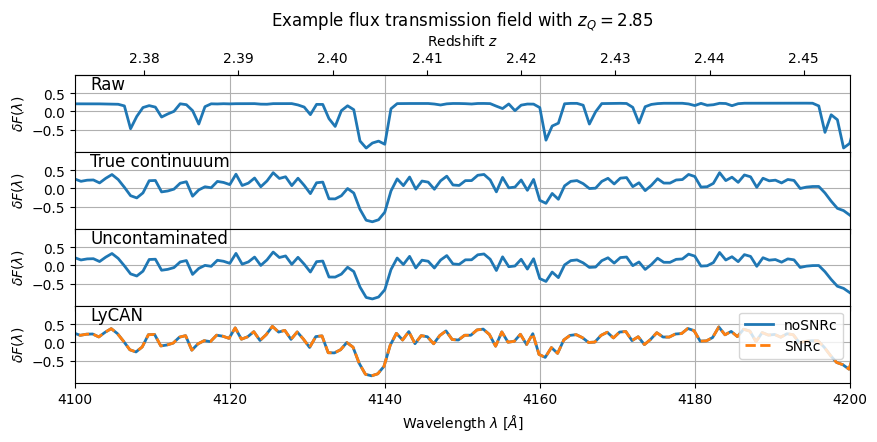

In [22]:
fig,axarr = pl.subplots(4, figsize=[10,4],sharex=True, sharey=True)
for ii in range(4):
    pl.sca(axarr[ii])
    pl.grid()
    pl.ylabel("$\\delta F(\\lambda)$")

pl.sca(axarr[0])
pl.plot(wave, delta1, lw=2)
pl.text(4102, 0.6, "Raw", size=12)
pl.title("Example flux transmission field with $z_Q = 2.85$")
pl.xlim([4100,4200])

secax = axarr[0].secondary_xaxis('top', functions=(lambda_to_z, z_to_lambda))
secax.set_xlabel('Redshift $z$')

pl.sca(axarr[1])
pl.plot(wave3, delta3[0,:], lw=2)
pl.text(4102, 0.6, "True continuuum", size=12)

pl.sca(axarr[2])
pl.plot(wave2, delta2[0,:], lw=2)
pl.xlim([4100,4200])
pl.xlabel("Wavelength $\\lambda$ [$\\AA$]")
pl.text(4102, 0.6, "Uncontaminated", size=12)
pl.ylim([-1.1, 1.0])
pl.yticks([-0.5,0,0.5])

pl.sca(axarr[3])
pl.plot(wave4, delta4, lw=2, label="noSNRc")
pl.plot(wave5, delta5, lw=2, label="SNRc", ls='--')
pl.xlim([4100,4200])
pl.xlabel("Wavelength $\\lambda$ [$\\AA$]")
pl.text(4102, 0.6, "LyCAN", size=12)
pl.ylim([-1.1, 1.0])
pl.yticks([-0.5,0,0.5])
pl.legend()
    
pl.subplots_adjust(hspace=0)
#pl.savefig("../plots/delta_f_example.pdf",bbox_inches="tight")

Show full wavelength range and zoom in box

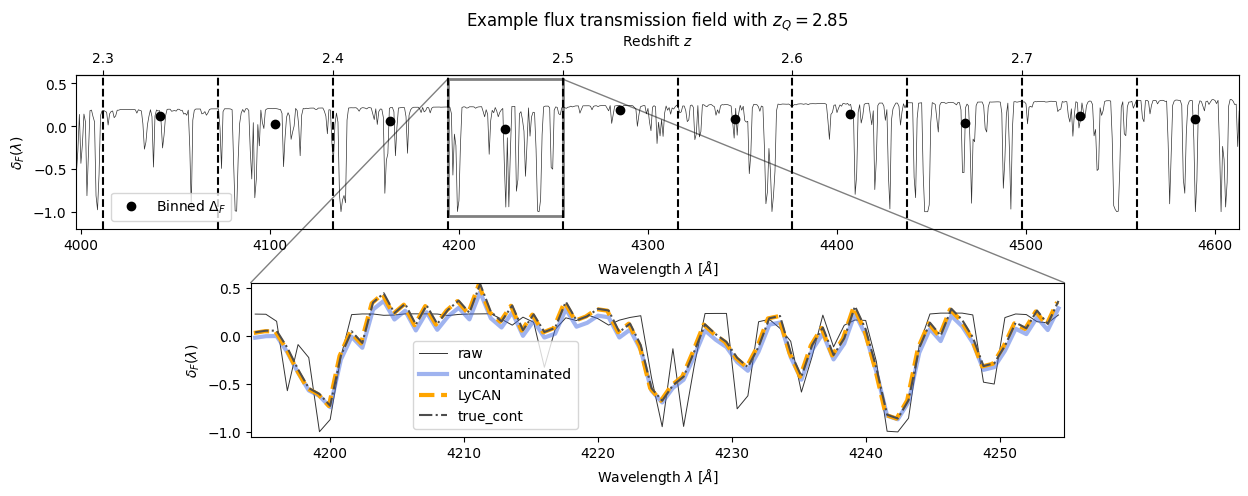

In [181]:
fig, ax = pl.subplots(figsize=[15,2])

# define colour map:
#colors=pl.cm.inferno(np.linspace(0,1,20))
#colors=colors[-len(ind):]

pl.plot(wave, delta1, color='0.2',lw=0.5)
ind = np.where(deltaFbin1!=-10)[0]
# convert redshifts to wavelengths:
emit = 1215.67
wave_bin = emit*(1+zz)
wave_bin=wave_bin[ind]
deltaFbin1_use = deltaFbin1[ind]

#print(ind[0], ind[-1])
edge_min = emit*(1+zbin_edges[:-1][ind])
edge_max = emit*(1+zbin_edges[1:][ind])

lambda_rf_min=1040
lambda_rf_max=1200
lambda_obs_min=lambda_rf_min*(1+zqso)
lambda_obs_max=lambda_rf_max*(1+zqso)
pl.xlim([lambda_obs_min, lambda_obs_max])

pl.plot(wave_bin, deltaFbin1_use, 'o', color='k',label="Binned $\\Delta_F$")
pl.legend(loc=(0.03,0.05))
#for i in range(len(wave_bin)):
    #pl.plot([edge_min[i], edge_max[i]], [deltaFbin1_use[i],deltaFbin1_use[i]], '-', color=colors[i], lw=2)

# plot bin edges:
for i in range(len(wave_bin)):
    #ax.axvspan(edge_min[i], edge_max[i], color=colors[i],alpha=0.2)
    ax.axvline(edge_min[i], color='k', ls='--')

pl.ylim([-1.2, 0.6])
pl.ylabel("$\\delta_F(\\lambda)$")
pl.title("Example flux transmission field with $z_Q = 2.85$")
pl.xlabel("Wavelength $\\lambda$ [$\\AA$]")

secax = ax.secondary_xaxis('top', functions=(lambda_to_z, z_to_lambda))
secax.set_xlabel('Redshift $z$')

# zoom in:
# inset Axes....
x1, x2, y1, y2 = edge_min[4], edge_max[4], -1.05, 0.55  # subregion of the original image
axins = ax.inset_axes(
    [0.15, -1.35, 0.7, 1],
    xlim=(x1, x2), ylim=(y1, y2), xticks=np.linspace(4200,4250,6), yticks=[-1,-0.5,0,0.5])

# raw
indd = (wave>edge_min[4])&(wave<edge_max[4])
axins.plot(wave[indd], delta1[indd], color='0.2', label='raw', lw=0.7)

indd = (wave2>edge_min[4])&(wave2<edge_max[4])
axins.plot(wave2[indd], delta2[0,indd], color='royalblue',ls='-', lw=3, alpha=0.5, label="uncontaminated")

indd = (wave4>edge_min[4])&(wave4<edge_max[4])
axins.plot(wave4[indd], delta4[indd], color='orange', ls='--', lw=3, alpha=1, label="LyCAN")

indd = (wave3>edge_min[4])&(wave3<edge_max[4])
axins.plot(wave3[indd], delta3[0,indd], color='0.3', ls='-.',label="true_cont")

axins.legend(loc=(0.2,0.05))
axins.set_xlabel("Wavelength $\\lambda$ [$\\AA$]")
axins.set_ylabel("$\\delta_F(\\lambda)$")

ax.indicate_inset_zoom(axins, edgecolor="black", lw=2)
pl.savefig("../plots/delta_f_example2.pdf",bbox_inches="tight")

In [182]:
print(lambda_obs_min, lambda_obs_max)

3997.567443847661 4612.577819824224


# 2. Delta F on a cut-out

In [62]:
# load delta f catalogue 
fname = "/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue-20bin/delta-raw.fits"
fin = fits.open(fname)
#fin[1].header

# select a redshift bin:
#zbinfile = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/delta_F/zbins.txt")
#nbin = 5
#zbinedges = zbinfile[5:7,0]
#print(zbinedges)
zbin_edges = np.linspace(2.00, 3.00, 21)
# select the middle bin
zz = (zbin_edges[1:] + zbin_edges[:-1])/2.
usezbin = 9

# get ra, dec, delta f
ind = (fin[1].data['Z']>zbin_edges[usezbin])&(fin[1].data['Z']<zbin_edges[usezbin+1])
ra = fin[1].data['RA'][ind]
dec = fin[1].data['DEC'][ind]
delta = fin[1].data['DELTA_F'][ind]
w = fin[1].data['NPIX'][ind]

ind2 = (ra>150) & (ra<160) & (dec> 5) & (dec<10)

In [63]:
# select a redshift bin:
fname = "/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue-20bin/delta-true_cont.fits"
fin = fits.open(fname)

# get ra, dec, delta f
ind = (fin[1].data['Z']>zbin_edges[usezbin])&(fin[1].data['Z']<zbin_edges[usezbin+1])
ra3 = fin[1].data['RA'][ind]
dec3 = fin[1].data['DEC'][ind]
delta3 = fin[1].data['DELTA_F_WEIGHTED'][ind]
w3 = fin[1].data['TOTWEIGHTS'][ind]

ind23 = (ra3>150) & (ra3<160) & (dec3> 5) & (dec3<10)

In [64]:
# select a redshift bin:
fname = "/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue-20bin/delta-uncontaminated.fits"
fin = fits.open(fname)

# get ra, dec, delta f
ind = (fin[1].data['Z']>zbin_edges[usezbin])&(fin[1].data['Z']<zbin_edges[usezbin+1])
ra2 = fin[1].data['RA'][ind]
dec2 = fin[1].data['DEC'][ind]
delta2 = fin[1].data['DELTA_F_WEIGHTED'][ind]
w2 = fin[1].data['TOTWEIGHTS'][ind]

ind22 = (ra2>150) & (ra2<160) & (dec2> 5) & (dec2<10)

In [65]:
# select a redshift bin:
fname = "/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue-20bin/delta-LyCAN_noSNRcut.fits"
fin = fits.open(fname)

# get ra, dec, delta f
ind = (fin[1].data['Z']>zbin_edges[usezbin])&(fin[1].data['Z']<zbin_edges[usezbin+1])
ra4 = fin[1].data['RA'][ind]
dec4 = fin[1].data['DEC'][ind]
delta4 = fin[1].data['DELTA_F_WEIGHTED'][ind]
w4 = fin[1].data['TOTWEIGHTS'][ind]

ind24 = (ra4>150) & (ra4<160) & (dec4> 5) & (dec4<10)

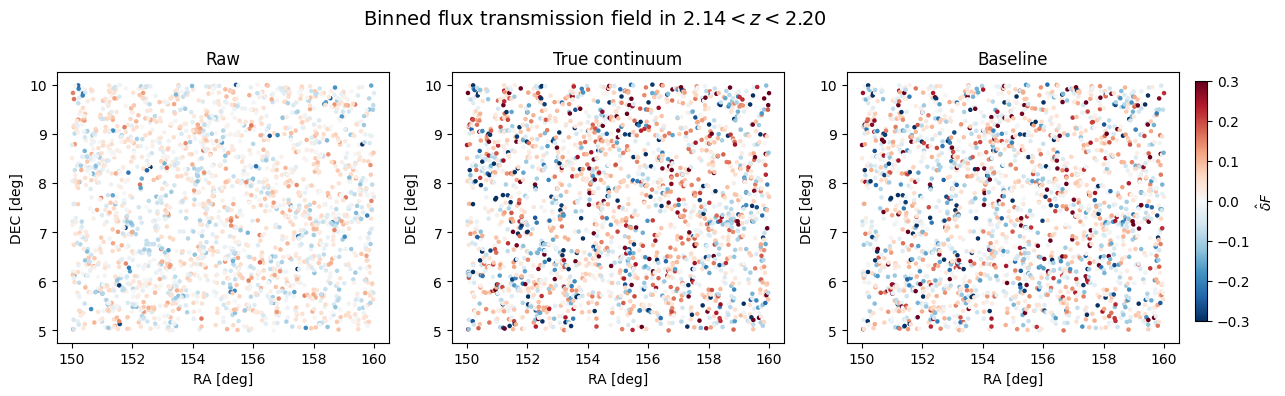

In [165]:
fig,axarr=pl.subplots(1,3,figsize=[12,4])

fig.suptitle("Binned flux transmission field in $2.14<z<2.20$", fontsize=14)

pl.sca(axarr[0])
pl.scatter(ra[ind2], dec[ind2], c=delta[ind2], s=5, 
           vmax=0.3,vmin=-0.3,cmap='RdBu_r')
pl.xlabel("RA [deg]")
pl.ylabel("DEC [deg]")
pl.title("Raw")
#pl.colorbar()

pl.sca(axarr[1])
pl.scatter(ra3[ind23], dec3[ind23], c=delta3[ind23], s=5, 
           vmax=0.3,vmin=-0.3,cmap='RdBu_r')
pl.xlabel("RA [deg]")
pl.ylabel("DEC [deg]")
pl.title("True continuum")
#pl.colorbar()

pl.sca(axarr[2])
im = pl.scatter(ra2[ind22], dec2[ind22], c=delta2[ind22], s=5, 
           vmax=0.3,vmin=-0.3,cmap='RdBu_r')
pl.xlabel("RA [deg]")
pl.ylabel("DEC [deg]")
pl.title("Baseline")

pl.tight_layout()

cb_ax = fig.add_axes([1, 0.2, 0.01, 0.6])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('$\\hat{\\delta} F$')
pl.savefig("../plots/delta_f_catalog_example.pdf",bbox_inches="tight")

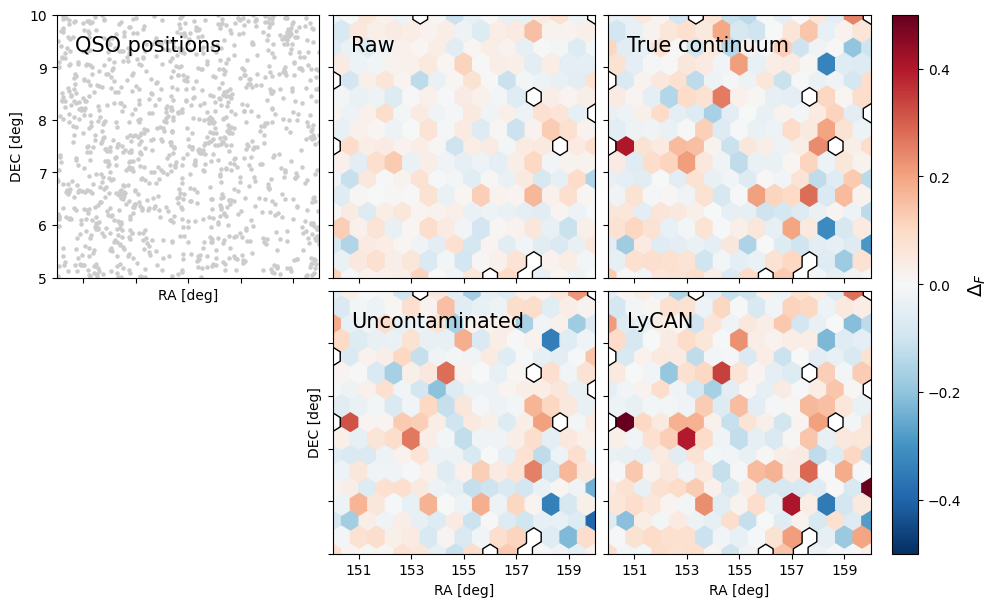

In [71]:
fig,axarr=pl.subplots(2,3,figsize=[10.5,7],sharex=True,sharey=True)

#fig.suptitle(f"Binned flux transmission field in ${zbin_edges[usezbin]}<z<{zbin_edges[usezbin+1]}$", fontsize=14)
axarr[1,0].axis("off")

pl.sca(axarr[0,0])
pl.ylabel("DEC [deg]")
pl.xlabel("RA [deg]")
pl.scatter(ra[ind2], dec[ind2], s=5, color='0.8')
pl.text(150.7,9.3,"QSO positions",fontsize=15)

pl.sca(axarr[0,1])
pl.hexbin(ra[ind2], dec[ind2], gridsize=15, mincnt=1, lw=3, ec='k')
im = pl.hexbin(ra[ind2], dec[ind2], C=delta[ind2],  gridsize=15, cmap='RdBu_r', vmax=0.5,vmin=-0.5)
#pl.xlabel("RA [deg]")
pl.text(150.7,9.3,"Raw",fontsize=15)
pl.xlim([150,160])
pl.ylim([5,10])
#axarr[0,0].axis('off')
#pl.colorbar()

pl.sca(axarr[0,2])
pl.hexbin(ra3[ind23], dec3[ind23], gridsize=15, mincnt=1, lw=3, ec='k')
pl.hexbin(ra3[ind23], dec3[ind23], C=delta3[ind23],  gridsize=15, cmap='RdBu_r', vmax=0.5,vmin=-0.5)
#pl.xlabel("RA [deg]")
#pl.ylabel("DEC [deg]")
pl.text(150.7,9.3,"True continuum",fontsize=15)
#pl.colorbar()

pl.sca(axarr[1,1])
pl.hexbin(ra2[ind22], dec2[ind22], gridsize=15, mincnt=1, lw=3, ec='k')
pl.hexbin(ra2[ind22], dec2[ind22], C=delta2[ind22],  gridsize=15, cmap='RdBu_r', vmax=0.5,vmin=-0.5)
pl.xlabel("RA [deg]")
pl.ylabel("DEC [deg]")
pl.text(150.7,9.3,"Uncontaminated",fontsize=15)

pl.sca(axarr[1,2])
pl.hexbin(ra4[ind24], dec4[ind24], gridsize=15, mincnt=1, lw=3, ec='k')
pl.hexbin(ra4[ind24], dec4[ind24], C=delta4[ind24],  gridsize=15, cmap='RdBu_r', vmax=0.5,vmin=-0.5)
pl.xlabel("RA [deg]")
#pl.ylabel("DEC [deg]")
pl.text(150.7,9.3,"LyCAN",fontsize=15)
pl.xticks([151, 153, 155, 157, 159])

#pl.tight_layout()
pl.subplots_adjust(hspace=0.05, wspace=0.05)

cb_ax = fig.add_axes([0.92, 0.11, 0.025, 0.77])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('$\\Delta_F$', fontsize=14)
pl.savefig("../plots/delta_f_catalog_example2.pdf",bbox_inches="tight")

Plot the same plot on a thicker slice

In [18]:
# load delta f catalogue 
fname = "/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue-20bin/delta-raw.fits"
fin = fits.open(fname)
#fin[1].header

# select a redshift bin:
#zbinfile = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/delta_F/zbins.txt")
#nbin = 5
#zbinedges = zbinfile[5:7,0]
#print(zbinedges)
zbin_edges = np.linspace(2.00, 3.00, 21)
# select the middle bin
zz = (zbin_edges[1:] + zbin_edges[:-1])/2.
usezbin = 7
nzbin = 5

# get ra, dec, delta f
ind = (fin[1].data['Z']>zbin_edges[usezbin])&(fin[1].data['Z']<zbin_edges[usezbin+nzbin])
ra = fin[1].data['RA'][ind]
dec = fin[1].data['DEC'][ind]
delta = fin[1].data['DELTA_F'][ind]
w = fin[1].data['NPIX'][ind]

ind2 = (ra>150) & (ra<160) & (dec> 5) & (dec<10)

In [19]:
# select a redshift bin:
fname = "/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue-20bin/delta-true_cont.fits"
fin = fits.open(fname)

# get ra, dec, delta f
ind = (fin[1].data['Z']>zbin_edges[usezbin])&(fin[1].data['Z']<zbin_edges[usezbin+nzbin])
ra3 = fin[1].data['RA'][ind]
dec3 = fin[1].data['DEC'][ind]
delta3 = fin[1].data['DELTA_F_WEIGHTED'][ind]
w3 = fin[1].data['TOTWEIGHTS'][ind]

ind23 = (ra3>150) & (ra3<160) & (dec3> 5) & (dec3<10)

In [20]:
# select a redshift bin:
fname = "/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue-20bin/delta-uncontaminated.fits"
fin = fits.open(fname)

# get ra, dec, delta f
ind = (fin[1].data['Z']>zbin_edges[usezbin])&(fin[1].data['Z']<zbin_edges[usezbin+nzbin])
ra2 = fin[1].data['RA'][ind]
dec2 = fin[1].data['DEC'][ind]
delta2 = fin[1].data['DELTA_F_WEIGHTED'][ind]
w2 = fin[1].data['TOTWEIGHTS'][ind]

ind22 = (ra2>150) & (ra2<160) & (dec2> 5) & (dec2<10)

In [21]:
# select a redshift bin:
fname = "/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue-20bin/delta-LyCAN_noSNRcut.fits"
fin = fits.open(fname)

# get ra, dec, delta f
ind = (fin[1].data['Z']>zbin_edges[usezbin])&(fin[1].data['Z']<zbin_edges[usezbin+nzbin])
ra4 = fin[1].data['RA'][ind]
dec4 = fin[1].data['DEC'][ind]
delta4 = fin[1].data['DELTA_F_WEIGHTED'][ind]
w4 = fin[1].data['TOTWEIGHTS'][ind]

ind24 = (ra4>150) & (ra4<160) & (dec4> 5) & (dec4<10)

In [24]:
print(zbin_edges[usezbin], zbin_edges[usezbin+nzbin])

2.35 2.6


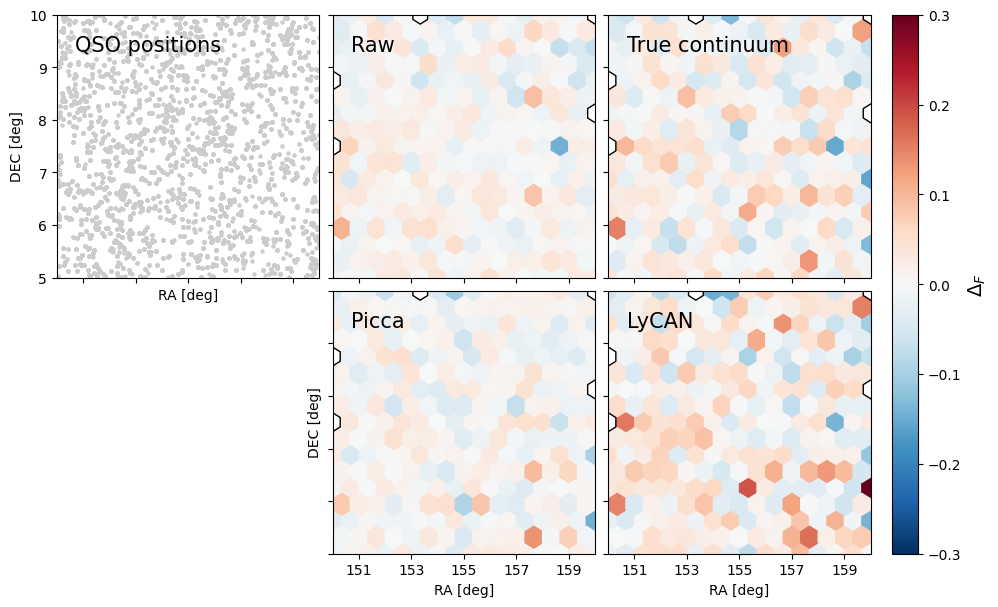

In [23]:
fig,axarr=pl.subplots(2,3,figsize=[10.5,7],sharex=True,sharey=True)

#fig.suptitle(f"Binned flux transmission field in ${zbin_edges[usezbin]}<z<{zbin_edges[usezbin+1]}$", fontsize=14)
axarr[1,0].axis("off")

pl.sca(axarr[0,0])
pl.ylabel("DEC [deg]")
pl.xlabel("RA [deg]")
pl.scatter(ra[ind2], dec[ind2], s=5, color='0.8')
pl.text(150.7,9.3,"QSO positions",fontsize=15)

pl.sca(axarr[0,1])
pl.hexbin(ra[ind2], dec[ind2], gridsize=15, mincnt=1, lw=3, ec='k')
im = pl.hexbin(ra[ind2], dec[ind2], C=delta[ind2],  gridsize=15, cmap='RdBu_r', vmax=0.3,vmin=-0.3)
#pl.xlabel("RA [deg]")
pl.text(150.7,9.3,"Raw",fontsize=15)
pl.xlim([150,160])
pl.ylim([5,10])
#axarr[0,0].axis('off')
#pl.colorbar()

pl.sca(axarr[0,2])
pl.hexbin(ra3[ind23], dec3[ind23], gridsize=15, mincnt=1, lw=3, ec='k')
pl.hexbin(ra3[ind23], dec3[ind23], C=delta3[ind23],  gridsize=15, cmap='RdBu_r', vmax=0.3,vmin=-0.3)
#pl.xlabel("RA [deg]")
#pl.ylabel("DEC [deg]")
pl.text(150.7,9.3,"True continuum",fontsize=15)
#pl.colorbar()

pl.sca(axarr[1,1])
pl.hexbin(ra2[ind22], dec2[ind22], gridsize=15, mincnt=1, lw=3, ec='k')
pl.hexbin(ra2[ind22], dec2[ind22], C=delta2[ind22],  gridsize=15, cmap='RdBu_r', vmax=0.3,vmin=-0.3)
pl.xlabel("RA [deg]")
pl.ylabel("DEC [deg]")
pl.text(150.7,9.3,"Picca",fontsize=15)

pl.sca(axarr[1,2])
pl.hexbin(ra4[ind24], dec4[ind24], gridsize=15, mincnt=1, lw=3, ec='k')
pl.hexbin(ra4[ind24], dec4[ind24], C=delta4[ind24],  gridsize=15, cmap='RdBu_r', vmax=0.3,vmin=-0.3)
pl.xlabel("RA [deg]")
#pl.ylabel("DEC [deg]")
pl.text(150.7,9.3,"LyCAN",fontsize=15)
pl.xticks([151, 153, 155, 157, 159])

#pl.tight_layout()
pl.subplots_adjust(hspace=0.05, wspace=0.05)

cb_ax = fig.add_axes([0.92, 0.11, 0.025, 0.77])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('$\\Delta_F$', fontsize=14)
#pl.savefig("../plots/delta_f_catalog_example2.pdf",bbox_inches="tight")

Plot a smoothed version in healpix

In [69]:
#fig,axarr=pl.subplots(2,2,figsize=[10,7])

#fig.suptitle("Binned flux transmission field in $2.14<z<2.20$", fontsize=14)

#cc = np.histogram2d(ra[ind2], dec[ind2], weights=delta[ind2], bins=[20,20])
#cc1 = np.histogram2d(ra[ind2], dec[ind2], bins=[20,20])

# make healpix maps:
nside=128
pix = hp.ang2pix(nside,ra,dec,lonlat=True)
c1 = np.bincount(pix, weights=w, minlength=int(12*nside**2))
c2 = np.bincount(pix, weights=delta*w, minlength=int(12*nside**2))

ccuse = c2/c1
ind = np.isnan(ccuse)
ccuse[ind]=0
mask = np.ones(len(ccuse))
mask[ind]=0

# appy some smoothing:
#smoothed_ccuse=np.copy(ccuse)
smoothed_ccuse = hp.smoothing(ccuse, fwhm=0.5/180*np.pi)*mask
smoothed_ccuse[mask==0] = hp.UNSEEN

/tmp/ipykernel_1568902/2756059061.py:14: RuntimeWarning: invalid value encountered in divide
  ccuse = c2/c1


In [70]:
#fig,axarr=pl.subplots(2,2,figsize=[10,7])

#fig.suptitle("Binned flux transmission field in $2.14<z<2.20$", fontsize=14)

#cc = np.histogram2d(ra[ind2], dec[ind2], weights=delta[ind2], bins=[20,20])
#cc1 = np.histogram2d(ra[ind2], dec[ind2], bins=[20,20])

# make healpix maps:
nside=128
pix = hp.ang2pix(nside,ra3,dec3,lonlat=True)
c1 = np.bincount(pix, weights=w3, minlength=int(12*nside**2))
c2 = np.bincount(pix, weights=delta3*w3, minlength=int(12*nside**2))

ccuse = c2/c1
ind = np.isnan(ccuse)
ccuse[ind]=0
mask = np.ones(len(ccuse))
mask[ind]=0

# appy some smoothing:
#smoothed_ccuse3=np.copy(ccuse)
smoothed_ccuse3 = hp.smoothing(ccuse, fwhm=0.5/180*np.pi)*mask
smoothed_ccuse3[mask==0] = hp.UNSEEN

/tmp/ipykernel_1568902/1796301047.py:14: RuntimeWarning: invalid value encountered in divide
  ccuse = c2/c1


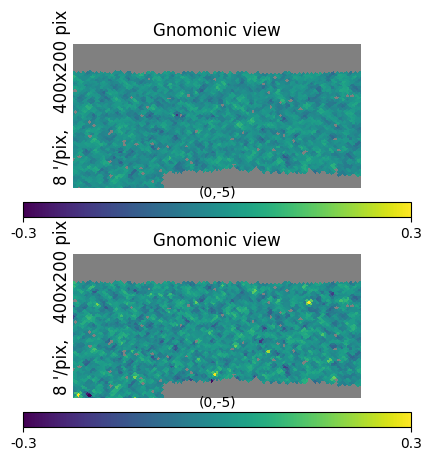

In [72]:
fig,axarr=pl.subplots(2,figsize=[10,5])
pl.sca(axarr[0])
hp.gnomview(smoothed_ccuse, rot=(0,-5,0), reso=8, max=0.3, min=-0.3, xsize=400, ysize=200, hold=True)

pl.sca(axarr[1])
hp.gnomview(smoothed_ccuse3, rot=(0,-5,0), reso=8, max=0.3, min=-0.3, xsize=400, ysize=200, hold=True)

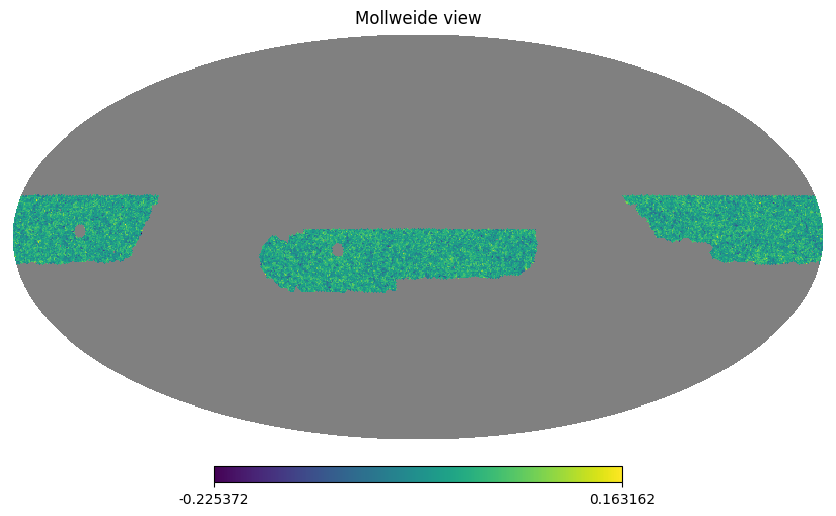

In [25]:
hp.mollview(ccuse)

# 3. YAW results: mock 0 with different settings
Here we test cases:
- raw (weight = npix)
- true_cont (weight = tot pix weight)
- uncontaminated (weight = tot pix weight)
- LyCAN no SNR cut (weight = tot pix weight)
- LyCAN SNR cut (weight = tot pix weight) * only Mock 0

For each case, we use three sets of angular scales:
- [5,15] arcmin
- [10,30] arcmin
- [15,50] arcmin

We use two binning:
- 40 redshift bins between $2<z<3$, with a bin width of $\Delta z = 0.025$;
- 20 bins between $2<z<3$, with a bin width of  $\Delta z = 0.05$.

The photometric sample has the following setup:
- Full photometric catalog with z>1.8 (ngal > SRD 10 year source)
- Gaussian centred at z=2.0, with cut at z>1.8 (low)
- Gaussian centred at z=2.5, with cut at z>1.8 (mid)
- SRD full sample with ngal = 5.4 / arcmin^2

In [2]:
from yaw.correlation.corrfunc import ScalarCorrFunc

In [3]:
root = "/pscratch/sd/q/qhang/desi-lya/results/"

In [4]:
theta_min=[5,10,15]
theta_max=[15,30,50]
sim_num = 0
saveroot = root + f"run-{sim_num}/"

### phot z>1.8, 40 bins: 

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


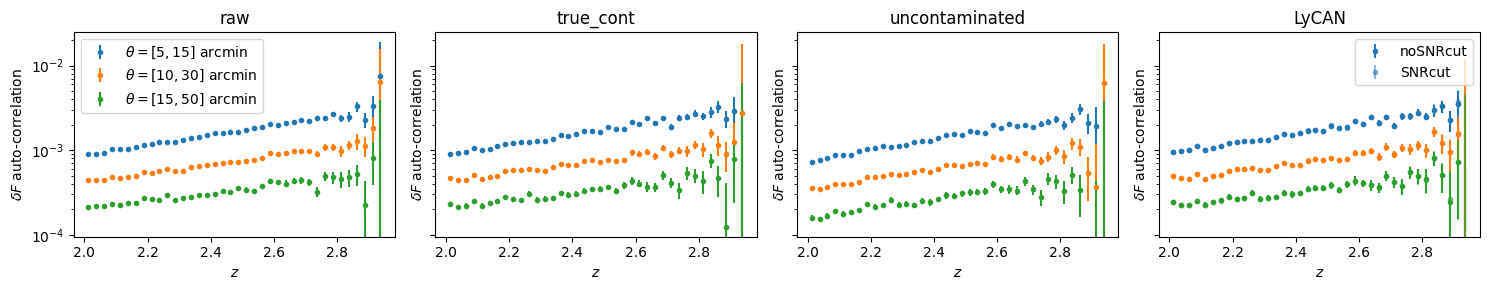

In [46]:
fig,axarr=pl.subplots(1,4,figsize=[15,3],sharey=True)

for ss, sim_mode_tag in enumerate(["raw","true_cont","uncontaminated"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        cts_ss = ScalarCorrFunc.from_file(saveroot + f"yaw/w_ss-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        cts_ss.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
        pl.xlabel("$z$")
        pl.ylabel("$\\delta F$ auto-correlation")
        pl.yscale('log')
        if ss == 0:
            pl.legend()
        pl.title(sim_mode_tag)

# plot LyCAN case:
pl.sca(axarr[3])
for ss, sim_mode_tag in enumerate(["LyCAN_noSNRcut","LyCAN_SNRcut"]):
    if ss==0:
        alpha=1
    elif ss==1:
        alpha=0.5
    for ii in range(len(theta_min)):
        if ii == 0:
            label=sim_mode_tag[6:]
        else:
            label=""
        cts_ss = ScalarCorrFunc.from_file(saveroot + f"yaw/w_ss-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        x = cts_ss.binning.mids
        y = cts_ss.sample().data
        dy = cts_ss.sample().error
        pl.errorbar(x,y,yerr=dy,color=f'C{ii}',alpha=alpha, fmt='.',label=label)
pl.xlabel("$z$")
pl.ylabel("$\\delta F$ auto-correlation")
pl.yscale('log')
pl.title("LyCAN")
pl.legend()

pl.tight_layout()
#pl.savefig("lya-auto-mock-0.pdf", bbox_inches="tight")

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


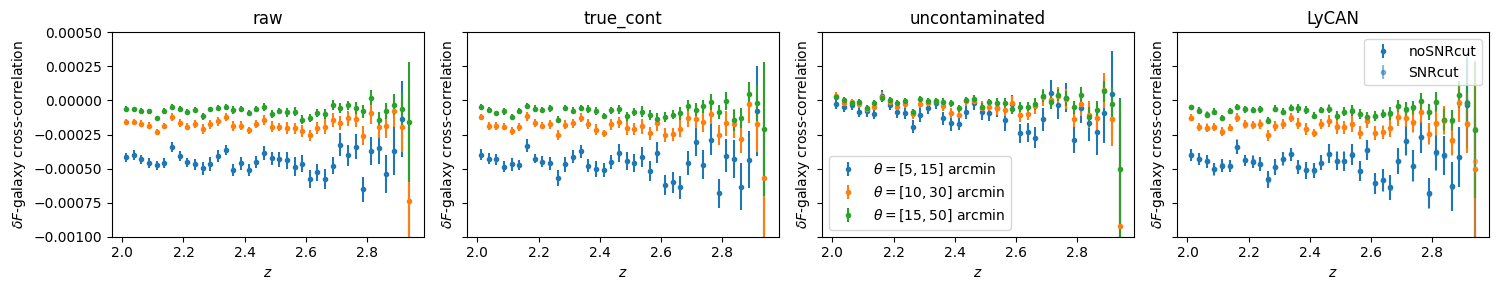

In [47]:
fig,axarr=pl.subplots(1,4,figsize=[15,3],sharey=True)

for ss, sim_mode_tag in enumerate(["raw","true_cont","uncontaminated"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        cts_sp.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
        pl.xlabel("$z$")
        pl.ylabel("$\\delta F$-galaxy cross-correlation")
        if ss == 2:
            pl.legend()
        pl.title(sim_mode_tag)

# plot LyCAN case:
pl.sca(axarr[3])
for ss, sim_mode_tag in enumerate(["LyCAN_noSNRcut","LyCAN_SNRcut"]):
    if ss==0:
        alpha=1
    elif ss==1:
        alpha=0.5
    for ii in range(len(theta_min)):
        if ii == 0:
            label=sim_mode_tag[6:]
        else:
            label=""
        cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        x = cts_sp.binning.mids
        y = cts_sp.sample().data
        dy = cts_sp.sample().error
        pl.errorbar(x,y,yerr=dy,color=f'C{ii}',alpha=alpha, fmt='.',label=label)
pl.xlabel("$z$")
pl.ylabel("$\\delta F$-galaxy cross-correlation")
pl.title("LyCAN")
pl.legend()
pl.ylim([-0.001,0.0005])

pl.tight_layout()
pl.savefig("lya-cross-mock-0.pdf", bbox_inches="tight")

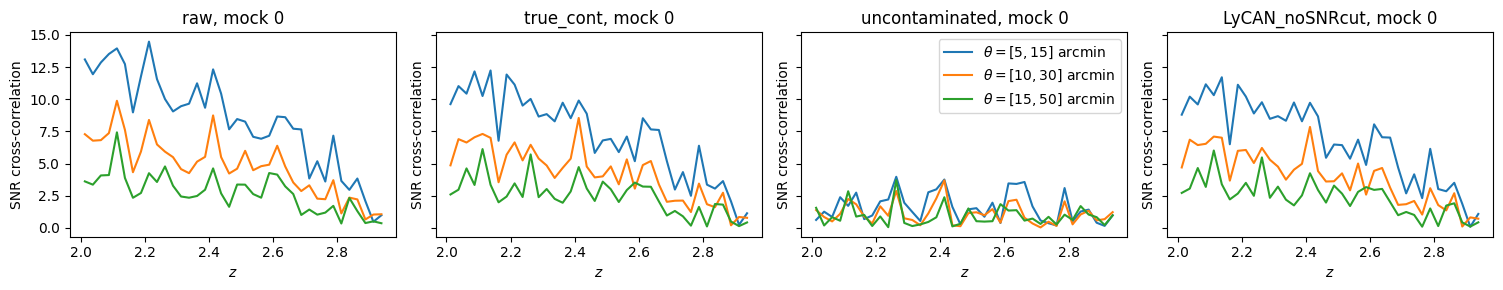

In [147]:
# signal-to-noise:
fig,axarr=pl.subplots(1,4,figsize=[15,3],sharey=True)

for ss, sim_mode_tag in enumerate(["raw","true_cont","uncontaminated","LyCAN_noSNRcut"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        data = abs(cts_sp.sample().data)
        error = cts_sp.sample().error
        zz = cts_sp.binning.mids
        pl.plot(zz, data/error,label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
        if ss == 2:
            pl.legend()
        pl.xlabel("$z$")
        pl.ylabel("SNR cross-correlation")
        pl.title(sim_mode_tag + ", mock 0")

pl.tight_layout()

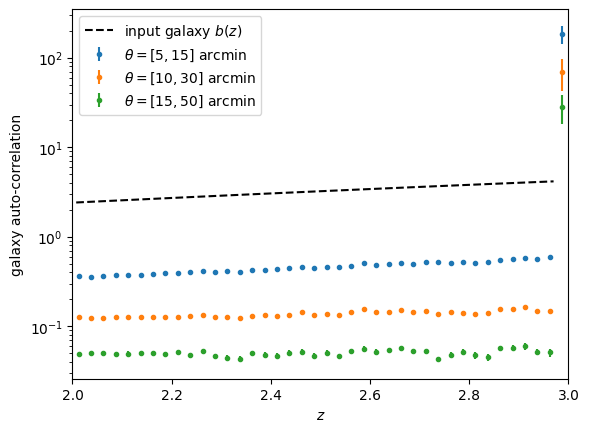

In [48]:
for ii in range(len(theta_min)):
    cts_pp = yaw.CorrFunc.from_file(saveroot + f"yaw/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    cts_pp.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
    pl.xlabel("$z$")
    pl.ylabel("galaxy auto-correlation")
pl.yscale('log')

# load and plot bias evolution curve:
bz = np.loadtxt("../bias_dc2.txt")
pl.plot(bz[:,0],bz[:,1],'--', label="input galaxy $b(z)$",color='k')
pl.xlim([2,3])
pl.legend()
pl.savefig("galaxy-auto-mock-0.pdf", bbox_inches="tight")

In [124]:
# here plot against true n(z):
root = "/pscratch/sd/q/qhang/desi-lya/results/"
#edges = cts_pp.binning.edges
#dz = edges[1]-edges[0]
nz_mean = 0
for ii in range(Nsims):
    if ii%3 == 0:
        print(f"Working on sim {ii}")
    fin = fits.open(root + f"run-{ii}/catalogue/unknown-zmin-1.8-zmax-3.0.fits")
    cc, nz_edges = np.histogram(fin[1].data['Z'], bins=np.linspace(1.7,3.0,53))
    nz_mean += cc
# here normalize
dz = nz_edges[1]-nz_edges[0]
nz_norm = nz_mean/sum(nz_mean)/dz
fname = "/pscratch/sd/q/qhang/desi-lya/nz-gal-true-z1.8-3.0-all-boxes-40bin.txt"
np.savetxt(fname, np.c_[nz_edges, np.append(nz_norm, 0)])

Working on sim 0
Working on sim 3
Working on sim 6
Working on sim 9


In [142]:
fname = "/pscratch/sd/q/qhang/desi-lya/nz-gal-true-z1.8-3.0-all-boxes-40bin.txt"
fin = np.loadtxt(fname)
nz_norm = fin[:-1,1]
nz_edges = fin[:,0]

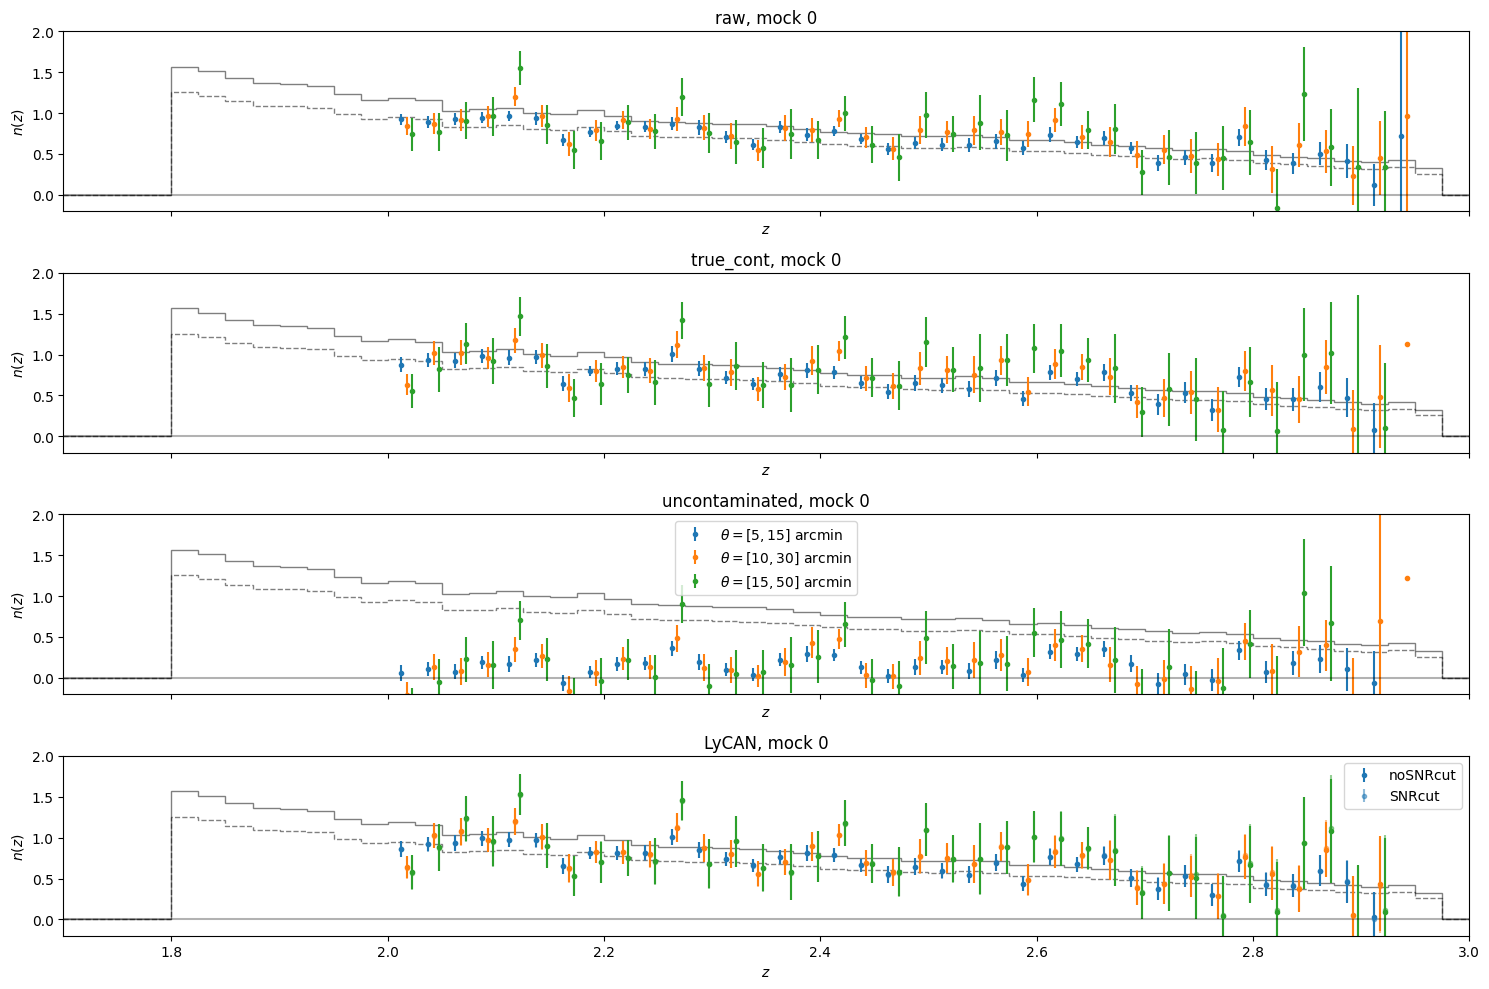

In [144]:
# here plot the recovered redshifts including w_pp:
fig,axarr=pl.subplots(4,figsize=[15,10],sharey=True,sharex=True)

for ss, sim_mode_tag in enumerate(["raw","true_cont","uncontaminated"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        ncc = np.loadtxt(saveroot + f"yaw/nz_estimate-{sim_mode_tag}-wpp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.dat")
        pl.errorbar(ncc[:,0] + ii*0.005, ncc[:,1], yerr=ncc[:,2], label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin",
                   fmt='.')
        pl.xlabel("$z$")
        pl.ylabel("$n(z)$")
        if ss == 2:
            pl.legend()
        pl.title(sim_mode_tag + ", mock 0")
    
    pl.stairs(nz_norm,nz_edges, color='k', alpha=0.5)
    pl.stairs(nz_norm*0.8,nz_edges, color='k', alpha=0.5, ls='--')
    pl.plot([1.7,3],[0,0],'k-', alpha=0.3)

# plot LyCAN case:
pl.sca(axarr[3])
for ss, sim_mode_tag in enumerate(["LyCAN_noSNRcut","LyCAN_SNRcut"]):
    if ss==0:
        alpha=1
    elif ss==1:
        alpha=0.5
    for ii in range(len(theta_min)):
        if ii == 0:
            label=sim_mode_tag[6:]
        else:
            label=""
        ncc = np.loadtxt(saveroot + f"yaw/nz_estimate-{sim_mode_tag}-wpp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.dat")
        pl.errorbar(ncc[:,0] + ii*0.005, ncc[:,1], yerr=ncc[:,2], label=label, alpha=alpha,
                   fmt='.', color=f'C{ii}')
pl.stairs(nz_norm,nz_edges, color='k', alpha=0.5)
pl.stairs(nz_norm*0.8,nz_edges, color='k', alpha=0.5, ls='--')
pl.plot([1.7,3],[0,0],'k-', alpha=0.3)
pl.xlabel("$z$")
pl.ylabel("$n(z)$")
pl.legend()
pl.title("LyCAN" + ", mock 0")

pl.ylim([-0.2,2])
pl.xlim([1.7,3.0])
pl.tight_layout()
#pl.savefig("nz-wsp-wss-wpp-mock-0.pdf", bbox_inches="tight")

### phot z>1.8, 20 bins: 

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


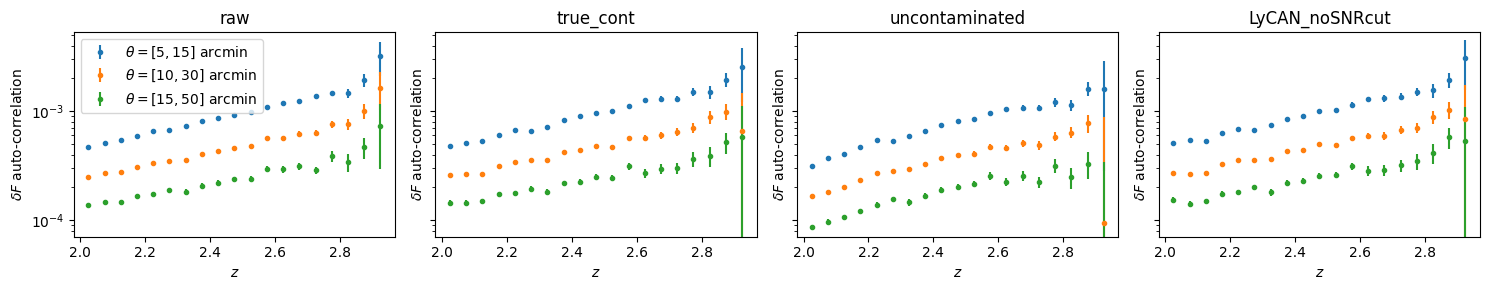

In [26]:
fig,axarr=pl.subplots(1,4,figsize=[15,3],sharey=True)

for ss, sim_mode_tag in enumerate(["raw","true_cont","uncontaminated","LyCAN_noSNRcut"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        cts_ss = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin/w_ss-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        cts_ss.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
        pl.xlabel("$z$")
        pl.ylabel("$\\delta F$ auto-correlation")
        pl.yscale('log')
        if ss == 0:
            pl.legend()
        pl.title(sim_mode_tag)

pl.tight_layout()
#pl.savefig("lya-auto-mock-0.pdf", bbox_inches="tight")

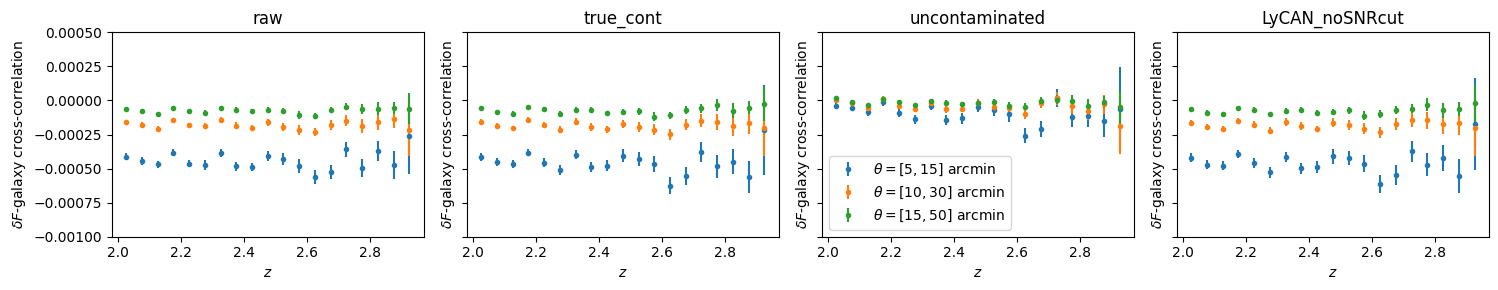

In [27]:
fig,axarr=pl.subplots(1,4,figsize=[15,3],sharey=True)

for ss, sim_mode_tag in enumerate(["raw","true_cont","uncontaminated","LyCAN_noSNRcut"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        cts_sp.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
        pl.xlabel("$z$")
        pl.ylabel("$\\delta F$-galaxy cross-correlation")
        if ss == 2:
            pl.legend()
        pl.title(sim_mode_tag)

pl.ylim([-0.001,0.0005])

pl.tight_layout()
#pl.savefig("lya-cross-mock-0.pdf", bbox_inches="tight")

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


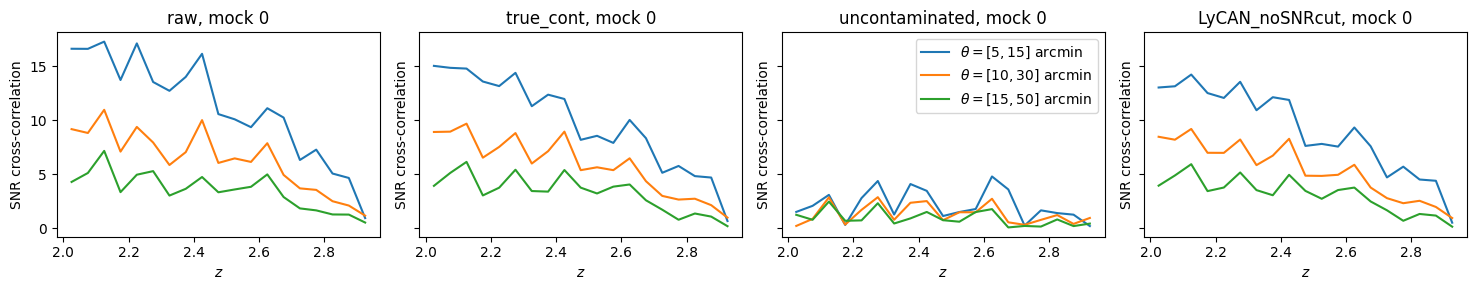

In [145]:
# plot SNR:
fig,axarr=pl.subplots(1,4,figsize=[15,3],sharey=True)

for ss, sim_mode_tag in enumerate(["raw","true_cont","uncontaminated","LyCAN_noSNRcut"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        data = abs(cts_sp.sample().data)
        error = cts_sp.sample().error
        zz = cts_sp.binning.mids
        pl.plot(zz, data/error,label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
        if ss == 2:
            pl.legend()
        pl.xlabel("$z$")
        pl.ylabel("SNR cross-correlation")
        pl.title(sim_mode_tag + ", mock 0")

pl.tight_layout()

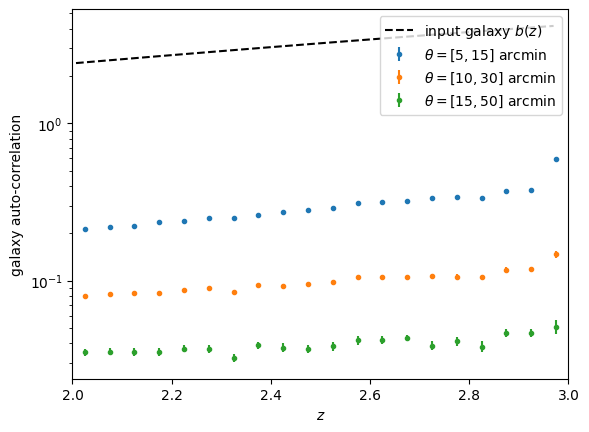

In [34]:
for ii in range(len(theta_min)):
    cts_pp = yaw.CorrFunc.from_file(saveroot + f"yaw-20bin/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    cts_pp.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
    pl.xlabel("$z$")
    pl.ylabel("galaxy auto-correlation")
pl.yscale('log')

# load and plot bias evolution curve:
bz = np.loadtxt("../bias_dc2.txt")
pl.plot(bz[:,0],bz[:,1],'--', label="input galaxy $b(z)$",color='k')
pl.xlim([2,3])
pl.legend()
#pl.savefig("galaxy-auto-mock-0.pdf", bbox_inches="tight")

In [125]:
root = "/pscratch/sd/q/qhang/desi-lya/results/"
#edges = cts_pp.binning.edges
#dz = edges[1]-edges[0]
nz_mean = 0
for ii in range(Nsims):
    if ii%3 == 0:
        print(f"Working on sim {ii}")
    fin = fits.open(root + f"run-{ii}/catalogue/unknown-zmin-1.8-zmax-3.0.fits")
    cc, nz_edges = np.histogram(fin[1].data['Z'], bins=np.linspace(1.7,3.0,27))
    nz_mean += cc
# here normalize
dz = nz_edges[1]-nz_edges[0]
nz_norm = nz_mean/sum(nz_mean)/dz
fname = "/pscratch/sd/q/qhang/desi-lya/nz-gal-true-z1.8-3.0-all-boxes-20bin.txt"
np.savetxt(fname, np.c_[nz_edges, np.append(nz_norm, 0)])

Working on sim 0
Working on sim 3
Working on sim 6
Working on sim 9


In [148]:
fname = "/pscratch/sd/q/qhang/desi-lya/nz-gal-true-z1.8-3.0-all-boxes-20bin.txt"
fin = np.loadtxt(fname)
nz_norm = fin[:-1,1]
nz_edges = fin[:,0]

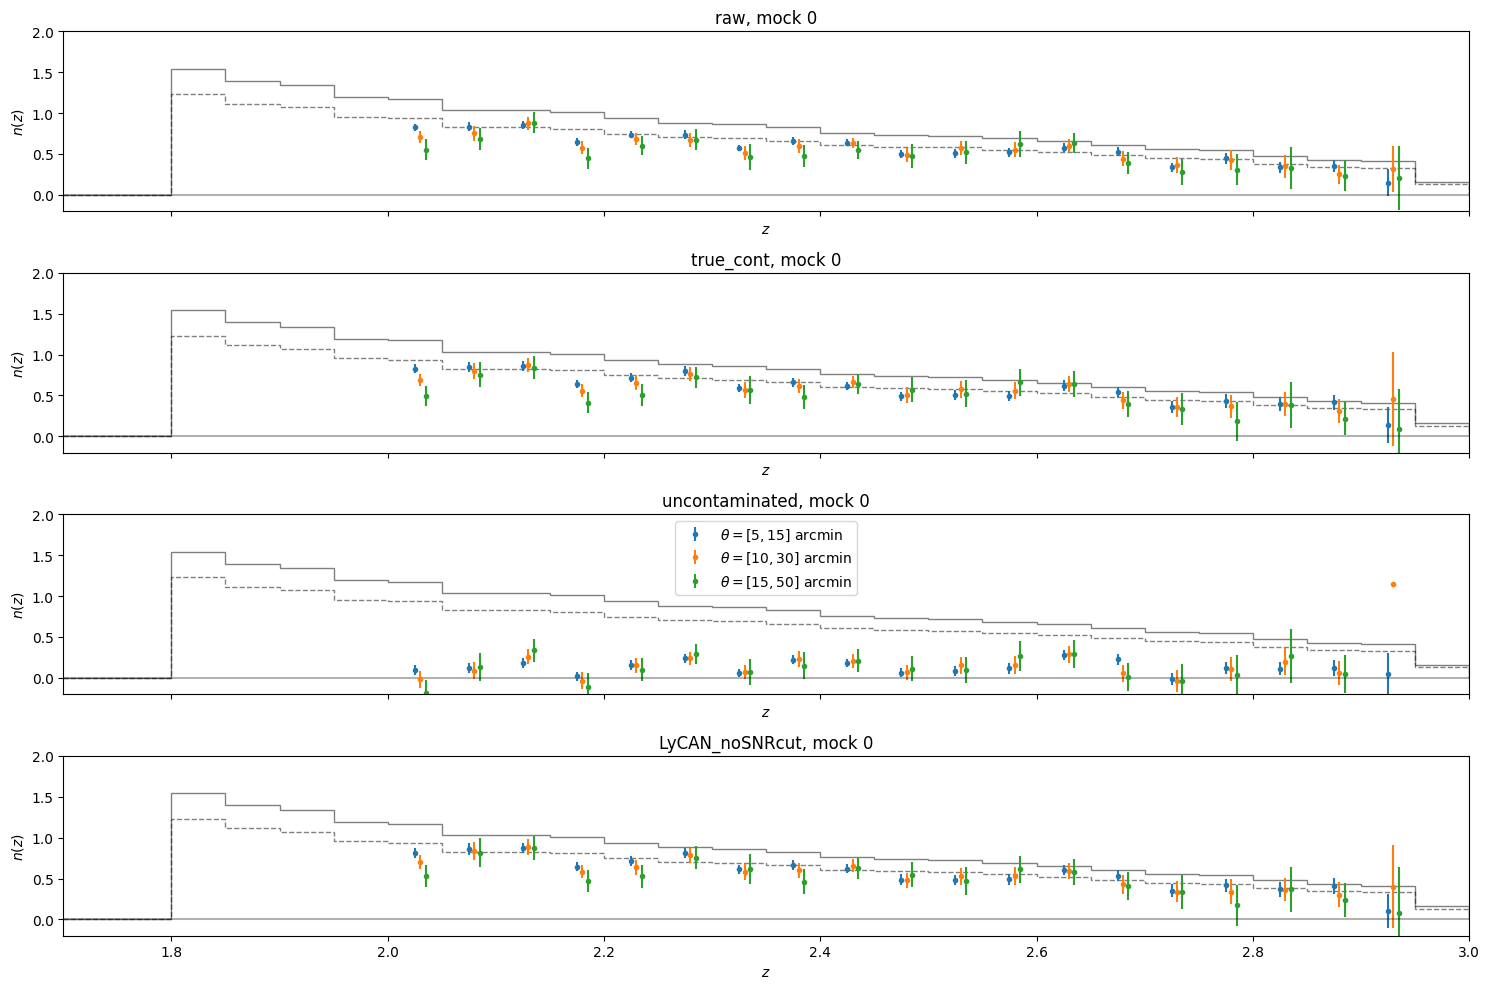

In [149]:
# here plot the recovered redshifts including w_pp:
fig,axarr=pl.subplots(4,figsize=[15,10],sharey=True,sharex=True)

for ss, sim_mode_tag in enumerate(["raw","true_cont","uncontaminated","LyCAN_noSNRcut"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        ncc = np.loadtxt(saveroot + f"yaw-20bin/nz_estimate-{sim_mode_tag}-wpp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.dat")
        pl.errorbar(ncc[:,0] + ii*0.005, ncc[:,1], yerr=ncc[:,2], label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin",
                   fmt='.')
        pl.xlabel("$z$")
        pl.ylabel("$n(z)$")
        if ss == 2:
            pl.legend()
        pl.title(sim_mode_tag + ", mock 0")
    
    pl.stairs(nz_norm, nz_edges, color='k', alpha=0.5, )
    pl.stairs(nz_norm*0.8, nz_edges, color='k', alpha=0.5,ls='--')
    pl.plot([1.7,3.0],[0,0],color='k', alpha=0.3)
pl.ylim([-0.2,2])
pl.xlim([1.7,3.0])
pl.tight_layout()
#pl.savefig("nz-wsp-wss-wpp-mock-0.pdf", bbox_inches="tight")

There is an amplitude mis-match of a factor of ~ 0.7. Need to find why this is the case.

### phot z>1.8, 10 bins:

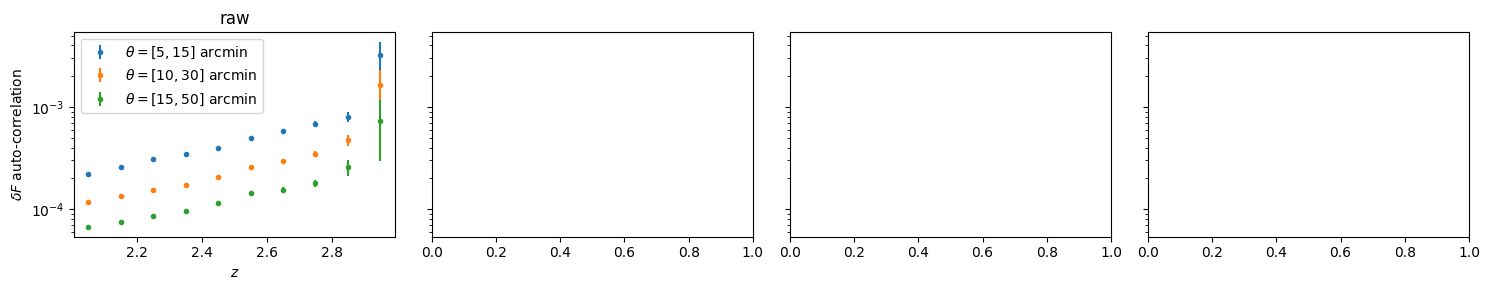

In [7]:
fig,axarr=pl.subplots(1,4,figsize=[15,3],sharey=True)

for ss, sim_mode_tag in enumerate(["raw"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        cts_ss = ScalarCorrFunc.from_file(saveroot + f"yaw-10bin/w_ss-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        cts_ss.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
        pl.xlabel("$z$")
        pl.ylabel("$\\delta F$ auto-correlation")
        pl.yscale('log')
        if ss == 0:
            pl.legend()
        pl.title(sim_mode_tag)

pl.tight_layout()
#pl.savefig("lya-auto-mock-0.pdf", bbox_inches="tight")

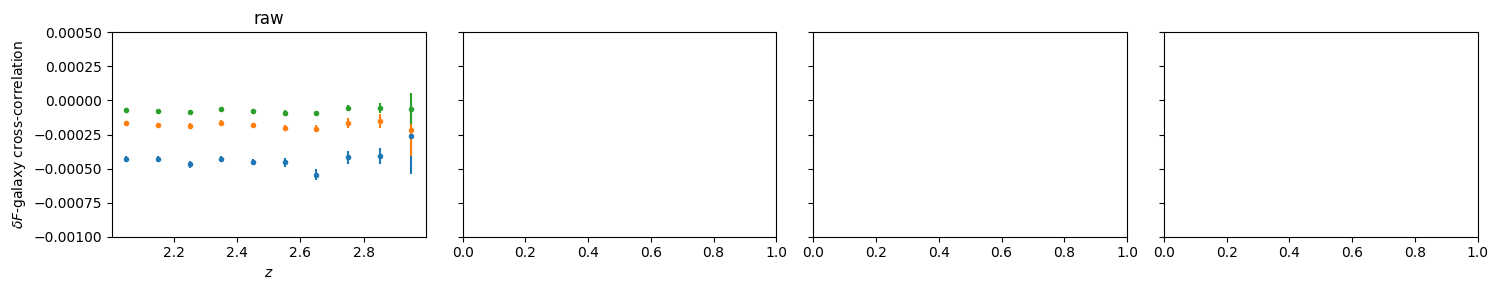

In [9]:
fig,axarr=pl.subplots(1,4,figsize=[15,3],sharey=True)

for ss, sim_mode_tag in enumerate(["raw"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw-10bin/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        cts_sp.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
        pl.xlabel("$z$")
        pl.ylabel("$\\delta F$-galaxy cross-correlation")
        if ss == 2:
            pl.legend()
        pl.title(sim_mode_tag)

pl.ylim([-0.001,0.0005])
pl.tight_layout()
#pl.savefig("lya-cross-mock-0.pdf", bbox_inches="tight")

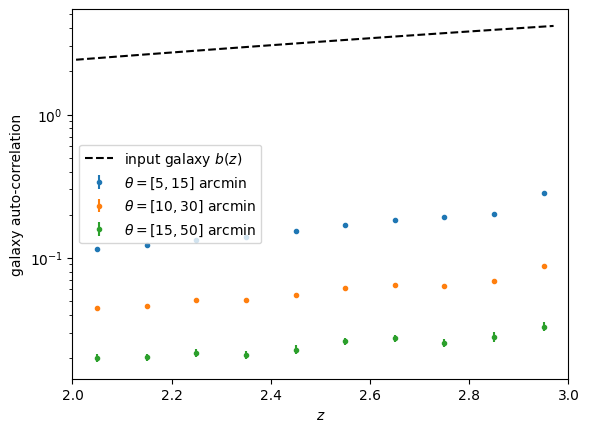

In [10]:
for ii in range(len(theta_min)):
    cts_pp = yaw.CorrFunc.from_file(saveroot + f"yaw-10bin/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    cts_pp.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
    pl.xlabel("$z$")
    pl.ylabel("galaxy auto-correlation")
pl.yscale('log')

# load and plot bias evolution curve:
bz = np.loadtxt("../bias_dc2.txt")
pl.plot(bz[:,0],bz[:,1],'--', label="input galaxy $b(z)$",color='k')
pl.xlim([2,3])
pl.legend()
#pl.savefig("galaxy-auto-mock-0.pdf", bbox_inches="tight")

In [12]:
root = "/pscratch/sd/q/qhang/desi-lya/results/"
#edges = cts_pp.binning.edges
#dz = edges[1]-edges[0]
Nsims=1
nz_mean = 0
for ii in range(Nsims):
    if ii%3 == 0:
        print(f"Working on sim {ii}")
    fin = fits.open(root + f"run-{ii}/catalogue/unknown-zmin-1.8-zmax-3.0.fits")
    cc, nz_edges = np.histogram(fin[1].data['Z'], bins=np.linspace(1.7,3.0,14))
    nz_mean += cc
# here normalize
dz = nz_edges[1]-nz_edges[0]
nz_norm = nz_mean/sum(nz_mean)/dz
fname = "/pscratch/sd/q/qhang/desi-lya/nz-gal-true-z1.8-3.0-mock-0-10bin.txt"
np.savetxt(fname, np.c_[nz_edges, np.append(nz_norm, 0)])

Working on sim 0


In [13]:
fname = "/pscratch/sd/q/qhang/desi-lya/nz-gal-true-z1.8-3.0-mock-0-10bin.txt"
fin = np.loadtxt(fname)
nz_norm = fin[:-1,1]
nz_edges = fin[:,0]

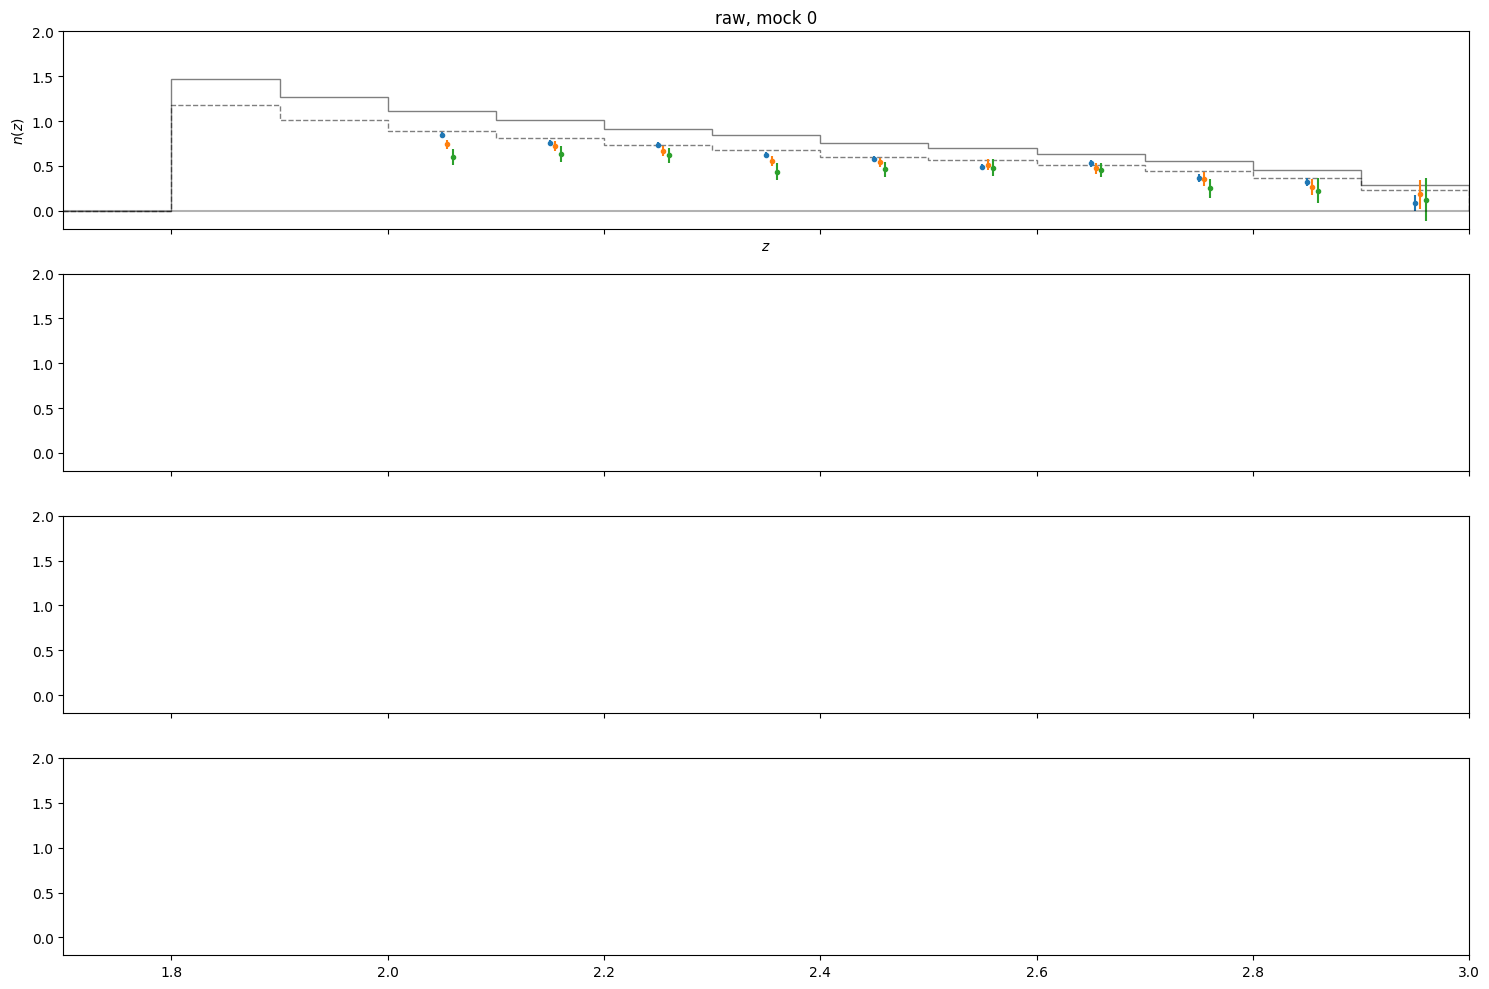

In [14]:
# here plot the recovered redshifts including w_pp:
fig,axarr=pl.subplots(4,figsize=[15,10],sharey=True,sharex=True)

for ss, sim_mode_tag in enumerate(["raw"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        ncc = np.loadtxt(saveroot + f"yaw-10bin/nz_estimate-{sim_mode_tag}-wpp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.dat")
        pl.errorbar(ncc[:,0] + ii*0.005, ncc[:,1], yerr=ncc[:,2], label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin",
                   fmt='.')
        pl.xlabel("$z$")
        pl.ylabel("$n(z)$")
        if ss == 2:
            pl.legend()
        pl.title(sim_mode_tag + ", mock 0")
    
    pl.stairs(nz_norm, nz_edges, color='k', alpha=0.5, )
    pl.stairs(nz_norm*0.8, nz_edges, color='k', alpha=0.5,ls='--')
    pl.plot([1.7,3.0],[0,0],color='k', alpha=0.3)
pl.ylim([-0.2,2])
pl.xlim([1.7,3.0])
pl.tight_layout()
#pl.savefig("nz-wsp-wss-wpp-mock-0.pdf", bbox_inches="tight")

### phot z>1.8, mid, 20 bins: 

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


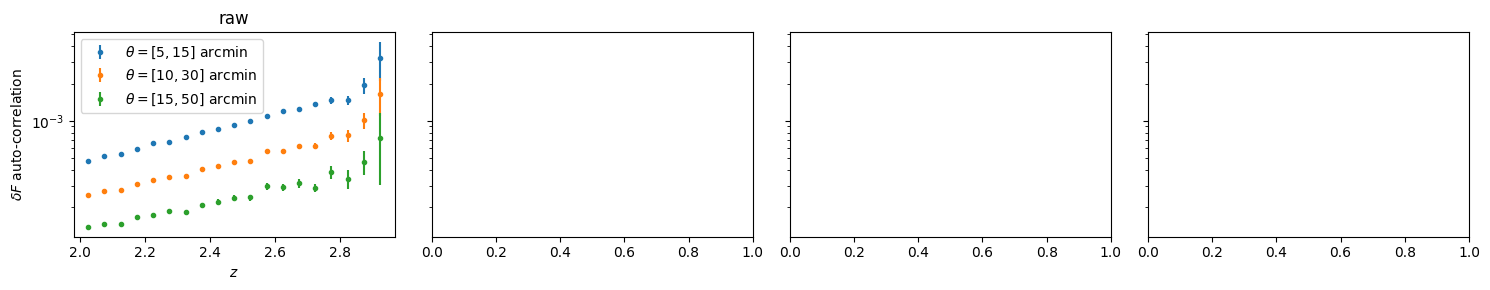

In [74]:
fig,axarr=pl.subplots(1,4,figsize=[15,3],sharey=True)

for ss, sim_mode_tag in enumerate(["raw"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        cts_ss = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin-mid/w_ss-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        cts_ss.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
        pl.xlabel("$z$")
        pl.ylabel("$\\delta F$ auto-correlation")
        pl.yscale('log')
        if ss == 0:
            pl.legend()
        pl.title(sim_mode_tag)

pl.tight_layout()
#pl.savefig("lya-auto-mock-0.pdf", bbox_inches="tight")

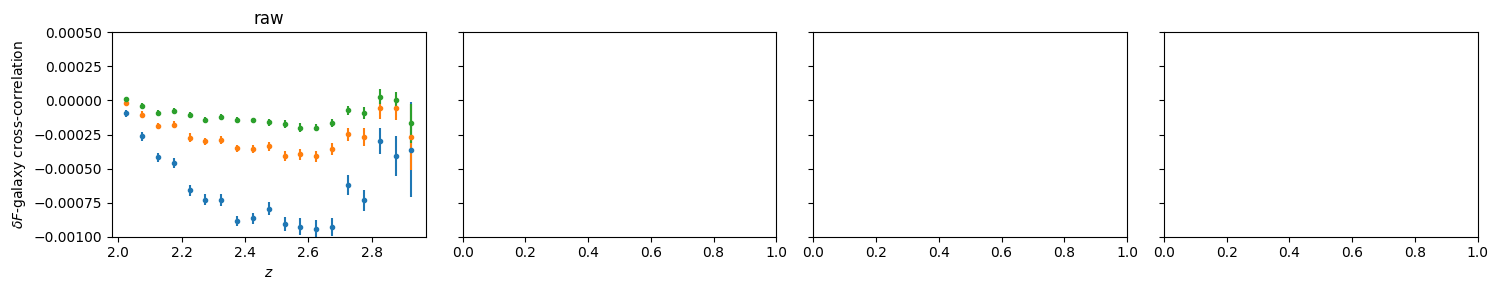

In [75]:
fig,axarr=pl.subplots(1,4,figsize=[15,3],sharey=True)

for ss, sim_mode_tag in enumerate(["raw"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin-mid/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        cts_sp.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
        pl.xlabel("$z$")
        pl.ylabel("$\\delta F$-galaxy cross-correlation")
        if ss == 2:
            pl.legend()
        pl.title(sim_mode_tag)

pl.ylim([-0.001,0.0005])

pl.tight_layout()
#pl.savefig("lya-cross-mock-0.pdf", bbox_inches="tight")

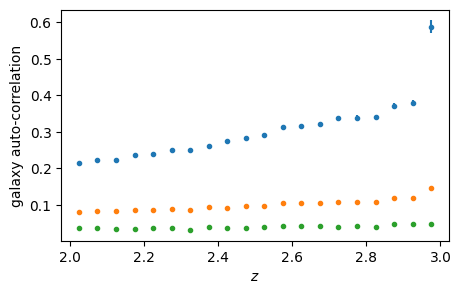

In [77]:
pl.figure(figsize=[5,3])
for ii in range(len(theta_min)):
    cts_pp = yaw.CorrFunc.from_file(saveroot + f"yaw-20bin-mid/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    cts_pp.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
    pl.xlabel("$z$")
    pl.ylabel("galaxy auto-correlation")
#pl.yscale('log')

In [127]:
root = "/pscratch/sd/q/qhang/desi-lya/results/"
#edges = cts_pp.binning.edges
#dz = edges[1]-edges[0]
nz_mean = 0
for ii in range(1):
    if ii%3 == 0:
        print(f"Working on sim {ii}")
    fin = fits.open(root + f"run-{ii}/catalogue/unknown-mid-zmin-1.8-zmax-3.0.fits")
    cc, nz_edges = np.histogram(fin[1].data['Z'], bins=np.linspace(1.7,3.0,27))
    nz_mean += cc
# here normalize
dz = nz_edges[1]-nz_edges[0]
nz_norm = nz_mean/sum(nz_mean)/dz
fname = "/pscratch/sd/q/qhang/desi-lya/nz-gal-true-mid-z1.8-3.0-box-0-20bin.txt"
np.savetxt(fname, np.c_[nz_edges, np.append(nz_norm, 0)])

Working on sim 0


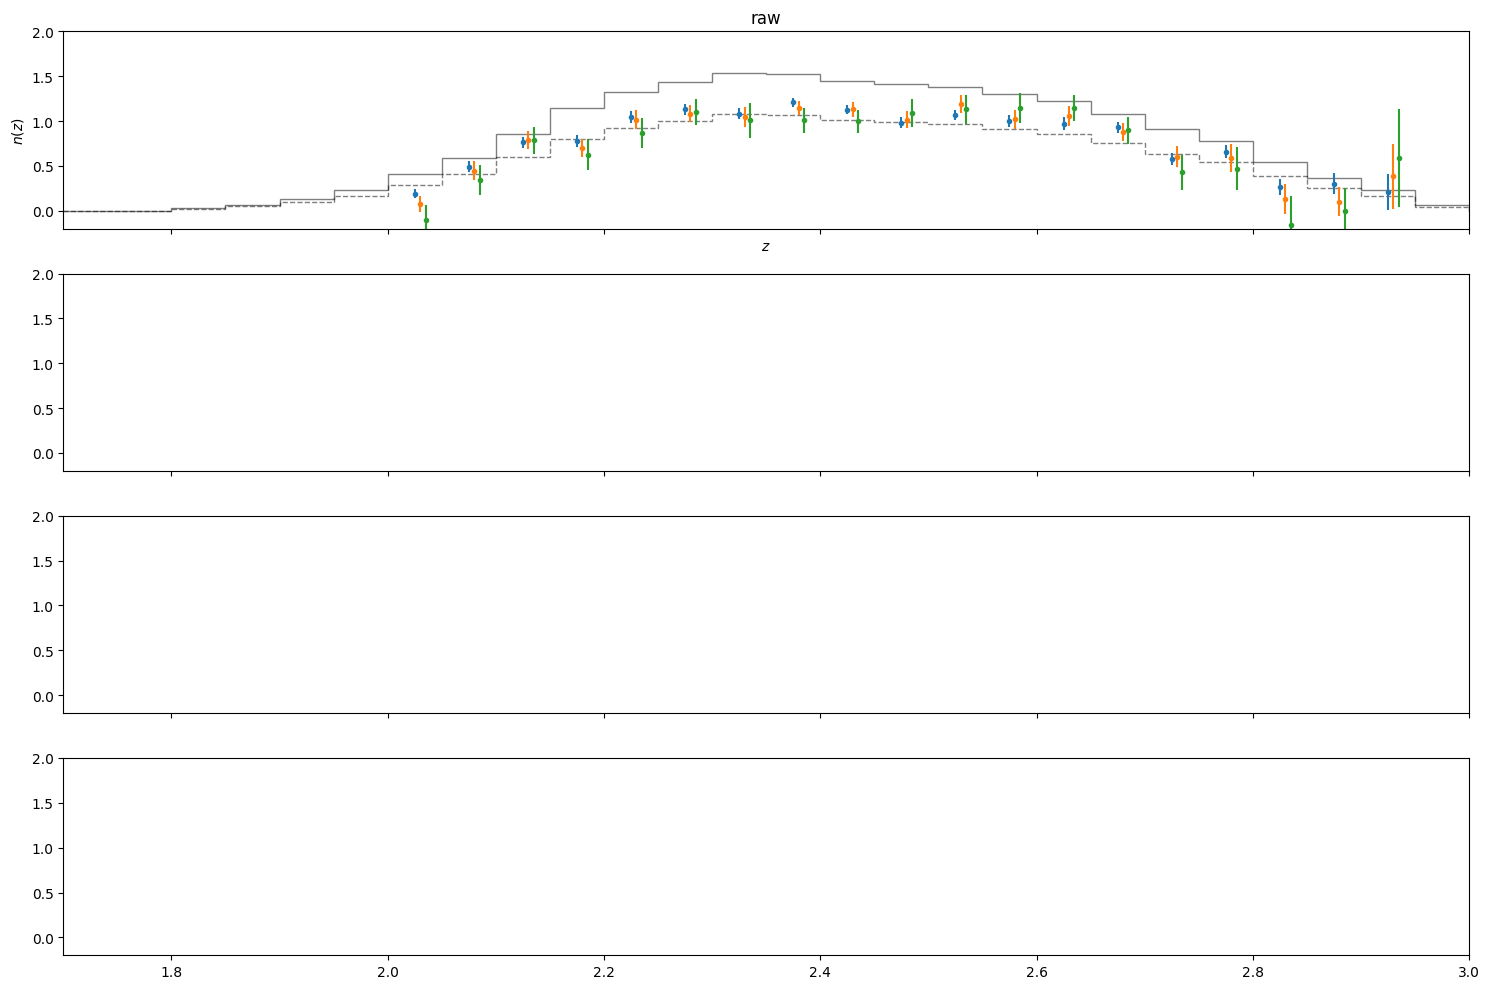

In [87]:
# here plot the recovered redshifts including w_pp:
fig,axarr=pl.subplots(4,figsize=[15,10],sharey=True,sharex=True)

for ss, sim_mode_tag in enumerate(["raw"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        ncc = np.loadtxt(saveroot + f"yaw-20bin-mid/nz_estimate-{sim_mode_tag}-wpp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.dat")
        pl.errorbar(ncc[:,0] + ii*0.005, ncc[:,1], yerr=ncc[:,2], label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin",
                   fmt='.')
        pl.xlabel("$z$")
        pl.ylabel("$n(z)$")
        if ss == 2:
            pl.legend()
        pl.title(sim_mode_tag)
    
    pl.stairs(nz_norm, nz_edges, color='k', alpha=0.5)
    pl.stairs(nz_norm*0.7, nz_edges, color='k', alpha=0.5, ls='--')
pl.ylim([-0.2,2])
pl.xlim([1.7,3.0])
pl.tight_layout()
#pl.savefig("nz-wsp-wss-wpp-mock-0.pdf", bbox_inches="tight")

### phot z>1.8, low, 20 bins: 

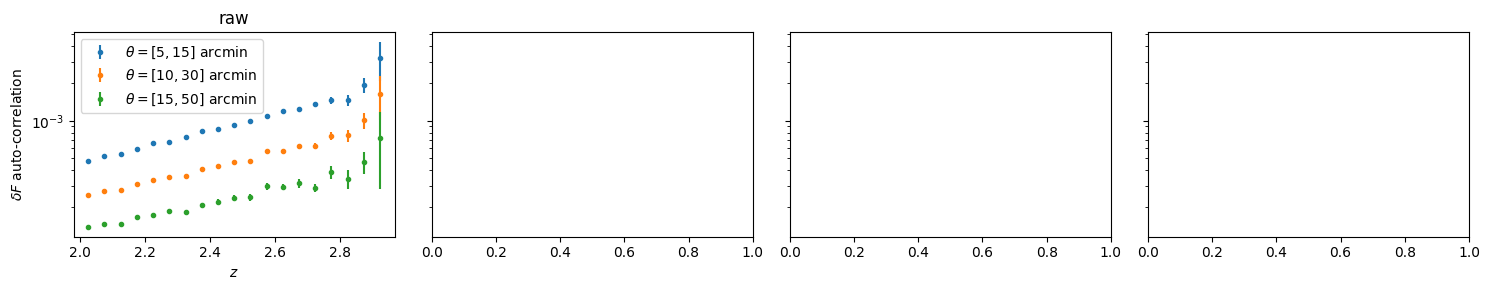

In [88]:
fig,axarr=pl.subplots(1,4,figsize=[15,3],sharey=True)

for ss, sim_mode_tag in enumerate(["raw"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        cts_ss = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin-low/w_ss-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        cts_ss.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
        pl.xlabel("$z$")
        pl.ylabel("$\\delta F$ auto-correlation")
        pl.yscale('log')
        if ss == 0:
            pl.legend()
        pl.title(sim_mode_tag)

pl.tight_layout()
#pl.savefig("lya-auto-mock-0.pdf", bbox_inches="tight")

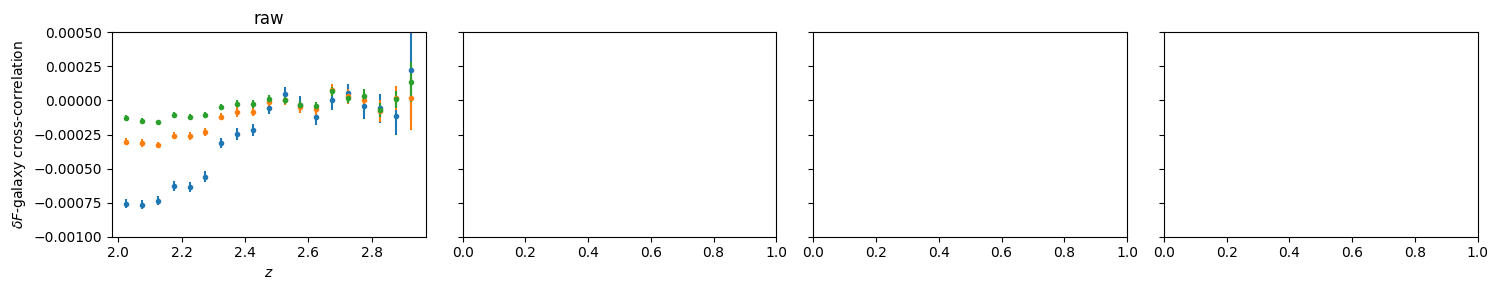

In [89]:
fig,axarr=pl.subplots(1,4,figsize=[15,3],sharey=True)

for ss, sim_mode_tag in enumerate(["raw"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin-low/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        cts_sp.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
        pl.xlabel("$z$")
        pl.ylabel("$\\delta F$-galaxy cross-correlation")
        if ss == 2:
            pl.legend()
        pl.title(sim_mode_tag)

pl.ylim([-0.001,0.0005])

pl.tight_layout()
#pl.savefig("lya-cross-mock-0.pdf", bbox_inches="tight")

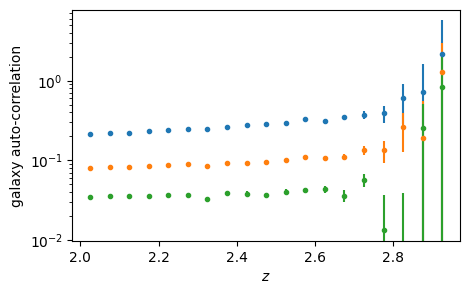

In [91]:
pl.figure(figsize=[5,3])
for ii in range(len(theta_min)):
    cts_pp = yaw.CorrFunc.from_file(saveroot + f"yaw-20bin-low/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    cts_pp.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
    pl.xlabel("$z$")
    pl.ylabel("galaxy auto-correlation")
pl.yscale('log')

In [128]:
root = "/pscratch/sd/q/qhang/desi-lya/results/"
#edges = cts_pp.binning.edges
#dz = edges[1]-edges[0]
nz_mean = 0
for ii in range(1):
    if ii%3 == 0:
        print(f"Working on sim {ii}")
    fin = fits.open(root + f"run-{ii}/catalogue/unknown-low-zmin-1.8-zmax-3.0.fits")
    cc, nz_edges = np.histogram(fin[1].data['Z'], bins=np.linspace(1.7,3.0,27))
    nz_mean += cc
# here normalize
dz = nz_edges[1]-nz_edges[0]
nz_norm = nz_mean/sum(nz_mean)/dz
fname = "/pscratch/sd/q/qhang/desi-lya/nz-gal-true-low-z1.8-3.0-box-0-20bin.txt"
np.savetxt(fname, np.c_[nz_edges, np.append(nz_norm, 0)])

Working on sim 0


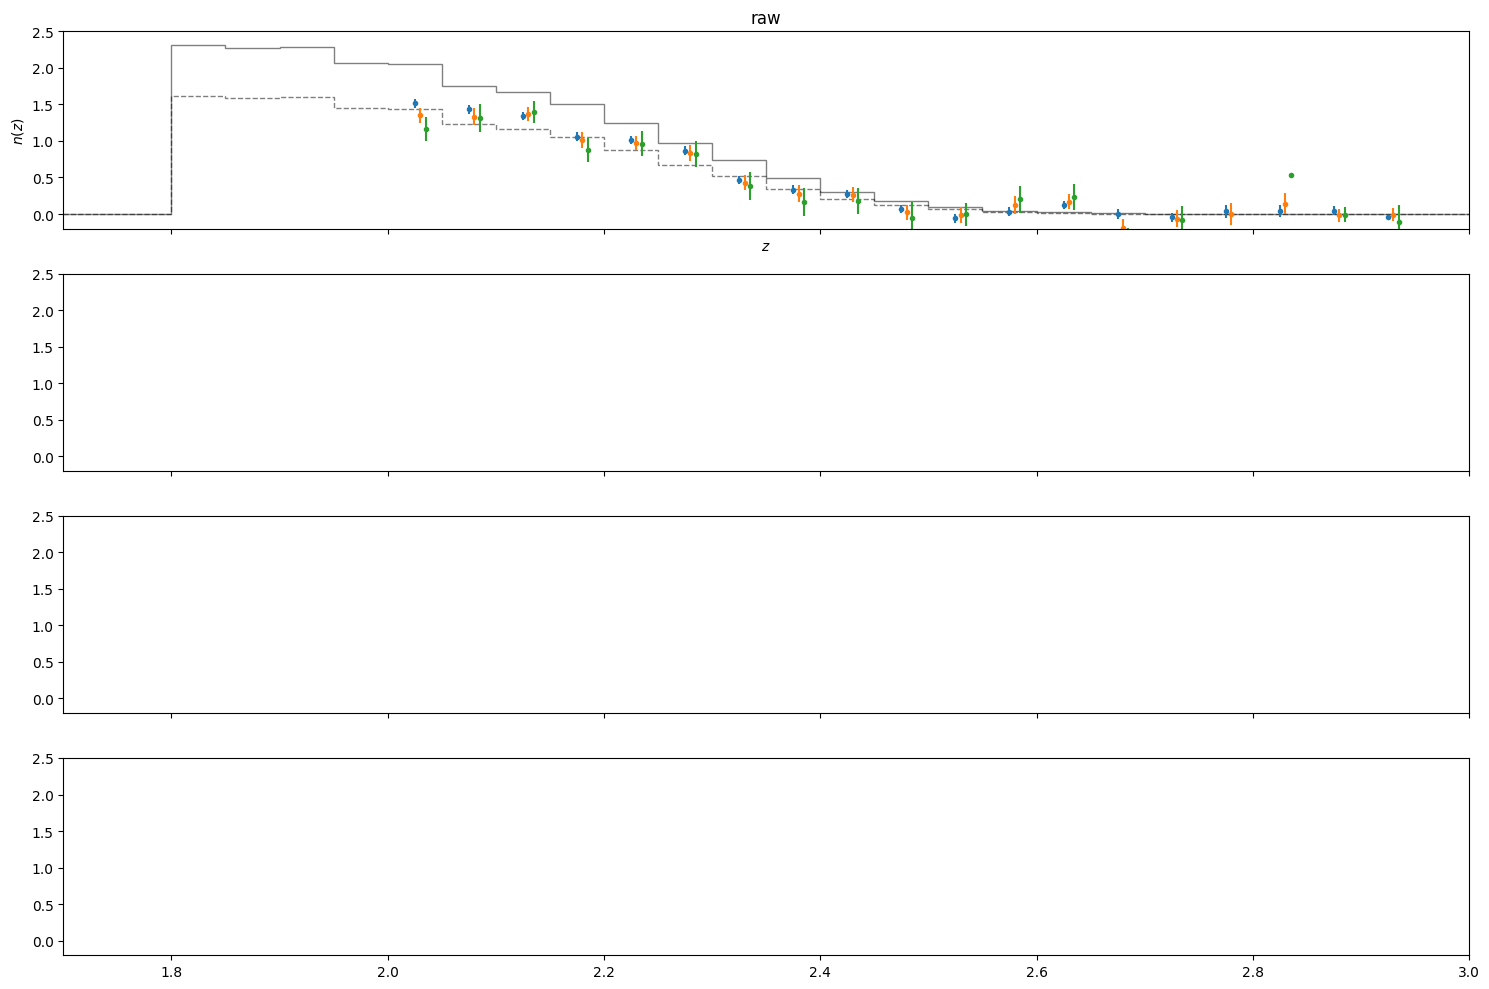

In [95]:
# here plot the recovered redshifts including w_pp:
fig,axarr=pl.subplots(4,figsize=[15,10],sharey=True,sharex=True)

for ss, sim_mode_tag in enumerate(["raw"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        ncc = np.loadtxt(saveroot + f"yaw-20bin-low/nz_estimate-{sim_mode_tag}-wpp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.dat")
        pl.errorbar(ncc[:,0] + ii*0.005, ncc[:,1], yerr=ncc[:,2], label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin",
                   fmt='.')
        pl.xlabel("$z$")
        pl.ylabel("$n(z)$")
        if ss == 2:
            pl.legend()
        pl.title(sim_mode_tag)
    
    pl.stairs(nz_norm, nz_edges, color='k', alpha=0.5)
    pl.stairs(nz_norm*0.7, nz_edges, color='k', alpha=0.5, ls='--')
pl.ylim([-0.2,2.5])
pl.xlim([1.7,3.0])
pl.tight_layout()
#pl.savefig("nz-wsp-wss-wpp-mock-0.pdf", bbox_inches="tight")

### phot SRD, 20 bins: 

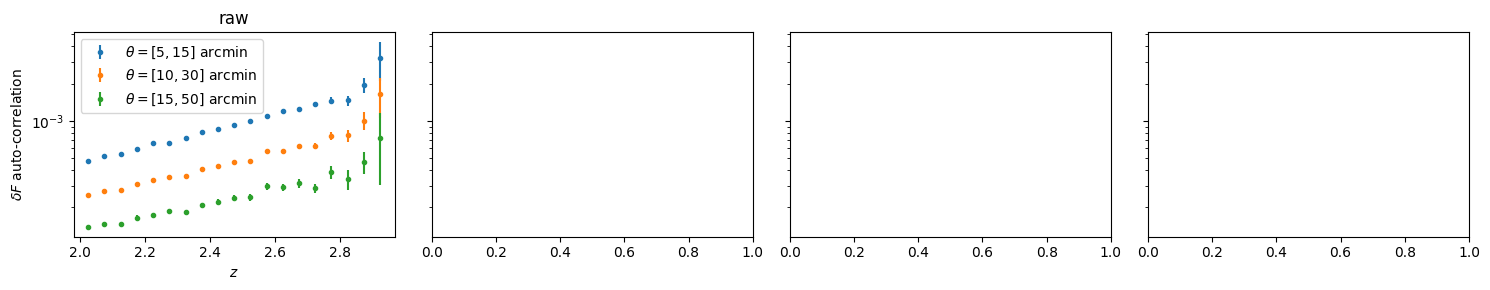

In [96]:
fig,axarr=pl.subplots(1,4,figsize=[15,3],sharey=True)

for ss, sim_mode_tag in enumerate(["raw"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        cts_ss = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin-SRD_nz/w_ss-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        cts_ss.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
        pl.xlabel("$z$")
        pl.ylabel("$\\delta F$ auto-correlation")
        pl.yscale('log')
        if ss == 0:
            pl.legend()
        pl.title(sim_mode_tag)

pl.tight_layout()
#pl.savefig("lya-auto-mock-0.pdf", bbox_inches="tight")

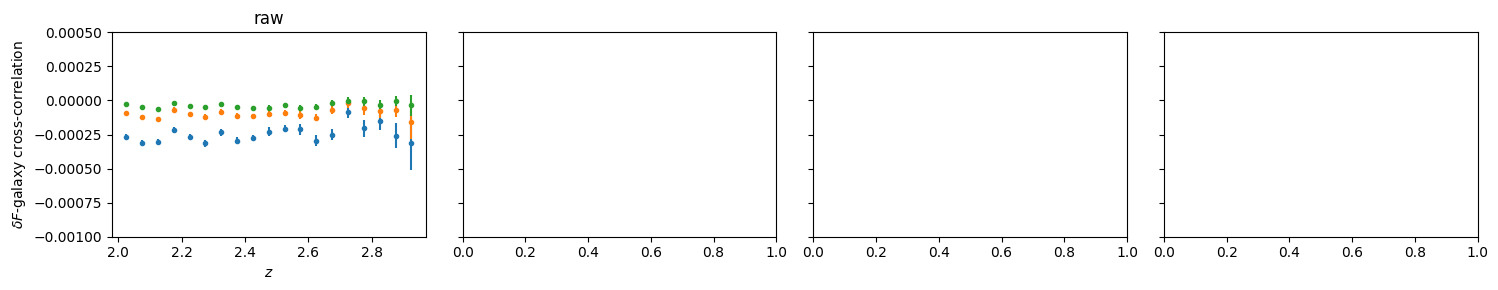

In [100]:
fig,axarr=pl.subplots(1,4,figsize=[15,3],sharey=True)

for ss, sim_mode_tag in enumerate(["raw"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin-SRD_nz/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        cts_sp.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
        pl.xlabel("$z$")
        pl.ylabel("$\\delta F$-galaxy cross-correlation")
        if ss == 2:
            pl.legend()
        pl.title(sim_mode_tag)

pl.ylim([-0.001,0.0005])

pl.tight_layout()
#pl.savefig("lya-cross-mock-0.pdf", bbox_inches="tight")

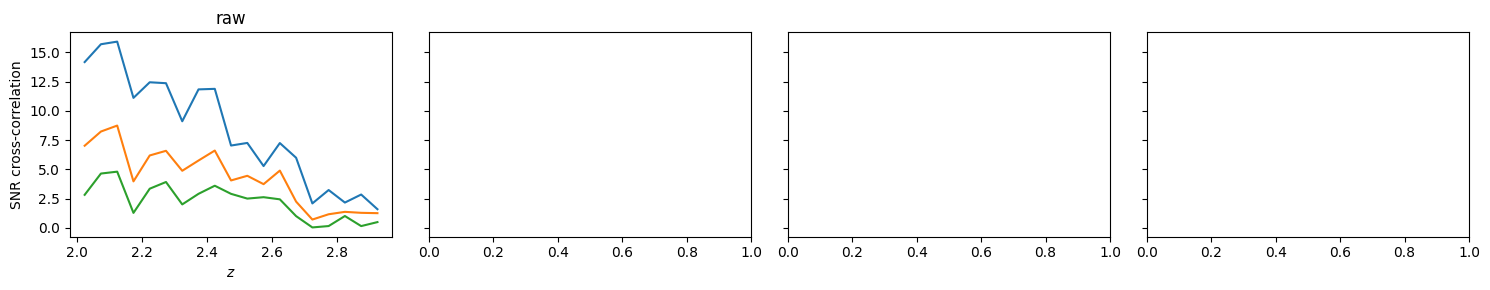

In [101]:
# plot SNR:
fig,axarr=pl.subplots(1,4,figsize=[15,3],sharey=True)

for ss, sim_mode_tag in enumerate(["raw"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin-SRD_nz/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
        data = abs(cts_sp.sample().data)
        error = cts_sp.sample().error
        zz = cts_sp.binning.mids
        pl.plot(zz, data/error,label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
        if ss == 2:
            pl.legend()
        pl.xlabel("$z$")
        pl.ylabel("SNR cross-correlation")
        pl.title(sim_mode_tag)

#pl.ylim([-0.001,0.0005])
pl.tight_layout()

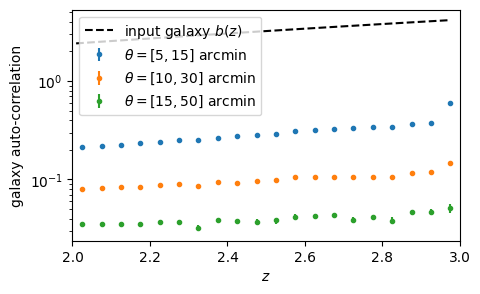

In [102]:
pl.figure(figsize=[5,3])
for ii in range(len(theta_min)):
    cts_pp = yaw.CorrFunc.from_file(saveroot + f"yaw-20bin/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    cts_pp.sample().plot(label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin")
    pl.xlabel("$z$")
    pl.ylabel("galaxy auto-correlation")
pl.yscale('log')

# load and plot bias evolution curve:
bz = np.loadtxt("../bias_dc2.txt")
pl.plot(bz[:,0],bz[:,1],'--', label="input galaxy $b(z)$",color='k')
pl.xlim([2,3])
pl.legend()
#pl.savefig("galaxy-auto-mock-0.pdf", bbox_inches="tight")

In [10]:
root = "/pscratch/sd/q/qhang/desi-lya/results/"
#edges = cts_pp.binning.edges
#dz = edges[1]-edges[0]
nz_mean = 0
for ii in range(10):
    if ii%3 == 0:
        print(f"Working on sim {ii}")
    fin = fits.open(root + f"run-{ii}/catalogue/unknown-SRD_nz-zmin-0-zmax-3.fits")
    cc, nz_edges = np.histogram(fin[1].data['Z'], bins=np.linspace(0,3.0,61))
    nz_mean += cc
# here normalize
dz = nz_edges[1]-nz_edges[0]
nz_norm = nz_mean/sum(nz_mean)/dz
fname = "/pscratch/sd/q/qhang/desi-lya/nz-gal-true-SRD_nz-z0-3-all-boxes-20bin.txt"
np.savetxt(fname, np.c_[nz_edges, np.append(nz_norm, 0)])

Working on sim 0
Working on sim 3
Working on sim 6
Working on sim 9


In [11]:
root = "/pscratch/sd/q/qhang/desi-lya/results/"
#edges = cts_pp.binning.edges
#dz = edges[1]-edges[0]
nz_mean = 0
for ii in range(10):
    if ii%3 == 0:
        print(f"Working on sim {ii}")
    fin = fits.open(root + f"run-{ii}/catalogue/unknown-SRD_nz-zmin-0-zmax-3.fits")
    cc, nz_edges = np.histogram(fin[1].data['Z'], bins=np.linspace(0,3.0,121))
    nz_mean += cc
# here normalize
dz = nz_edges[1]-nz_edges[0]
nz_norm = nz_mean/sum(nz_mean)/dz
fname = "/pscratch/sd/q/qhang/desi-lya/nz-gal-true-SRD_nz-z0-3-all-boxes-40bin.txt"
np.savetxt(fname, np.c_[nz_edges, np.append(nz_norm, 0)])

Working on sim 0
Working on sim 3
Working on sim 6
Working on sim 9


In [160]:
fname = "/pscratch/sd/q/qhang/desi-lya/nz-gal-true-SRD_nz-z0-3-box-0-20bin.txt"
fin = np.loadtxt(fname)
nz_edges = fin[:,0]
nz_norm = fin[:-1,1]

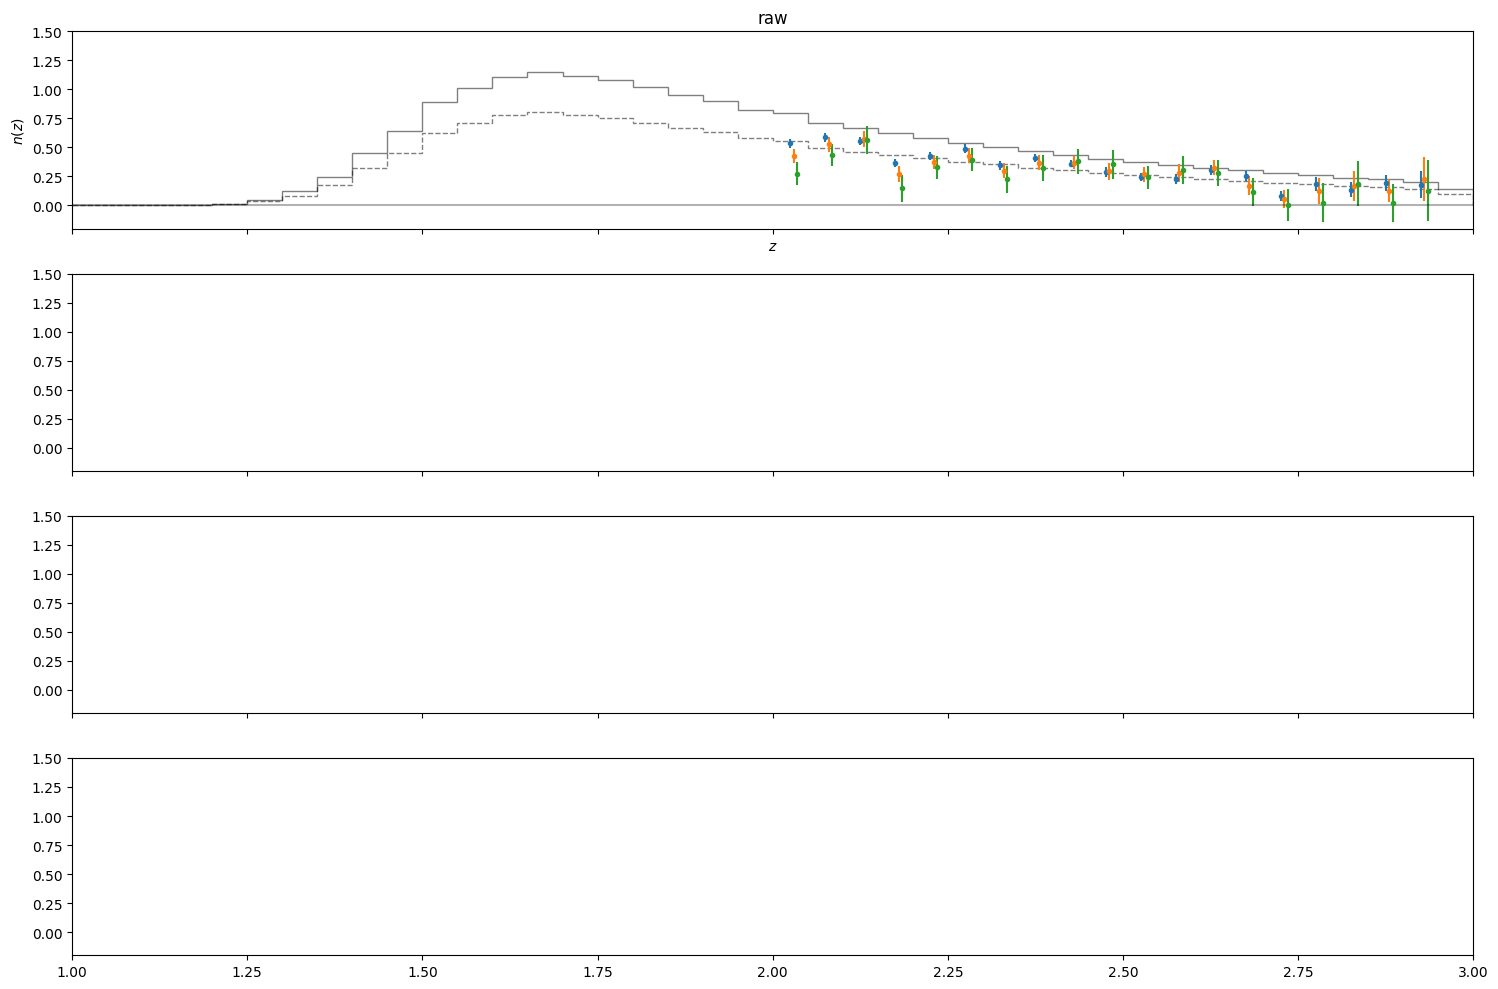

In [166]:
# here plot the recovered redshifts including w_pp:
fig,axarr=pl.subplots(4,figsize=[15,10],sharey=True,sharex=True)

for ss, sim_mode_tag in enumerate(["raw"]):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        ncc = np.loadtxt(saveroot + f"yaw-20bin-SRD_nz/nz_estimate-{sim_mode_tag}-wpp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.dat")
        pl.errorbar(ncc[:,0] + ii*0.005, ncc[:,1], yerr=ncc[:,2], label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin",
                   fmt='.')
        pl.xlabel("$z$")
        pl.ylabel("$n(z)$")
        if ss == 2:
            pl.legend()
        pl.title(sim_mode_tag)
    
    pl.stairs(nz_norm, nz_edges, color='k', alpha=0.5)
    pl.stairs(nz_norm*0.7, nz_edges, color='k', alpha=0.5, ls='--')
    pl.plot([0,3],[0,0],color='k',alpha=0.3)

pl.ylim([-0.2,1.5])
pl.xlim([1.0,3.0])
pl.tight_layout()
#pl.savefig("nz-wsp-wss-wpp-mock-0.pdf", bbox_inches="tight")

### Produce a plot with different phot distribution for mock 0 raw 

In [130]:
nztrue_low = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/nz-gal-true-low-z1.8-3.0-box-0-20bin.txt")
nztrue_mid = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/nz-gal-true-mid-z1.8-3.0-box-0-20bin.txt")
nztrue_SRD = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/nz-gal-true-SRD_nz-z0-3-box-0-20bin.txt")

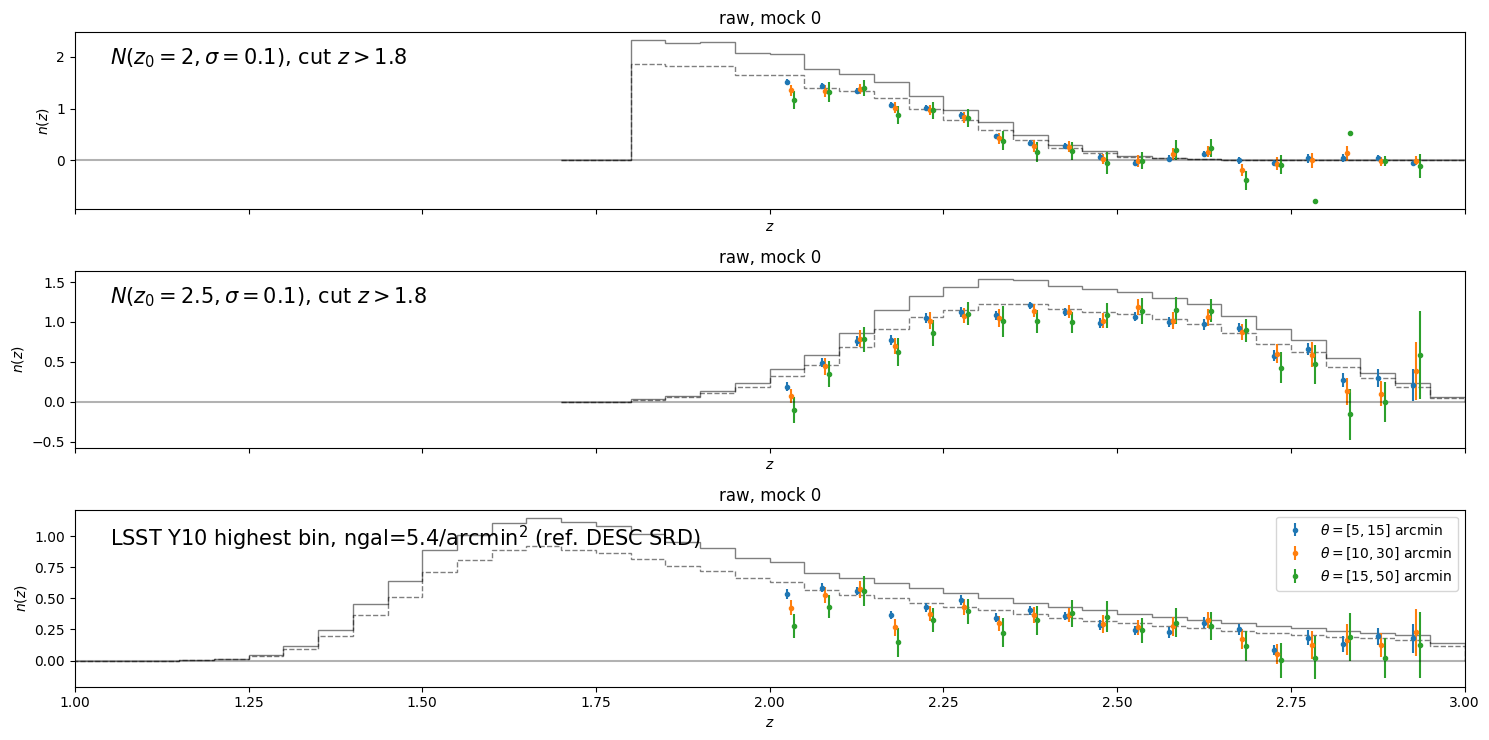

In [141]:
# here plot the recovered redshifts including w_pp:
fig,axarr=pl.subplots(3,figsize=[15,7.5], sharex=True)

sim_mode_tag="raw"
phot_tag=["low","mid","SRD_nz"]
nztrue = [nztrue_low,nztrue_mid,nztrue_SRD]
text=[
    "$N(z_0=2, \\sigma=0.1)$, cut $z>1.8$",
    "$N(z_0=2.5, \\sigma=0.1)$, cut $z>1.8$",
    "LSST Y10 highest bin, ngal=5.4/arcmin$^2$ (ref. DESC SRD)",
]

for ss, pt in enumerate(phot_tag):
    pl.sca(axarr[ss])
    for ii in range(len(theta_min)):
        ncc = np.loadtxt(saveroot + f"yaw-20bin-{pt}/nz_estimate-{sim_mode_tag}-wpp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.dat")
        pl.errorbar(ncc[:,0] + ii*0.005, ncc[:,1], yerr=ncc[:,2], label=f"$\\theta = [{theta_min[ii]}, {theta_max[ii]}]$ arcmin",
                   fmt='.')
        pl.xlabel("$z$")
        pl.ylabel("$n(z)$")
        if ss == 2:
            pl.legend()
        pl.title(sim_mode_tag + ", mock 0")
    
    nz_norm = nztrue[ss][:-1,1]
    nz_edges = nztrue[ss][:,0]
    pl.stairs(nz_norm, nz_edges, color='k', alpha=0.5)
    pl.stairs(nz_norm*0.8, nz_edges, color='k', alpha=0.5, ls='--')
    pl.plot([0,3],[0,0],color='k',alpha=0.3)
    pl.text(1.05, nz_norm.max()*0.8, text[ss], size=15)

#pl.ylim([-0.2,1.5])
pl.xlim([1.0,3.0])
pl.tight_layout()
#pl.savefig("nz-wsp-wss-wpp-mock-0.pdf", bbox_inches="tight")

# 4. YAW results: all sims baseline

All 10 boxes. Baseline definition can always be changed.


Baseline setting:
- Lya 20 bins, raw and true_cont
- Phot tail at $z>1.8$
- Theta scale [10,30] arcmin without scaling

In [2]:
root = "/pscratch/sd/q/qhang/desi-lya/results/"

# These settings can be changed later on:
Nbins=40 # change this to 20 later!
Nsims=10
#theta_min=[5,10,15]
#theta_max=[15,30,50]
theta_min = [10]
theta_max = [30]

sim_modes = ['raw','true_cont']

Load data here:

In [3]:
w_ss = {}
w_sp = {}
w_pp = {}
ncc = {}
w_ss_jn = {}
w_sp_jn = {}
w_pp_jn = {}
ncc_jn = {}

# different scales:
for mode in sim_modes:
    # mean value
    w_ss[mode]={}
    w_sp[mode]={}
    ncc[mode]={}

    # jn value
    w_ss_jn[mode]={}
    w_sp_jn[mode]={}
    ncc_jn[mode]={}
    for jj, tmin, tmax in zip(np.arange(len(theta_min)),theta_min,theta_max):
        
        w_ss[mode][jj] = np.zeros((Nbins,Nsims))
        w_sp[mode][jj] = np.zeros((Nbins,Nsims))
        ncc[mode][jj] = np.zeros((Nbins,Nsims))
    
        w_ss_jn[mode][jj]  = np.zeros((Nbins,Nsims))
        w_sp_jn[mode][jj]  = np.zeros((Nbins,Nsims))
        ncc_jn[mode][jj]  = np.zeros((Nbins,Nsims))

        if mode == 'raw':
            w_pp[jj] = np.zeros((Nbins,Nsims))
            w_pp_jn[jj] = np.zeros((Nbins,Nsims))

        for ii in range(Nsims):
            # ref auto  
            fname = root + f"run-{ii}/yaw/w_ss-{mode}-theta-min-{tmin}-max-{tmax}.hdf5"
            f = yaw.ScalarCorrFunc.from_file(fname)
            w_ss[mode][jj][:,ii] = (f.sample().data)
            w_ss_jn[mode][jj][:,ii] = (f.sample().error)
    
            # ref cross
            fname = root + f"run-{ii}/yaw/w_sp-{mode}-theta-min-{tmin}-max-{tmax}.hdf5"
            f = yaw.ScalarCorrFunc.from_file(fname)
            w_sp[mode][jj][:,ii] = (f.sample().data)
            w_sp_jn[mode][jj][:,ii] = (f.sample().error)

            if mode == 'raw':
                # unk auto
                fname = root + f"run-{ii}/yaw/w_pp-theta-min-{tmin}-max-{tmax}.hdf5"
                f = yaw.CorrFunc.from_file(fname)
                w_pp[jj][:,ii] = (f.sample().data)
                w_pp_jn[jj][:,ii] = (f.sample().error)

            # result n(z)
            fname = root + f"run-{ii}/yaw/nz_estimate-{mode}-wpp-theta-min-{tmin}-max-{tmax}.dat"
            fin=np.loadtxt(fname)
            ncc[mode][jj][:,ii] = fin[:,1]
            ncc_jn[mode][jj][:,ii] = fin[:,2]
z = (f.binning.mids)

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


In [4]:
w_ss_mean = {}
w_sp_mean = {}
w_pp_mean = {}
ncc_mean = {}
for mode in sim_modes:
    w_ss_mean[mode] = {}
    w_sp_mean[mode] = {}
    ncc_mean[mode] = {}
    for jj in range(len(theta_min)):
        w_ss_mean[mode][jj] = np.c_[np.mean(w_ss[mode][jj],axis=1), np.std(w_ss[mode][jj],axis=1)]
        w_sp_mean[mode][jj] = np.c_[np.mean(w_sp[mode][jj],axis=1), np.std(w_sp[mode][jj],axis=1)]
        ncc_mean[mode][jj] = np.c_[np.mean(ncc[mode][jj],axis=1), np.std(ncc[mode][jj],axis=1)]
        
        if mode == 'raw':
            w_pp_mean[jj] = np.c_[np.mean(w_pp[jj],axis=1), np.std(w_pp[jj],axis=1)]

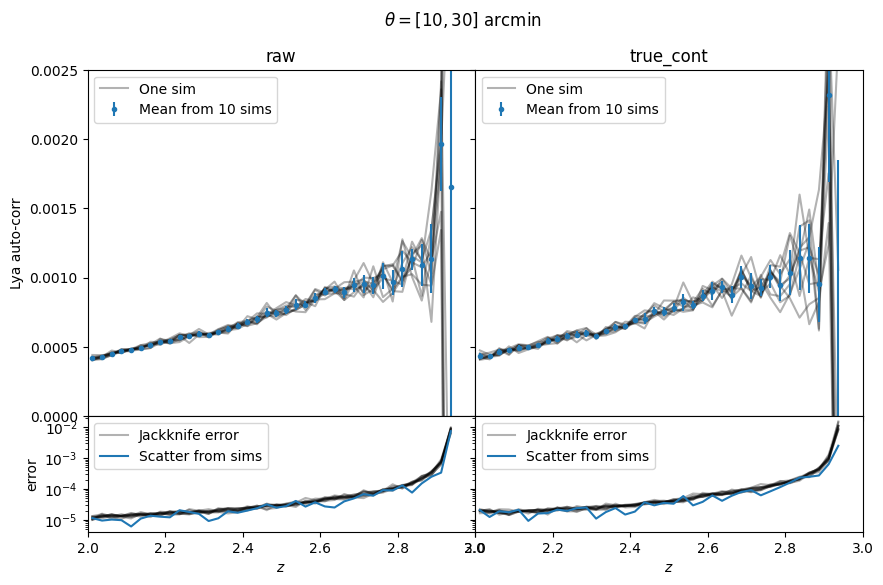

In [14]:
# now make the plots:
ylim=[0,0.0025]

for jj in range(len(theta_min)):

    fig,axarr=pl.subplots(2,2,figsize=[10,6],sharey='row', gridspec_kw={'height_ratios': [3,1]},
                         sharex=True)
    
    pl.suptitle(f"$\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin")
    
    for mm, mode in enumerate(sim_modes):
        for ii in range(Nsims):
            if ii == 0:
                label1="One sim"
                label2="Jackknife error"
            else:
                label1=""
                label2=""
    
            pl.sca(axarr[0, mm])
            pl.plot(z, w_ss[mode][jj][:,ii],color='k',alpha=0.3,label=label1) 
            pl.sca(axarr[1,mm]) 
            pl.plot(z, w_ss_jn[mode][jj][:,ii],color='k',alpha=0.3,label=label2) 
            
        pl.sca(axarr[0, mm])
        pl.errorbar(z, w_ss_mean[mode][jj][:,0], yerr=w_ss_mean[mode][jj][:,1], fmt='.', label="Mean from 10 sims")
        pl.title(mode)
        pl.legend()
        
        pl.sca(axarr[1, mm])
        pl.plot(z, w_ss_mean[mode][jj][:,1], label="Scatter from sims")
        pl.xlabel("$z$")
        pl.legend()
        pl.yscale('log')
    
    pl.sca(axarr[0,0])
    pl.ylabel("Lya auto-corr")
    pl.ylim(ylim)
    pl.xlim([2,3])
    #pl.yscale('log')
    
    pl.sca(axarr[1,0])
    pl.ylabel("error")
    
    pl.subplots_adjust(wspace=0, hspace=0)
    
    #pl.savefig("../plots/auto-corr.pdf",bbox_inches="tight")

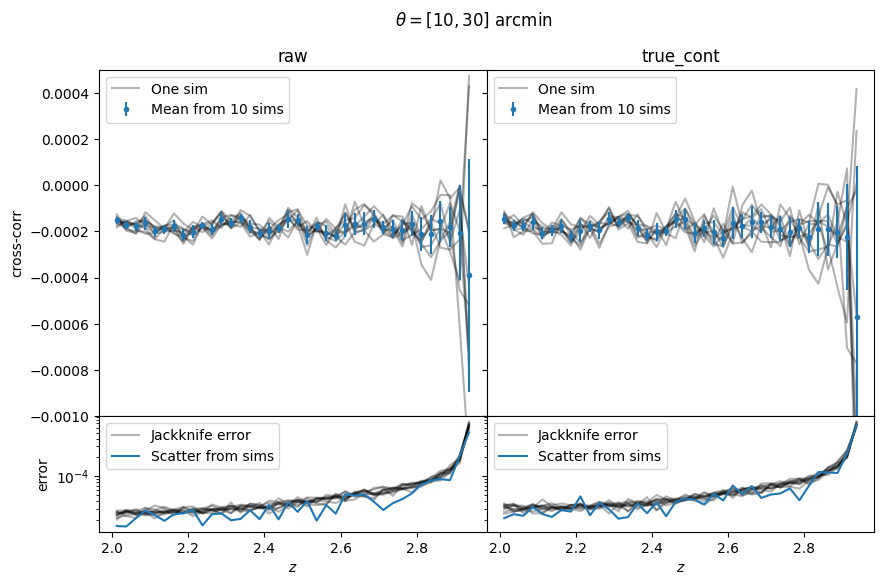

In [16]:
ylim=[-0.0010,0.0005]

for jj in range(len(theta_min)):

    fig,axarr=pl.subplots(2,2,figsize=[10,6],sharey='row', gridspec_kw={'height_ratios': [3,1]},
                         sharex=True)
    
    pl.suptitle(f"$\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin")
    
    for mm, mode in enumerate(sim_modes):
        for ii in range(Nsims):
            if ii == 0:
                label1="One sim"
                label2="Jackknife error"
            else:
                label1=""
                label2=""
    
            pl.sca(axarr[0, mm])
            pl.plot(z, w_sp[mode][jj][:,ii],color='k',alpha=0.3,label=label1) 
            pl.sca(axarr[1,mm]) 
            pl.plot(z, w_sp_jn[mode][jj][:,ii],color='k',alpha=0.3,label=label2) 
            
        pl.sca(axarr[0, mm])
        pl.errorbar(z, w_sp_mean[mode][jj][:,0], yerr=w_sp_mean[mode][jj][:,1], fmt='.', label="Mean from 10 sims")
        pl.title(mode)
        pl.legend()
        
        pl.sca(axarr[1, mm])
        pl.plot(z, w_sp_mean[mode][jj][:,1], label="Scatter from sims")
        pl.xlabel("$z$")
        pl.legend()
        pl.yscale('log')
    
    pl.sca(axarr[0,0])
    pl.ylabel("cross-corr")
    pl.ylim(ylim)
    
    pl.sca(axarr[1,0])
    pl.ylabel("error")
    
    pl.subplots_adjust(wspace=0, hspace=0)
    
    #pl.savefig("../plots/cross-corr.pdf",bbox_inches="tight")

(2.0, 3.0)

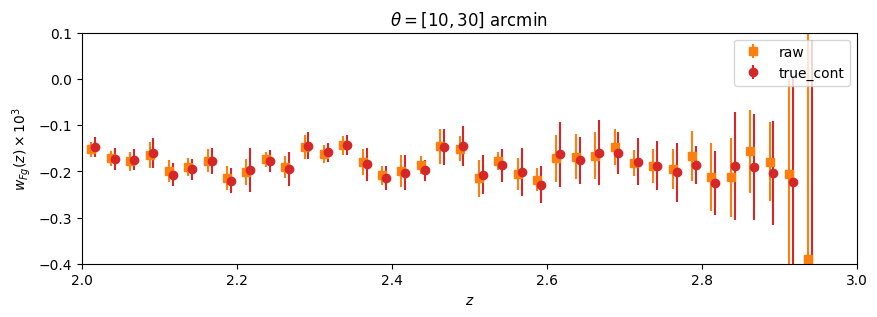

In [49]:
# let's produce a plot showing them on top of each other:
pl.style.use('default')
ylim=[-0.4,0.1]
fmt = ['s','o']

for jj in range(len(theta_min)):
    fig,axarr=pl.subplots(figsize=[10,3])
    pl.title(f"$\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin")
    for mm, mode in enumerate(sim_modes):
        pl.errorbar(z + 0.005*mm, w_sp_mean[mode][jj][:,0]*1e3, yerr=w_sp_mean[mode][jj][:,1]*1e3, fmt=fmt[mm]
                    , label=mode,color=f'C{2*mm+1}')
pl.legend()
pl.xlabel("$z$")
pl.ylim(ylim)
pl.ylabel("$w_{Fg}(z) \\times 10^3$")
pl.xlim([2,3])

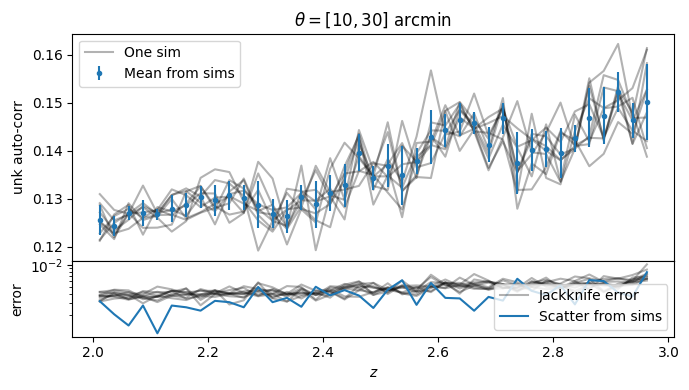

In [52]:
# auto-corr of the unk sample
fig,axarr=pl.subplots(2,1,figsize=[7,4], gridspec_kw={'height_ratios': [3,1]},
                     sharex=True)
   
for jj in range(len(theta_min)):
    
    for ii in range(Nsims):
        if ii == 0:
            label1="One sim"
            label2="Jackknife error"
        else:
            label1=""
            label2=""

        pl.sca(axarr[0])
        pl.plot(z[:-1], w_pp[jj][:-1,ii],color='k',alpha=0.3,label=label1) 
        pl.sca(axarr[1]) 
        pl.plot(z[:-1], w_pp_jn[jj][:-1,ii],color='k',alpha=0.3,label=label2) 
            
    pl.sca(axarr[0])
    pl.errorbar(z[:-1], w_pp_mean[jj][:-1,0], yerr=w_pp_mean[jj][:-1,1], fmt='.', label="Mean from sims")
    pl.title(f"$\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin")
    pl.legend()
    
    pl.sca(axarr[1])
    pl.plot(z[:-1], w_pp_mean[jj][:-1,1], label="Scatter from sims")
    pl.xlabel("$z$")
    pl.legend()
    pl.yscale('log')

pl.sca(axarr[0])
pl.ylabel("unk auto-corr")
#pl.ylim([-0.0015,0.0003])

pl.sca(axarr[1])
pl.ylabel("error")

pl.tight_layout()
pl.subplots_adjust(hspace=0)

In [5]:
# load true redshifts:
fname = "/pscratch/sd/q/qhang/desi-lya/nz-gal-true-z1.8-3.0-all-boxes-40bin.txt"
fin = np.loadtxt(fname)
nz_norm = fin[:-1,1]
nz_edges = fin[:,0]

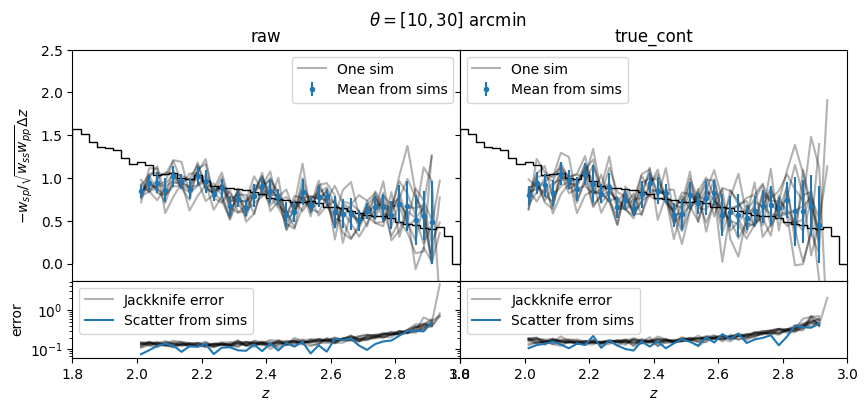

In [57]:
for jj in range(len(theta_min)):

    fig,axarr=pl.subplots(2,2,figsize=[10,4],sharey='row', gridspec_kw={'height_ratios': [3,1]},
                         sharex=True)
    
    pl.suptitle(f"$\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin")
    

    for mm, mode in enumerate(sim_modes):
        for ii in range(Nsims):
            if ii == 0:
                label1="One sim"
                label2="Jackknife error"
            else:
                label1=""
                label2=""
    
            pl.sca(axarr[0, mm])
            pl.plot(z, ncc[mode][jj][:,ii],color='k',alpha=0.3,label=label1) 
            pl.sca(axarr[1,mm]) 
            pl.plot(z, ncc_jn[mode][jj][:,ii],color='k',alpha=0.3,label=label2) 
            
        pl.sca(axarr[0, mm])
        pl.errorbar(z, ncc_mean[mode][jj][:,0], yerr=ncc_mean[mode][jj][:,1], 
                    fmt='.', label="Mean from sims")
        pl.title(mode)
        pl.legend()
        
        pl.sca(axarr[1, mm])
        pl.plot(z, ncc_mean[mode][jj][:,1], label="Scatter from sims")
        pl.xlabel("$z$")
        pl.legend()
        pl.yscale('log')

        pl.sca(axarr[0, mm])
        #pl.plot(nz_sims[:,0], nz_sims[:,1])
        pl.stairs(nz_norm,nz_edges,color='k')
    
    pl.sca(axarr[0,0])
    pl.ylabel("$-w_{sp} / \\sqrt{w_{ss} w_{pp}} \\Delta z$")
    pl.ylim([-0.2, 2.5])
    
    pl.sca(axarr[1,0])
    pl.ylabel("error")
    pl.xlim([1.8,3.0])
    
    pl.subplots_adjust(wspace=0, hspace=0)
    #pl.savefig("../plots/ncc.pdf",bbox_inches="tight")

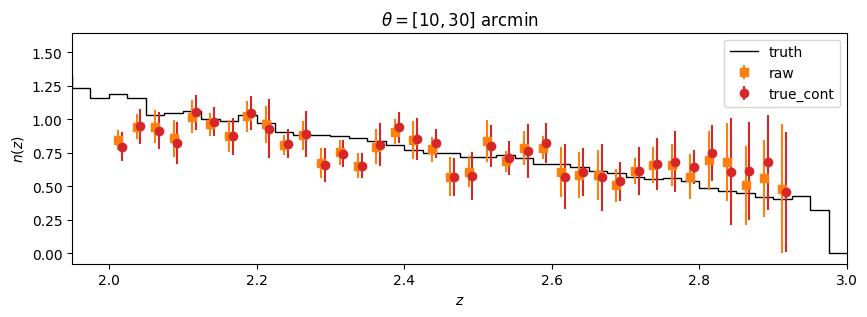

In [6]:
# also produce a plot here with tese measurements on top of each other:
fmt = ['s','o']

for jj in range(len(theta_min)):
    fig,axarr=pl.subplots(figsize=[10,3])
    pl.title(f"$\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin")
    for mm, mode in enumerate(sim_modes):
        pl.errorbar(z+ 0.005*mm, ncc_mean[mode][jj][:,0], yerr=ncc_mean[mode][jj][:,1], 
                    fmt=fmt[mm], label=mode,color=f'C{2*mm+1}')

pl.stairs(nz_norm,nz_edges,color='k',label="truth")
pl.legend()
pl.xlabel("$z$")
#pl.ylim(ylim)
pl.ylabel("$n(z)$")
pl.xlim([1.95,3])

pl.savefig("../plots/ncc-baseline-raw-true_cont.pdf", bbox_inches="tight")

# 5. Comparison: baseline vs. others

1. Impact of mean subtraction and randoms
2. Impact of continuuum fitting methods
3. Impact of contaminants
4. Impact of angular scales
5. Impact of Lya bin size (number of bins)
6. Others

## 5.1 mean subtraction vs. randoms
For now this is run with 20 bins for the LyCAN case, with phot z>1.8. Can run in other configs if needed.

In [2]:
# for 20 bins for now:
root = "/pscratch/sd/q/qhang/desi-lya/results/"

# These settings can be changed later on:
Nbins=20
yaw_tag="-20bin"
Nsims=10
#theta_min=[5,10,15]
#theta_max=[15,30,50]
theta_min = [10]
theta_max = [30]

sim_modes = ['LyCAN_noSNRcut']

In [3]:
w_sp = {}
w_sp_jn = {}
w_sp_norand = {}
w_sp_jn_norand = {}

# different scales:
for mode in sim_modes:
    w_sp[mode] = {}
    w_sp_jn[mode] = {}
    w_sp_norand[mode] = {}
    w_sp_jn_norand[mode] = {}
    for jj, tmin, tmax in zip(np.arange(len(theta_min)),theta_min,theta_max):

        w_sp[mode][jj] = np.zeros((Nbins,Nsims))
        w_sp_jn[mode][jj] = np.zeros((Nbins,Nsims))
        w_sp_norand[mode][jj] = np.zeros((Nbins,Nsims))
        w_sp_jn_norand[mode][jj] = np.zeros((Nbins,Nsims))

        for ii in range(Nsims):
            # ref cross
            fname = root + f"run-{ii}/yaw{yaw_tag}/w_sp-{mode}-theta-min-{tmin}-max-{tmax}.hdf5"
            f = yaw.ScalarCorrFunc.from_file(fname)
            w_sp[mode][jj][:,ii] = (f.sample().data)
            w_sp_jn[mode][jj][:,ii] = (f.sample().error)

            fname = root + f"run-{ii}/yaw{yaw_tag}/w_sp-{mode}-norand-theta-min-{tmin}-max-{tmax}.hdf5"
            f = yaw.ScalarCorrFunc.from_file(fname)
            w_sp_norand[mode][jj][:,ii] = (f.sample().data)
            w_sp_jn_norand[mode][jj][:,ii] = (f.sample().error)
z = (f.binning.mids)

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


In [33]:
a = f.dd.kk_counts.sample_patch_sum().data/f.dd.nn_counts.sample_patch_sum().data

/tmp/ipykernel_659042/4116154397.py:1: RuntimeWarning: invalid value encountered in divide
  a = f.dd.kk_counts.sample_patch_sum().data/f.dd.nn_counts.sample_patch_sum().data


In [32]:
b = f.dr.kk_counts.sample_patch_sum().data/f.dr.nn_counts.sample_patch_sum().data

/tmp/ipykernel_659042/669706229.py:1: RuntimeWarning: invalid value encountered in divide
  b = f.dr.kk_counts.sample_patch_sum().data/f.dr.nn_counts.sample_patch_sum().data


In [34]:
a - b

array([-0.00012643, -0.0001718 , -0.00017353, -0.00024992, -0.00015332,
       -0.00019952, -0.00017596, -0.00022544, -0.00026313, -0.00015259,
       -0.00020847, -0.00023031, -0.000132  , -0.0002205 , -0.00014261,
       -0.00025761, -0.00046228, -0.00031283,  0.0001665 ,         nan])

In [35]:
f.sample().data

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


array([-0.00012643, -0.0001718 , -0.00017353, -0.00024992, -0.00015332,
       -0.00019952, -0.00017596, -0.00022544, -0.00026313, -0.00015259,
       -0.00020847, -0.00023031, -0.000132  , -0.0002205 , -0.00014261,
       -0.00025761, -0.00046228, -0.00031283,  0.0001665 ,         nan])

In [8]:
w_sp_mean = {}
w_sp_norand_mean = {}
for mode in sim_modes:
    w_sp_mean[mode] = {}
    w_sp_norand_mean[mode] = {}
    for jj in range(len(theta_min)):
        w_sp_mean[mode][jj] = np.c_[np.mean(w_sp[mode][jj],axis=1), np.std(w_sp[mode][jj],axis=1)]
        w_sp_norand_mean[mode][jj] = np.c_[np.mean(w_sp_norand[mode][jj],axis=1), np.std(w_sp_norand[mode][jj],axis=1)]

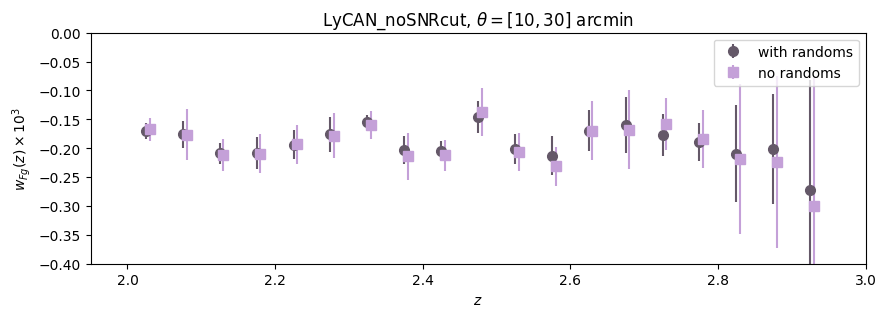

In [17]:
# now plot comparison between the two:

fig,axarr=pl.subplots(figsize=[10,3])
fmt=['o','s']
color=['#645868','#c4a0d8']
label=["with randoms", "no randoms"]

for jj in range(len(theta_min)):
    for mm, mode in enumerate(sim_modes):
        pl.errorbar(z, w_sp_mean[mode][jj][:,0]*1e3, yerr=w_sp_mean[mode][jj][:,1]*1e3, 
                        fmt=fmt[0], label=label[0],color=color[0],markersize=7)
        pl.errorbar(z + 0.005, w_sp_norand_mean[mode][jj][:,0]*1e3, yerr=w_sp_norand_mean[mode][jj][:,1]*1e3, 
                        fmt=fmt[1], label=label[1],color=color[1],markersize=7)
    pl.title(f"{mode}, $\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin")
    
pl.ylabel("$w_{Fg}(z) \\times 10^3$")
pl.xlabel("$z$")
pl.xlim([1.95,3.0])
pl.ylim([-0.4,0])

pl.legend()
#pl.title("Avg. and std. of 10 mocks")
pl.savefig("../plots/w_sp-baseline-lycan-randoms.pdf", bbox_inches="tight")

## 5.2 true_cont vs reconstruction: uncontaminated and LyCAN noSNRcut
Note: this maybe a part of the baseline

In [7]:
root = "/pscratch/sd/q/qhang/desi-lya/results/"

# These settings can be changed later on:
Nbins=40 # change this to 20 later!
Nsims=10
#theta_min=[5,10,15]
#theta_max=[15,30,50]
theta_min = [10]
theta_max = [30]

sim_modes = ['true_cont','uncontaminated','LyCAN_noSNRcut']

In [8]:
w_ss = {}
w_sp = {}
w_pp = {}
ncc = {}
w_ss_jn = {}
w_sp_jn = {}
w_pp_jn = {}
ncc_jn = {}

# different scales:
for mode in sim_modes:
    # mean value
    w_ss[mode]={}
    w_sp[mode]={}
    ncc[mode]={}

    # jn value
    w_ss_jn[mode]={}
    w_sp_jn[mode]={}
    ncc_jn[mode]={}
    for jj, tmin, tmax in zip(np.arange(len(theta_min)),theta_min,theta_max):
        
        w_ss[mode][jj] = np.zeros((Nbins,Nsims))
        w_sp[mode][jj] = np.zeros((Nbins,Nsims))
        ncc[mode][jj] = np.zeros((Nbins,Nsims))
    
        w_ss_jn[mode][jj]  = np.zeros((Nbins,Nsims))
        w_sp_jn[mode][jj]  = np.zeros((Nbins,Nsims))
        ncc_jn[mode][jj]  = np.zeros((Nbins,Nsims))

        if mode == 'raw':
            w_pp[jj] = np.zeros((Nbins,Nsims))
            w_pp_jn[jj] = np.zeros((Nbins,Nsims))

        for ii in range(Nsims):
            # ref auto  
            fname = root + f"run-{ii}/yaw/w_ss-{mode}-theta-min-{tmin}-max-{tmax}.hdf5"
            f = yaw.ScalarCorrFunc.from_file(fname)
            w_ss[mode][jj][:,ii] = (f.sample().data)
            w_ss_jn[mode][jj][:,ii] = (f.sample().error)
    
            # ref cross
            fname = root + f"run-{ii}/yaw/w_sp-{mode}-theta-min-{tmin}-max-{tmax}.hdf5"
            f = yaw.ScalarCorrFunc.from_file(fname)
            w_sp[mode][jj][:,ii] = (f.sample().data)
            w_sp_jn[mode][jj][:,ii] = (f.sample().error)

            if mode == 'raw':
                # unk auto
                fname = root + f"run-{ii}/yaw/w_pp-theta-min-{tmin}-max-{tmax}.hdf5"
                f = yaw.CorrFunc.from_file(fname)
                w_pp[jj][:,ii] = (f.sample().data)
                w_pp_jn[jj][:,ii] = (f.sample().error)

            # result n(z)
            fname = root + f"run-{ii}/yaw/nz_estimate-{mode}-wpp-theta-min-{tmin}-max-{tmax}.dat"
            fin=np.loadtxt(fname)
            ncc[mode][jj][:,ii] = fin[:,1]
            ncc_jn[mode][jj][:,ii] = fin[:,2]
z = (f.binning.mids)

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


In [9]:
w_ss_mean = {}
w_sp_mean = {}
w_pp_mean = {}
ncc_mean = {}
for mode in sim_modes:
    w_ss_mean[mode] = {}
    w_sp_mean[mode] = {}
    ncc_mean[mode] = {}
    for jj in range(len(theta_min)):
        w_ss_mean[mode][jj] = np.c_[np.mean(w_ss[mode][jj],axis=1), np.std(w_ss[mode][jj],axis=1)]
        w_sp_mean[mode][jj] = np.c_[np.mean(w_sp[mode][jj],axis=1), np.std(w_sp[mode][jj],axis=1)]
        ncc_mean[mode][jj] = np.c_[np.mean(ncc[mode][jj],axis=1), np.std(ncc[mode][jj],axis=1)]
        
        if mode == 'raw':
            w_pp_mean[jj] = np.c_[np.mean(w_pp[jj],axis=1), np.std(w_pp[jj],axis=1)]

In [10]:
fname = "/pscratch/sd/q/qhang/desi-lya/nz-gal-true-z1.8-3.0-all-boxes-40bin.txt"
fin = np.loadtxt(fname)
nz_norm = fin[:-1,1]
nz_edges = fin[:,0]

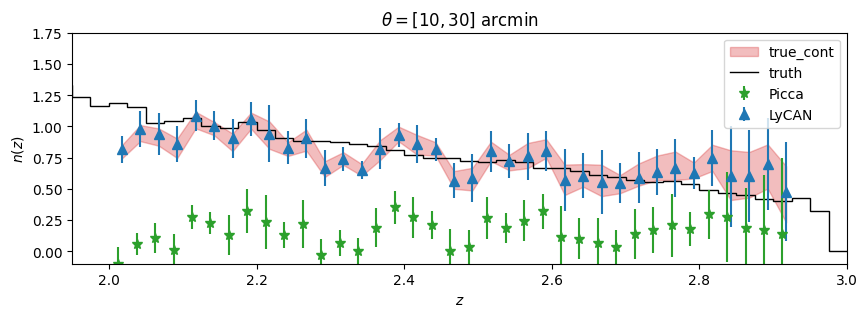

In [11]:
fig,axarr=pl.subplots(figsize=[10,3])
fmt=['*','^']
color=['C2','C0']
label=["Picca", "LyCAN"]

for jj in range(len(theta_min)):
    for mm, mode in enumerate(sim_modes[1:]):
        pl.errorbar(z + 0.005*mm, ncc_mean[mode][jj][:,0], yerr=ncc_mean[mode][jj][:,1], 
                        fmt=fmt[mm], label=label[mm],color=color[mm],markersize=7)
    pl.title(f"$\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin")
    
# plot true continumm:
mode = "true_cont"
y = ncc_mean[mode][jj][:,0]
dy = ncc_mean[mode][jj][:,1]
pl.fill_between(z + 0.005*mm, y-dy/2,y+dy/2, color='C3', alpha=0.3,label=mode)

pl.stairs(nz_norm,nz_edges, color='k', label='truth')

pl.ylabel("$n(z)$")
pl.xlabel("$z$")
pl.xlim([1.95,3.0])
pl.ylim([-0.1,1.75])

pl.legend()
#pl.title("Avg. and std. of 10 mocks")
pl.savefig("../plots/ncc-baseline-picca-lycan.pdf", bbox_inches="tight")

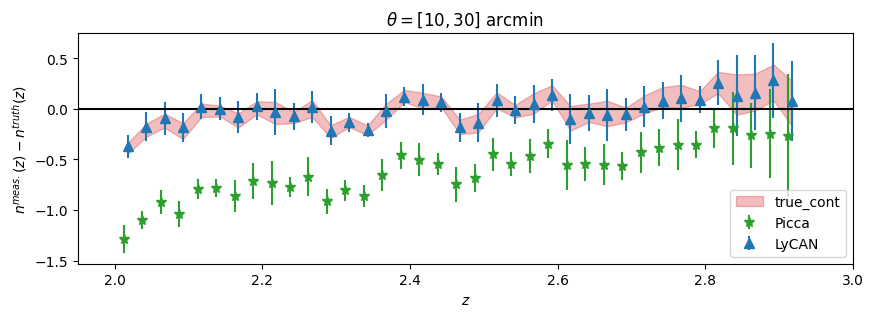

In [99]:
fig,axarr=pl.subplots(figsize=[10,3])
fmt=['*','^']
color=['C2','C0']
label=["Picca", "LyCAN"]

for jj in range(len(theta_min)):
    for mm, mode in enumerate(sim_modes[1:]):
        pl.errorbar(z + 0.005*mm, ncc_mean[mode][jj][:,0]-nz_norm[12:], yerr=ncc_mean[mode][jj][:,1], 
                        fmt=fmt[mm], label=label[mm],color=color[mm],markersize=7)
    pl.title(f"$\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin")
    
# plot true continumm:
mode = "true_cont"
y = ncc_mean[mode][jj][:,0]
dy = ncc_mean[mode][jj][:,1]
pl.fill_between(z + 0.005*mm, y-dy/2-nz_norm[12:],y+dy/2-nz_norm[12:], color='C3', alpha=0.3,label=mode)

pl.plot([1.8,3.0],[0,0],'k-')
#pl.stairs(nz_norm,nz_edges, color='k', label='truth')

pl.ylabel("$n^{meas.}(z) - n^{truth}(z)$")
pl.xlabel("$z$")
pl.xlim([1.95,3.0])
#pl.ylim([-0.1,1.75])

pl.legend()
#pl.title("Avg. and std. of 10 mocks")

## 5.3 Adding contaminants: LyCAN only

In [96]:
root = "/pscratch/sd/q/qhang/desi-lya/results/"

# These settings can be changed later on:
Nbins=40 # change this to 20 later!
Nsims=10
#theta_min=[5,10,15]
#theta_max=[15,30,50]
theta_min = [10]
theta_max = [30]

sim_modes = ['LyCAN_noSNRcut','LyCAN_cont_noSNRcut']

In [97]:
w_ss = {}
w_sp = {}
w_pp = {}
ncc = {}
w_ss_jn = {}
w_sp_jn = {}
w_pp_jn = {}
ncc_jn = {}

# different scales:
for mode in sim_modes:
    # mean value
    w_ss[mode]={}
    w_sp[mode]={}
    ncc[mode]={}

    # jn value
    w_ss_jn[mode]={}
    w_sp_jn[mode]={}
    ncc_jn[mode]={}
    for jj, tmin, tmax in zip(np.arange(len(theta_min)),theta_min,theta_max):
        
        w_ss[mode][jj] = np.zeros((Nbins,Nsims))
        w_sp[mode][jj] = np.zeros((Nbins,Nsims))
        ncc[mode][jj] = np.zeros((Nbins,Nsims))
    
        w_ss_jn[mode][jj]  = np.zeros((Nbins,Nsims))
        w_sp_jn[mode][jj]  = np.zeros((Nbins,Nsims))
        ncc_jn[mode][jj]  = np.zeros((Nbins,Nsims))

        if mode == 'raw':
            w_pp[jj] = np.zeros((Nbins,Nsims))
            w_pp_jn[jj] = np.zeros((Nbins,Nsims))

        for ii in range(Nsims):
            # ref auto  
            fname = root + f"run-{ii}/yaw/w_ss-{mode}-theta-min-{tmin}-max-{tmax}.hdf5"
            f = yaw.ScalarCorrFunc.from_file(fname)
            w_ss[mode][jj][:,ii] = (f.sample().data)
            w_ss_jn[mode][jj][:,ii] = (f.sample().error)
    
            # ref cross
            fname = root + f"run-{ii}/yaw/w_sp-{mode}-theta-min-{tmin}-max-{tmax}.hdf5"
            f = yaw.ScalarCorrFunc.from_file(fname)
            w_sp[mode][jj][:,ii] = (f.sample().data)
            w_sp_jn[mode][jj][:,ii] = (f.sample().error)

            if mode == 'raw':
                # unk auto
                fname = root + f"run-{ii}/yaw/w_pp-theta-min-{tmin}-max-{tmax}.hdf5"
                f = yaw.CorrFunc.from_file(fname)
                w_pp[jj][:,ii] = (f.sample().data)
                w_pp_jn[jj][:,ii] = (f.sample().error)

            # result n(z)
            fname = root + f"run-{ii}/yaw/nz_estimate-{mode}-wpp-theta-min-{tmin}-max-{tmax}.dat"
            fin=np.loadtxt(fname)
            ncc[mode][jj][:,ii] = fin[:,1]
            ncc_jn[mode][jj][:,ii] = fin[:,2]
z = (f.binning.mids)

In [98]:
w_ss_mean = {}
w_sp_mean = {}
w_pp_mean = {}
ncc_mean = {}
for mode in sim_modes:
    w_ss_mean[mode] = {}
    w_sp_mean[mode] = {}
    ncc_mean[mode] = {}
    for jj in range(len(theta_min)):
        w_ss_mean[mode][jj] = np.c_[np.mean(w_ss[mode][jj],axis=1), np.std(w_ss[mode][jj],axis=1)]
        w_sp_mean[mode][jj] = np.c_[np.mean(w_sp[mode][jj],axis=1), np.std(w_sp[mode][jj],axis=1)]
        ncc_mean[mode][jj] = np.c_[np.mean(ncc[mode][jj],axis=1), np.std(ncc[mode][jj],axis=1)]
        
        if mode == 'raw':
            w_pp_mean[jj] = np.c_[np.mean(w_pp[jj],axis=1), np.std(w_pp[jj],axis=1)]

In [99]:
fname = "/pscratch/sd/q/qhang/desi-lya/nz-gal-true-z1.8-3.0-all-boxes-40bin.txt"
fin = np.loadtxt(fname)
nz_norm = fin[:-1,1]
nz_edges = fin[:,0]

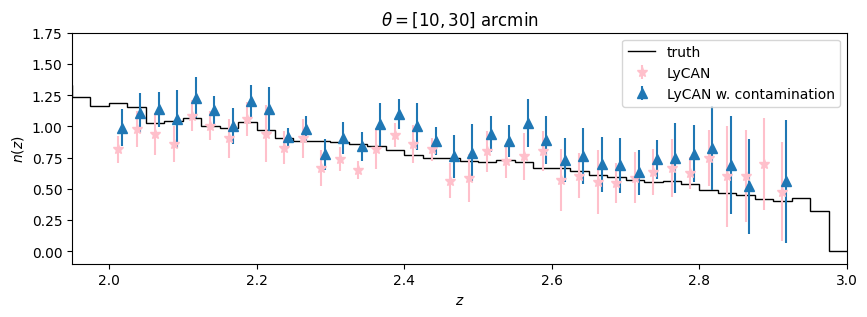

In [60]:
fig,axarr=pl.subplots(figsize=[10,3])
fmt=['*','^']
color=['pink','C0']
label=["LyCAN", "LyCAN w. contamination"]

for jj in range(len(theta_min)):
    for mm, mode in enumerate(sim_modes):
        pl.errorbar(z + 0.005*mm, ncc_mean[mode][jj][:,0], yerr=ncc_mean[mode][jj][:,1], 
                        fmt=fmt[mm], label=label[mm],color=color[mm],markersize=7)
    pl.title(f"$\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin")

pl.stairs(nz_norm,nz_edges, color='k', label='truth')

pl.ylabel("$n(z)$")
pl.xlabel("$z$")
pl.xlim([1.95,3.0])
pl.ylim([-0.1,1.75])

pl.legend()
#pl.title("Avg. and std. of 10 mocks")
#pl.savefig("../plots/ncc-baseline-picca-lycan.pdf", bbox_inches="tight")

(-0.0005, 0.0)

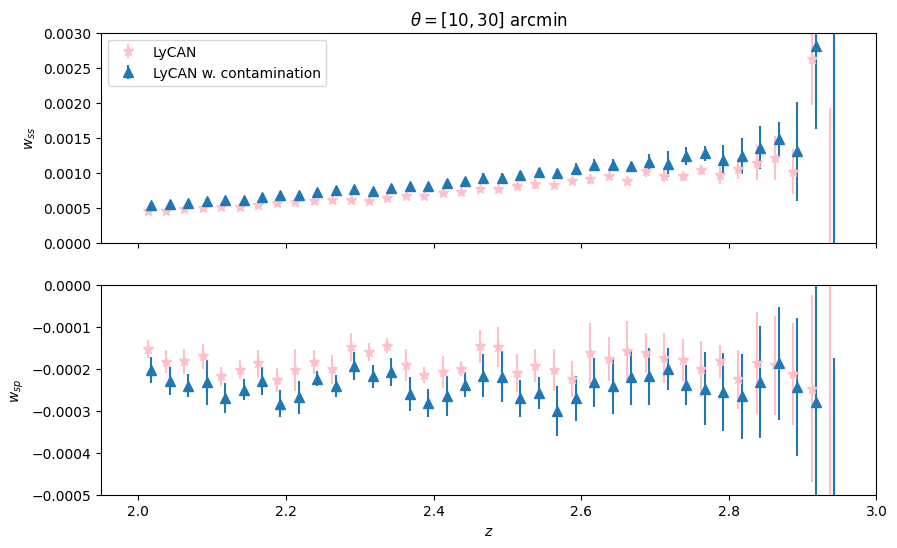

In [19]:
# let's also compare the Lya auto-correlations and the cross-correlation measurements:
fig,axarr=pl.subplots(2, figsize=[10,6],sharex=True)
fmt=['*','^']
color=['pink','C0']
label=["LyCAN", "LyCAN w. contamination"]

for jj in range(len(theta_min)):
    for mm, mode in enumerate(sim_modes):
        pl.sca(axarr[0])
        pl.errorbar(z + 0.005*mm, w_ss_mean[mode][jj][:,0], yerr=w_ss_mean[mode][jj][:,1], 
                        fmt=fmt[mm], label=label[mm],color=color[mm],markersize=7)
        pl.sca(axarr[1])
        pl.errorbar(z + 0.005*mm, w_sp_mean[mode][jj][:,0], yerr=w_sp_mean[mode][jj][:,1], 
                        fmt=fmt[mm], label=label[mm],color=color[mm],markersize=7)
    pl.sca(axarr[0])           
    pl.title(f"$\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin")

pl.sca(axarr[0])
pl.ylabel("$w_{ss}$")
pl.ylim([-0.000,0.003])
pl.legend()
pl.sca(axarr[1])
pl.ylabel("$w_{sp}$")
pl.xlabel("$z$")
pl.xlim([1.95,3.0])
pl.ylim([-0.0005,0])

In [100]:
# we can work out the amplitude to normalize the redshift distribution:
for mm, mode in enumerate(sim_modes):
    y = ncc_mean[mode][0][:,0]/nz_norm[-40:]
    dy = ncc_mean[mode][0][:,1]/nz_norm[-40:]
    ind = ~np.isnan(y)
    res = np.polyfit(z[ind][1:],y[ind][1:],0,w=1/dy[ind][1:],cov=True)
    print(mode, res[0], np.sqrt(np.diag(res[1])))

LyCAN_noSNRcut [0.94804936] [0.02369016]
LyCAN_cont_noSNRcut [1.10691057] [0.02169398]


In [89]:
# 20 bin case

root = "/pscratch/sd/q/qhang/desi-lya/results/"

# These settings can be changed later on:
Nbins=20 # change this to 20 later!
Nsims=10
#theta_min=[5,10,15]
#theta_max=[15,30,50]
theta_min = [10]
theta_max = [30]

sim_modes = ['LyCAN_noSNRcut','LyCAN_cont_noSNRcut']

In [90]:
w_ss = {}
w_sp = {}
w_pp = {}
ncc = {}
w_ss_jn = {}
w_sp_jn = {}
w_pp_jn = {}
ncc_jn = {}

# different scales:
for mode in sim_modes:
    # mean value
    w_ss[mode]={}
    w_sp[mode]={}
    ncc[mode]={}

    # jn value
    w_ss_jn[mode]={}
    w_sp_jn[mode]={}
    ncc_jn[mode]={}
    for jj, tmin, tmax in zip(np.arange(len(theta_min)),theta_min,theta_max):
        
        w_ss[mode][jj] = np.zeros((Nbins,Nsims))
        w_sp[mode][jj] = np.zeros((Nbins,Nsims))
        ncc[mode][jj] = np.zeros((Nbins,Nsims))
    
        w_ss_jn[mode][jj]  = np.zeros((Nbins,Nsims))
        w_sp_jn[mode][jj]  = np.zeros((Nbins,Nsims))
        ncc_jn[mode][jj]  = np.zeros((Nbins,Nsims))

        if mode == 'raw':
            w_pp[jj] = np.zeros((Nbins,Nsims))
            w_pp_jn[jj] = np.zeros((Nbins,Nsims))

        for ii in range(Nsims):
            # ref auto  
            fname = root + f"run-{ii}/yaw-20bin/w_ss-{mode}-theta-min-{tmin}-max-{tmax}.hdf5"
            f = yaw.ScalarCorrFunc.from_file(fname)
            w_ss[mode][jj][:,ii] = (f.sample().data)
            w_ss_jn[mode][jj][:,ii] = (f.sample().error)
    
            # ref cross
            fname = root + f"run-{ii}/yaw-20bin/w_sp-{mode}-theta-min-{tmin}-max-{tmax}.hdf5"
            f = yaw.ScalarCorrFunc.from_file(fname)
            w_sp[mode][jj][:,ii] = (f.sample().data)
            w_sp_jn[mode][jj][:,ii] = (f.sample().error)

            if mode == 'raw':
                # unk auto
                fname = root + f"run-{ii}/yaw-20bin/w_pp-theta-min-{tmin}-max-{tmax}.hdf5"
                f = yaw.CorrFunc.from_file(fname)
                w_pp[jj][:,ii] = (f.sample().data)
                w_pp_jn[jj][:,ii] = (f.sample().error)

            # result n(z)
            fname = root + f"run-{ii}/yaw-20bin/nz_estimate-{mode}-wpp-theta-min-{tmin}-max-{tmax}.dat"
            fin=np.loadtxt(fname)
            ncc[mode][jj][:,ii] = fin[:,1]
            ncc_jn[mode][jj][:,ii] = fin[:,2]
z = (f.binning.mids)

In [91]:
w_ss_mean = {}
w_sp_mean = {}
w_pp_mean = {}
ncc_mean = {}
for mode in sim_modes:
    w_ss_mean[mode] = {}
    w_sp_mean[mode] = {}
    ncc_mean[mode] = {}
    for jj in range(len(theta_min)):
        w_ss_mean[mode][jj] = np.c_[np.mean(w_ss[mode][jj],axis=1), np.std(w_ss[mode][jj],axis=1)]
        w_sp_mean[mode][jj] = np.c_[np.mean(w_sp[mode][jj],axis=1), np.std(w_sp[mode][jj],axis=1)]
        ncc_mean[mode][jj] = np.c_[np.mean(ncc[mode][jj],axis=1), np.std(ncc[mode][jj],axis=1)]
        
        if mode == 'raw':
            w_pp_mean[jj] = np.c_[np.mean(w_pp[jj],axis=1), np.std(w_pp[jj],axis=1)]

In [92]:
fname = "/pscratch/sd/q/qhang/desi-lya/nz-gal-true-z1.8-3.0-all-boxes-20bin.txt"
fin = np.loadtxt(fname)
nz_norm = fin[:-1,1]
nz_edges = fin[:,0]

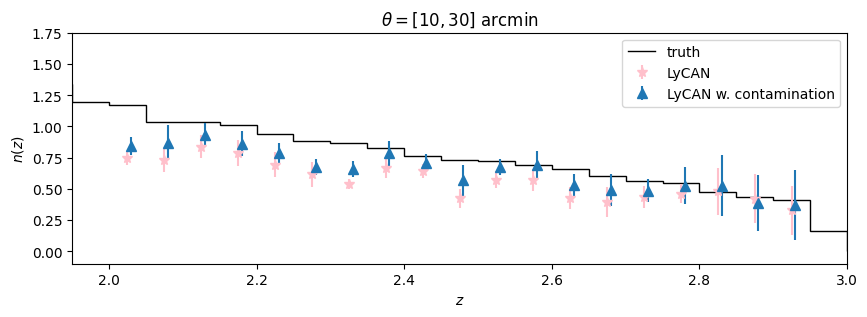

In [93]:
fig,axarr=pl.subplots(figsize=[10,3])
fmt=['*','^']
color=['pink','C0']
label=["LyCAN", "LyCAN w. contamination"]

for jj in range(len(theta_min)):
    for mm, mode in enumerate(sim_modes):
        pl.errorbar(z + 0.005*mm, ncc_mean[mode][jj][:,0], yerr=ncc_mean[mode][jj][:,1], 
                        fmt=fmt[mm], label=label[mm],color=color[mm],markersize=7)
    pl.title(f"$\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin")

pl.stairs(nz_norm,nz_edges, color='k', label='truth')

pl.ylabel("$n(z)$")
pl.xlabel("$z$")
pl.xlim([1.95,3.0])
pl.ylim([-0.1,1.75])

pl.legend()
#pl.title("Avg. and std. of 10 mocks")
#pl.savefig("../plots/ncc-baseline-picca-lycan.pdf", bbox_inches="tight")

In [95]:
# we can work out the amplitude to normalize the redshift distribution:
for mm, mode in enumerate(sim_modes):
    y = ncc_mean[mode][0][:,0]/nz_norm[-20:]
    dy = ncc_mean[mode][0][:,1]/nz_norm[-20:]
    ind = ~np.isnan(y)
    res = np.polyfit(z[ind][1:],y[ind][1:],0,w=1/dy[ind][1:],cov=True)
    print(mode, res[0], np.sqrt(np.diag(res[1])))

LyCAN_noSNRcut [0.72530045] [0.02227939]
LyCAN_cont_noSNRcut [0.84776221] [0.01768638]


## 5.4 Impact of scales: show three scales
Below demonstrate using LyCAN only?

In [12]:
root = "/pscratch/sd/q/qhang/desi-lya/results/"

# These settings can be changed later on:
Nbins=40 # change this to 20 later!
Nsims=10
theta_min=[5,10,15]
theta_max=[15,30,50]

sim_modes = ['LyCAN_noSNRcut']

In [13]:
w_ss = {}
w_sp = {}
w_pp = {}
ncc = {}
w_ss_jn = {}
w_sp_jn = {}
w_pp_jn = {}
ncc_jn = {}

# different scales:
for mode in sim_modes:
    # mean value
    w_ss[mode]={}
    w_sp[mode]={}
    ncc[mode]={}

    # jn value
    w_ss_jn[mode]={}
    w_sp_jn[mode]={}
    ncc_jn[mode]={}
    for jj, tmin, tmax in zip(np.arange(len(theta_min)),theta_min,theta_max):
        
        w_ss[mode][jj] = np.zeros((Nbins,Nsims))
        w_sp[mode][jj] = np.zeros((Nbins,Nsims))
        ncc[mode][jj] = np.zeros((Nbins,Nsims))
    
        w_ss_jn[mode][jj]  = np.zeros((Nbins,Nsims))
        w_sp_jn[mode][jj]  = np.zeros((Nbins,Nsims))
        ncc_jn[mode][jj]  = np.zeros((Nbins,Nsims))

        if mode == 'raw':
            w_pp[jj] = np.zeros((Nbins,Nsims))
            w_pp_jn[jj] = np.zeros((Nbins,Nsims))

        for ii in range(Nsims):
            # ref auto  
            fname = root + f"run-{ii}/yaw/w_ss-{mode}-theta-min-{tmin}-max-{tmax}.hdf5"
            f = yaw.ScalarCorrFunc.from_file(fname)
            w_ss[mode][jj][:,ii] = (f.sample().data)
            w_ss_jn[mode][jj][:,ii] = (f.sample().error)
    
            # ref cross
            fname = root + f"run-{ii}/yaw/w_sp-{mode}-theta-min-{tmin}-max-{tmax}.hdf5"
            f = yaw.ScalarCorrFunc.from_file(fname)
            w_sp[mode][jj][:,ii] = (f.sample().data)
            w_sp_jn[mode][jj][:,ii] = (f.sample().error)

            if mode == 'raw':
                # unk auto
                fname = root + f"run-{ii}/yaw/w_pp-theta-min-{tmin}-max-{tmax}.hdf5"
                f = yaw.CorrFunc.from_file(fname)
                w_pp[jj][:,ii] = (f.sample().data)
                w_pp_jn[jj][:,ii] = (f.sample().error)

            # result n(z)
            fname = root + f"run-{ii}/yaw/nz_estimate-{mode}-wpp-theta-min-{tmin}-max-{tmax}.dat"
            fin=np.loadtxt(fname)
            ncc[mode][jj][:,ii] = fin[:,1]
            ncc_jn[mode][jj][:,ii] = fin[:,2]
z = (f.binning.mids)

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


In [14]:
w_ss_mean = {}
w_sp_mean = {}
w_pp_mean = {}
ncc_mean = {}
for mode in sim_modes:
    w_ss_mean[mode] = {}
    w_sp_mean[mode] = {}
    ncc_mean[mode] = {}
    for jj in range(len(theta_min)):
        w_ss_mean[mode][jj] = np.c_[np.mean(w_ss[mode][jj],axis=1), np.std(w_ss[mode][jj],axis=1)]
        w_sp_mean[mode][jj] = np.c_[np.mean(w_sp[mode][jj],axis=1), np.std(w_sp[mode][jj],axis=1)]
        ncc_mean[mode][jj] = np.c_[np.mean(ncc[mode][jj],axis=1), np.std(ncc[mode][jj],axis=1)]
        
        if mode == 'raw':
            w_pp_mean[jj] = np.c_[np.mean(w_pp[jj],axis=1), np.std(w_pp[jj],axis=1)]

In [15]:
fname = "/pscratch/sd/q/qhang/desi-lya/nz-gal-true-z1.8-3.0-all-boxes-40bin.txt"
fin = np.loadtxt(fname)
nz_norm = fin[:-1,1]
nz_edges = fin[:,0]

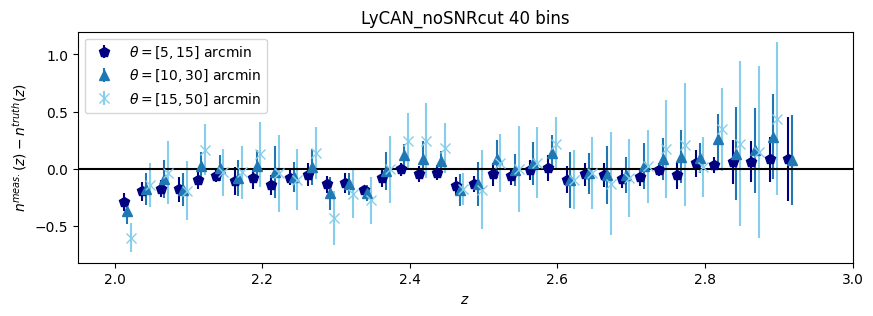

In [16]:
fig,axarr=pl.subplots(figsize=[10,3])
fmt=['p','^','x']
color=['navy','C0','skyblue']
#label=["Picca", "LyCAN"]

for jj in range(len(theta_min)):
    label = f"$\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin"
    for mm, mode in enumerate(sim_modes):
        pl.errorbar(z + 0.005*jj, ncc_mean[mode][jj][:,0]-nz_norm[12:], yerr=ncc_mean[mode][jj][:,1], 
                        fmt=fmt[jj], label=label,color=color[jj],markersize=7)
pl.title(mode + f" {Nbins} bins")

"""
# plot baseline LyCAN
mode = "LyCAN_noSNRcut"
y = ncc_mean[mode][jj][:,0]
dy = ncc_mean[mode][jj][:,1]
pl.fill_between(z + 0.005*mm, y-dy/2-nz_norm[12:],y+dy/2-nz_norm[12:], color='C0', alpha=0.3,label=mode)
"""

pl.plot([1.8,3.0],[0,0],'k-')
#pl.stairs(nz_norm,nz_edges, color='k', label='truth')

pl.ylabel("$n^{meas.}(z) - n^{truth}(z)$")
pl.xlabel("$z$")
pl.xlim([1.95,3.0])
#pl.ylim([-0.1,1.75])

pl.legend(loc='upper left')
#pl.title("Avg. and std. of 10 mocks")
pl.savefig("../plots/ncc-scales-40bin-lycan.pdf", bbox_inches="tight")

## 5.5 Bin size

In [71]:
# load both 20 bins and 40 bins:
root = "/pscratch/sd/q/qhang/desi-lya/results/"

# These settings can be changed later on:
Nbins=[40,20]
Nsims=10
#theta_min=[5,10,15]
#theta_max=[15,30,50]
theta_min = [10,15]
theta_max = [30,50]

sim_modes = ['raw','true_cont','LyCAN_noSNRcut']

In [72]:
w_ss = {}
w_sp = {}
w_pp = {}
ncc = {}
w_ss_jn = {}
w_sp_jn = {}
w_pp_jn = {}
ncc_jn = {}
z = {}

# different scales:
for nbin in Nbins:
    if nbin == 40:
        yaw_tag = ""
    elif nbin == 20:
        yaw_tag = "-20bin"
    # mean value
    w_ss[nbin]={}
    w_sp[nbin]={}
    ncc[nbin]={}
    w_pp[nbin]={}

    # jn value
    w_ss_jn[nbin]={}
    w_sp_jn[nbin]={}
    ncc_jn[nbin]={}
    w_pp_jn[nbin]={}
    
    for mode in sim_modes:
        # mean value
        w_ss[nbin][mode]={}
        w_sp[nbin][mode]={}
        ncc[nbin][mode]={}
    
        # jn value
        w_ss_jn[nbin][mode]={}
        w_sp_jn[nbin][mode]={}
        ncc_jn[nbin][mode]={}
        for jj, tmin, tmax in zip(np.arange(len(theta_min)),theta_min,theta_max):
            
            w_ss[nbin][mode][jj] = np.zeros((nbin,Nsims))
            w_sp[nbin][mode][jj] = np.zeros((nbin,Nsims))
            ncc[nbin][mode][jj] = np.zeros((nbin,Nsims))
        
            w_ss_jn[nbin][mode][jj]  = np.zeros((nbin,Nsims))
            w_sp_jn[nbin][mode][jj]  = np.zeros((nbin,Nsims))
            ncc_jn[nbin][mode][jj]  = np.zeros((nbin,Nsims))
    
            if mode == sim_modes[0]:
                w_pp[nbin][jj] = np.zeros((nbin,Nsims))
                w_pp_jn[nbin][jj] = np.zeros((nbin,Nsims))
    
            for ii in range(Nsims):
                # ref auto  
                fname = root + f"run-{ii}/yaw{yaw_tag}/w_ss-{mode}-theta-min-{tmin}-max-{tmax}.hdf5"
                f = yaw.ScalarCorrFunc.from_file(fname)
                w_ss[nbin][mode][jj][:,ii] = (f.sample().data)
                w_ss_jn[nbin][mode][jj][:,ii] = (f.sample().error)
        
                # ref cross
                fname = root + f"run-{ii}/yaw{yaw_tag}/w_sp-{mode}-theta-min-{tmin}-max-{tmax}.hdf5"
                f = yaw.ScalarCorrFunc.from_file(fname)
                w_sp[nbin][mode][jj][:,ii] = (f.sample().data)
                w_sp_jn[nbin][mode][jj][:,ii] = (f.sample().error)
    
                if mode == sim_modes[0]:
                    # unk auto
                    fname = root + f"run-{ii}/yaw{yaw_tag}/w_pp-theta-min-{tmin}-max-{tmax}.hdf5"
                    f = yaw.CorrFunc.from_file(fname)
                    w_pp[nbin][jj][:,ii] = (f.sample().data)
                    w_pp_jn[nbin][jj][:,ii] = (f.sample().error)
    
                # result n(z)
                fname = root + f"run-{ii}/yaw{yaw_tag}/nz_estimate-{mode}-wpp-theta-min-{tmin}-max-{tmax}.dat"
                fin=np.loadtxt(fname)
                ncc[nbin][mode][jj][:,ii] = fin[:,1]
                ncc_jn[nbin][mode][jj][:,ii] = fin[:,2]
    z[nbin] = (f.binning.mids)

In [73]:
w_ss_mean = {}
w_sp_mean = {}
w_pp_mean = {}
ncc_mean = {}

for nbin in Nbins:
    w_ss_mean[nbin] = {}
    w_sp_mean[nbin] = {}
    ncc_mean[nbin] = {}
    w_pp_mean[nbin] = {}
    for mode in sim_modes:
        w_ss_mean[nbin][mode] = {}
        w_sp_mean[nbin][mode] = {}
        ncc_mean[nbin][mode] = {}
        for jj in range(len(theta_min)):
            w_ss_mean[nbin][mode][jj] = np.c_[np.mean(w_ss[nbin][mode][jj],axis=1), np.std(w_ss[nbin][mode][jj],axis=1)]
            w_sp_mean[nbin][mode][jj] = np.c_[np.mean(w_sp[nbin][mode][jj],axis=1), np.std(w_sp[nbin][mode][jj],axis=1)]
            ncc_mean[nbin][mode][jj] = np.c_[np.mean(ncc[nbin][mode][jj],axis=1), np.std(ncc[nbin][mode][jj],axis=1)]
            
            if mode == sim_modes[0]:
                w_pp_mean[nbin][jj] = np.c_[np.mean(w_pp[nbin][jj],axis=1), np.std(w_pp[nbin][jj],axis=1)]

In [74]:
nz_norm = {}
nz_edges={}

for nbin in Nbins:
    fname = f"/pscratch/sd/q/qhang/desi-lya/nz-gal-true-z1.8-3.0-all-boxes-{nbin}bin.txt"
    fin = np.loadtxt(fname)
    nz_norm[nbin] = fin[:-1,1]
    nz_edges[nbin] = fin[:,0]

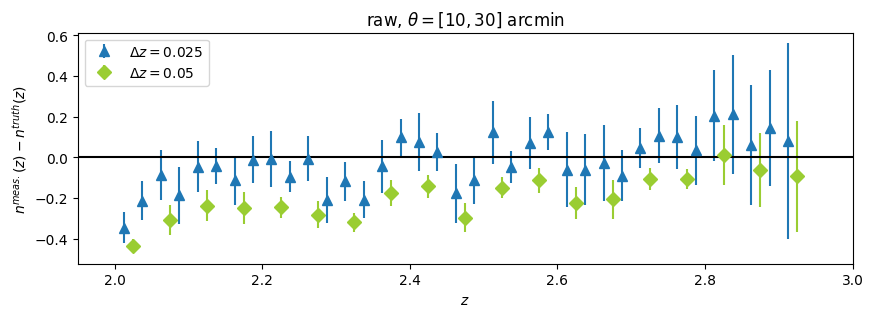

In [27]:
fig,axarr=pl.subplots(figsize=[10,3])
fmt=['^','D']
color=['C0','yellowgreen']
#label=["Picca", "LyCAN"]

for jj in range(len(Nbins)):
    nbin = Nbins[jj]
    if nbin == 20:
        label = "$\\Delta z = 0.05$"
    else:
        label = "$\\Delta z = 0.025$"
    for mm, mode in enumerate(sim_modes[:1]):
        pl.errorbar(z[nbin], ncc_mean[nbin][mode][0][:,0]-nz_norm[nbin][-nbin:], yerr=ncc_mean[nbin][mode][0][:,1], 
                        fmt=fmt[jj], label=label,color=color[jj],markersize=7)
pl.title(mode + ", " + f"$\\theta = [{theta_min[0]}, {theta_max[0]}]$ arcmin")

pl.plot([1.8,3.0],[0,0],'k-')
#pl.stairs(nz_norm,nz_edges, color='k', label='truth')

pl.ylabel("$n^{meas.}(z) - n^{truth}(z)$")
pl.xlabel("$z$")
pl.xlim([1.95,3.0])
#pl.ylim([-0.1,1.75])

pl.legend(loc='upper left')
#pl.title("Avg. and std. of 10 mocks")
#pl.savefig("../plots/ncc-nbins-theta-10-30-lycan.pdf", bbox_inches="tight")

In [54]:
# fit curve:
mode = 'raw'
for nbin in Nbins:
    x=z[nbin]
    y = ncc_mean[nbin][mode][0][:,0]/nz_norm[nbin][-nbin:]
    dy = ncc_mean[nbin][mode][0][:,1]/nz_norm[nbin][-nbin:]
    ind = ~np.isnan(y)
    res = np.polyfit(x[ind],y[ind],0,w=1/dy[ind],cov=True)
    print(nbin, res[0], np.sqrt(np.diag(res[1])))

40 [0.91139981] [0.02261789]
20 [0.70260596] [0.01835492]


Note the offset in 20 bin case, but not 40 bins

(-0.0004, 0.0)

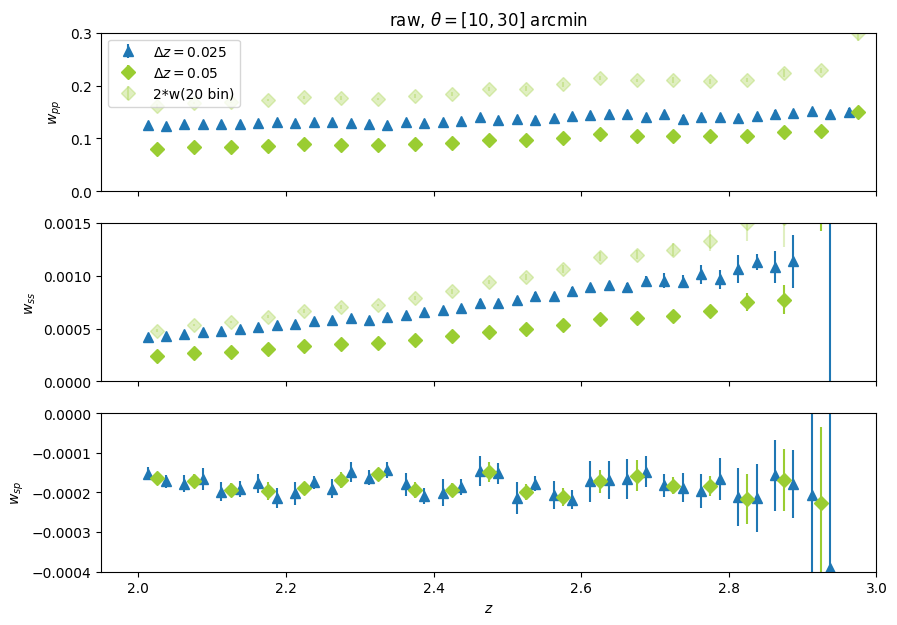

In [83]:
# let's also compare the Lya + galaxy auto-correlation and the cross-correlation measurements:
fig,axarr=pl.subplots(3, figsize=[10,7],sharex=True)
fmt=['^','D']
color=['C0','yellowgreen']
#label=["LyCAN", "LyCAN w. contamination"]

jj=0
for nn, nbin in enumerate(Nbins):
    if nbin == 20:
        label = "$\\Delta z = 0.05$"
    else:
        label = "$\\Delta z = 0.025$"
    for mm, mode in enumerate(sim_modes[:1]):
        pl.sca(axarr[0])
        pl.errorbar(z[nbin], w_pp_mean[nbin][jj][:,0], yerr= w_pp_mean[nbin][jj][:,1], 
                    fmt=fmt[nn], label=label,color=color[nn],markersize=7)
        pl.sca(axarr[1])
        pl.errorbar(z[nbin], w_ss_mean[nbin][mode][jj][:,0], yerr=w_ss_mean[nbin][mode][jj][:,1], 
                        fmt=fmt[nn], label=label,color=color[nn],markersize=7)
        pl.sca(axarr[2])
        pl.errorbar(z[nbin], w_sp_mean[nbin][mode][jj][:,0], yerr=w_sp_mean[nbin][mode][jj][:,1], 
                        fmt=fmt[nn], label=label,color=color[nn],markersize=7)
    pl.sca(axarr[0])
    pl.title(f"{mode}, $\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin")

# plot 2* w for 20 bin case:
pl.sca(axarr[0])
pl.ylabel("$w_{pp}$")
pl.ylim([0,0.3])
nbin=20
nn=1
pl.errorbar(z[nbin], w_pp_mean[nbin][jj][:,0]*2, yerr= w_pp_mean[nbin][jj][:,1]*2, 
                    fmt=fmt[nn], label="2*w(20 bin)",color=color[nn],markersize=7, alpha=0.3)
pl.legend()

pl.sca(axarr[1])
pl.ylabel("$w_{ss}$")
pl.ylim([0,0.0015])
nbin=20
nn=1
pl.errorbar(z[nbin], w_ss_mean[nbin][mode][jj][:,0]*2, yerr= w_ss_mean[nbin][mode][jj][:,1]*2, 
                    fmt=fmt[nn], label="2*w(20 bin)",color=color[nn],markersize=7, alpha=0.3)

pl.sca(axarr[2])
pl.ylabel("$w_{sp}$")
pl.xlabel("$z$")
pl.xlim([1.95,3.0])
pl.ylim([-0.0004,0])

(-1.0, 1.0)

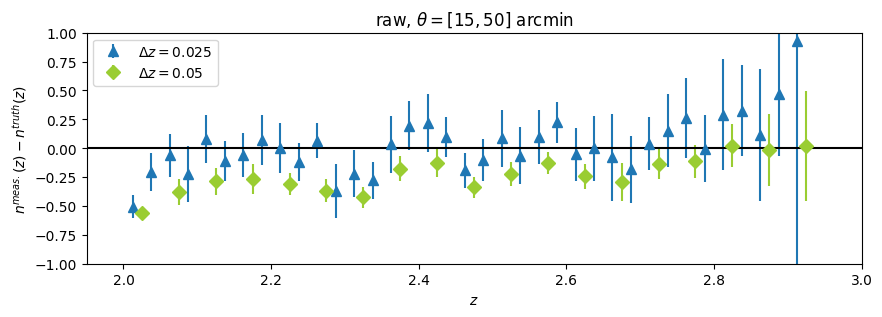

In [77]:
# show a different scale:
fig,axarr=pl.subplots(figsize=[10,3])
fmt=['^','D']
color=['C0','yellowgreen']
tt = 1

for jj in range(len(Nbins)):
    nbin = Nbins[jj]
    if nbin == 20:
        label = "$\\Delta z = 0.05$"
    else:
        label = "$\\Delta z = 0.025$"
    for mm, mode in enumerate(sim_modes[:1]):
        pl.errorbar(z[nbin], ncc_mean[nbin][mode][tt][:,0]-nz_norm[nbin][-nbin:], yerr=ncc_mean[nbin][mode][tt][:,1], 
                        fmt=fmt[jj], label=label,color=color[jj],markersize=7)
pl.title(mode + ", " + f"$\\theta = [{theta_min[tt]}, {theta_max[tt]}]$ arcmin")

pl.plot([1.8,3.0],[0,0],'k-')
#pl.stairs(nz_norm,nz_edges, color='k', label='truth')

pl.ylabel("$n^{meas.}(z) - n^{truth}(z)$")
pl.xlabel("$z$")
pl.xlim([1.95,3.0])
#pl.ylim([-0.1,1.75])

pl.legend(loc='upper left')
#pl.title("Avg. and std. of 10 mocks")
#pl.savefig("../plots/ncc-nbins-theta-10-30-lycan.pdf", bbox_inches="tight")
pl.ylim([-1,1])

In [79]:
# fit curve:
mode = 'raw'
tt=1
for nbin in Nbins:
    x=z[nbin]
    y = ncc_mean[nbin][mode][tt][:,0]/nz_norm[nbin][-nbin:]
    dy = ncc_mean[nbin][mode][tt][:,1]/nz_norm[nbin][-nbin:]
    ind = ~np.isnan(y)
    res = np.polyfit(x[ind][1:],y[ind][1:],0,w=1/dy[ind][1:],cov=True)
    print(nbin, res[0], np.sqrt(np.diag(res[1])))

40 [0.94655297] [0.03139863]
20 [0.67092494] [0.02571132]


## 5.6 Realstic signal-to-noise (shape of the unknown n(z))

SNR nz

In [12]:
nz_norm = {}
nz_edges = {}

for nbin in Nbins:
    nztrue_SRD = np.loadtxt(f"/pscratch/sd/q/qhang/desi-lya/nz-gal-true-SRD_nz-z0-3-all-boxes-{nbin}bin.txt")
    nz_norm[nbin] = nztrue_SRD[:-1,1]
    nz_edges[nbin] = nztrue_SRD[:,0]

In [7]:
root = "/pscratch/sd/q/qhang/desi-lya/results/"
Nbins=[40,20]
Nsims=10
sim_modes = ["LyCAN_noSNRcut"]
#theta_min=[5,10,15]
#theta_max=[15,30,50]
theta_min = [10]
theta_max = [30]
yaw_tag = "-20bin-SRD_nz"

In [8]:
w_ss = {}
w_sp = {}
w_pp = {}
ncc = {}
w_ss_jn = {}
w_sp_jn = {}
w_pp_jn = {}
ncc_jn = {}
z = {}

# different scales:
for nbin in Nbins:
    if nbin == 40:
        yaw_tag = "-SRD_nz"
    elif nbin == 20:
        yaw_tag = "-20bin-SRD_nz"
    # mean value
    w_ss[nbin]={}
    w_sp[nbin]={}
    ncc[nbin]={}
    w_pp[nbin]={}

    # jn value
    w_ss_jn[nbin]={}
    w_sp_jn[nbin]={}
    ncc_jn[nbin]={}
    w_pp_jn[nbin]={}
    
    for mode in sim_modes:
        # mean value
        w_ss[nbin][mode]={}
        w_sp[nbin][mode]={}
        ncc[nbin][mode]={}
    
        # jn value
        w_ss_jn[nbin][mode]={}
        w_sp_jn[nbin][mode]={}
        ncc_jn[nbin][mode]={}
        for jj, tmin, tmax in zip(np.arange(len(theta_min)),theta_min,theta_max):
            
            w_ss[nbin][mode][jj] = np.zeros((nbin,Nsims))
            w_sp[nbin][mode][jj] = np.zeros((nbin,Nsims))
            ncc[nbin][mode][jj] = np.zeros((nbin,Nsims))
        
            w_ss_jn[nbin][mode][jj]  = np.zeros((nbin,Nsims))
            w_sp_jn[nbin][mode][jj]  = np.zeros((nbin,Nsims))
            ncc_jn[nbin][mode][jj]  = np.zeros((nbin,Nsims))
    
            if mode == sim_modes[0]:
                w_pp[nbin][jj] = np.zeros((nbin,Nsims))
                w_pp_jn[nbin][jj] = np.zeros((nbin,Nsims))
    
            for ii in range(Nsims):
                # ref auto  
                fname = root + f"run-{ii}/yaw{yaw_tag}/w_ss-{mode}-theta-min-{tmin}-max-{tmax}.hdf5"
                f = yaw.ScalarCorrFunc.from_file(fname)
                w_ss[nbin][mode][jj][:,ii] = (f.sample().data)
                w_ss_jn[nbin][mode][jj][:,ii] = (f.sample().error)
        
                # ref cross
                fname = root + f"run-{ii}/yaw{yaw_tag}/w_sp-{mode}-theta-min-{tmin}-max-{tmax}.hdf5"
                f = yaw.ScalarCorrFunc.from_file(fname)
                w_sp[nbin][mode][jj][:,ii] = (f.sample().data)
                w_sp_jn[nbin][mode][jj][:,ii] = (f.sample().error)
    
                if mode == sim_modes[0]:
                    # unk auto
                    fname = root + f"run-{ii}/yaw{yaw_tag}/w_pp-theta-min-{tmin}-max-{tmax}.hdf5"
                    f = yaw.CorrFunc.from_file(fname)
                    w_pp[nbin][jj][:,ii] = (f.sample().data)
                    w_pp_jn[nbin][jj][:,ii] = (f.sample().error)
    
                # result n(z)
                fname = root + f"run-{ii}/yaw{yaw_tag}/nz_estimate-{mode}-wpp-theta-min-{tmin}-max-{tmax}.dat"
                fin=np.loadtxt(fname)
                ncc[nbin][mode][jj][:,ii] = fin[:,1]
                ncc_jn[nbin][mode][jj][:,ii] = fin[:,2]
    z[nbin] = (f.binning.mids)

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


In [9]:
w_ss_mean = {}
w_sp_mean = {}
w_pp_mean = {}
ncc_mean = {}

for nbin in Nbins:
    w_ss_mean[nbin] = {}
    w_sp_mean[nbin] = {}
    ncc_mean[nbin] = {}
    w_pp_mean[nbin] = {}
    for mode in sim_modes:
        w_ss_mean[nbin][mode] = {}
        w_sp_mean[nbin][mode] = {}
        ncc_mean[nbin][mode] = {}
        for jj in range(len(theta_min)):
            w_ss_mean[nbin][mode][jj] = np.c_[np.mean(w_ss[nbin][mode][jj],axis=1), np.std(w_ss[nbin][mode][jj],axis=1)]
            w_sp_mean[nbin][mode][jj] = np.c_[np.mean(w_sp[nbin][mode][jj],axis=1), np.std(w_sp[nbin][mode][jj],axis=1)]
            ncc_mean[nbin][mode][jj] = np.c_[np.mean(ncc[nbin][mode][jj],axis=1), np.std(ncc[nbin][mode][jj],axis=1)]
            
            if mode == sim_modes[0]:
                w_pp_mean[nbin][jj] = np.c_[np.mean(w_pp[nbin][jj],axis=1), np.std(w_pp[nbin][jj],axis=1)]

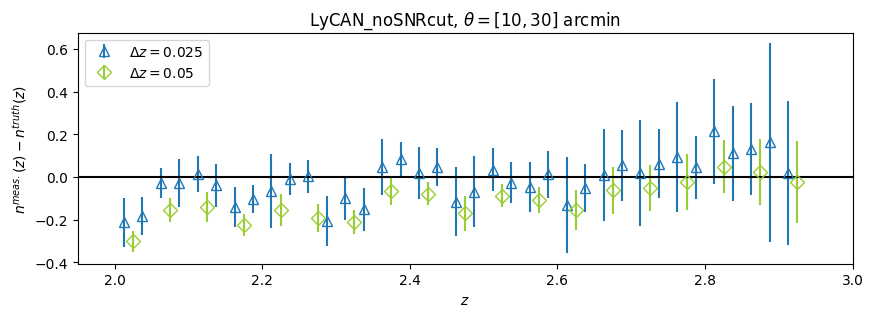

In [21]:
fig,axarr=pl.subplots(figsize=[10,3])
fmt=['^','D']
color=['C0','yellowgreen']
#label=["Picca", "LyCAN"]

for jj in range(len(Nbins)):
    nbin = Nbins[jj]
    if nbin == 20:
        label = "$\\Delta z = 0.05$"
    else:
        label = "$\\Delta z = 0.025$"
    for mm, mode in enumerate(sim_modes):
        pl.errorbar(z[nbin], ncc_mean[nbin][mode][0][:,0]-nz_norm[nbin][-nbin:], yerr=ncc_mean[nbin][mode][0][:,1], 
                        fmt=fmt[jj], label=label,color=color[jj],markersize=7, fillstyle='none')
pl.title(mode + ", " + f"$\\theta = [{theta_min[0]}, {theta_max[0]}]$ arcmin")

pl.plot([1.8,3.0],[0,0],'k-')
#pl.stairs(nz_norm,nz_edges, color='k', label='truth')

pl.ylabel("$n^{meas.}(z) - n^{truth}(z)$")
pl.xlabel("$z$")
pl.xlim([1.95,3.0])
#pl.ylim([-0.1,1.75])

pl.legend(loc='upper left')
#pl.title("Avg. and std. of 10 mocks")
pl.savefig("../plots/ncc-nbins-theta-10-30-lycan-SRD_nz.pdf", bbox_inches="tight")